In [58]:
from ctypes import windll
#from sympy.physics.units.definitions.unit_definitions import ms
windll.shcore.SetProcessDpiAwareness(1)
import tkinter as tk

#由你的电脑的屏幕大小来决定

def get_screen_size():
    root = tk.Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width, screen_height
screen_wide,screen_high=get_screen_size()

print(screen_wide,screen_high  )


2560 1600


相同的DW下，16次实验，目的：探究距离的影响

1.读取数据

In [59]:
d1,d2=2500,2500
w1,w2=80,80



import pickle
import sys

def read_data(d1,d2,w1,w2):
    '''
    通过D,和W的大小来区分和读取数据，并返回四个数据结果。
    '''
    name=sys.path[0]+'\data\\'+'D='+str(d1)+'-'+str(d2)+'_W='+str(w1)+'-'+str(w2)+".bin"

    with open(name,'rb') as file:
        move_datas=pickle.load(file)
    
    return move_datas

mouse_move=read_data(d1,d2,w1,w2)

mouse_move中，顺序是：第几条轨迹，第几个时间点，当前的位置（t,x,y）

In [60]:
import numpy as np
for i in range(len(mouse_move)):
    print(np.shape(mouse_move[i]))
print(mouse_move[0][0])

(317128, 3)
(294003, 3)
(356853, 3)
(344359, 3)
(316566, 3)
(357520, 3)
(310444, 3)
(357015, 3)
(386544, 3)
(289659, 3)
(318283, 3)
(294140, 3)
(275822, 3)
(325805, 3)
(264668, 3)
(279529, 3)
(1690954726.6222763, 60.0, 804.0)


对单条轨迹进行判断，使用冒泡算法，当前后点相同时,t相同，删除轨迹点

In [61]:
def clean(mouse_move):
    new1=[]
    for i in range(len(mouse_move)):
        new2=[]
        t=-1
        x=-1
        y=-1
        for j in range(len(mouse_move[i])):
            
            if t==mouse_move[i][j][0] and x==mouse_move[i][j][1] and y==mouse_move[i][j][2]:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                continue
            else:
                t=mouse_move[i][j][0]
                x=mouse_move[i][j][1]
                y=mouse_move[i][j][2]
                new2.append(mouse_move[i][j])
        new1.append(new2)
    return new1

mouse_move=clean(mouse_move)

对于其中某些点进行处理，如果时间相同则，将其时间取前后时间的平均，

In [62]:
def average(mouse_move):
    new=[]
    for i in range(len(mouse_move)):
        new1=[]
        for j in range(len(mouse_move[i])-1):
            t=mouse_move[i][j][0]
            if mouse_move[i][j][0]==mouse_move[i][j+1][0]:
                r=1
                for k in range(j+1,len(mouse_move[i])-1):
                    if mouse_move[i][j][0]==mouse_move[i][k][0]:
                        r+=1
                        #print(k)
                #print('对于',mouse_move[i][j][0],'有',r,'个连续重复值')
                
                t0=mouse_move[i][j-1][0]
                t1=mouse_move[i][j+r][0]
                m=(t1-t0)/(r+1)
                t=t0+m*2
                
            new1.append([t,mouse_move[i][j][1],mouse_move[i][j][2]])
        new.append(new1)    
    
    for i in range(len(new)):
        for j in range(len(new[i])-1):
            if new[i][j][0]==new[i][j+1][0]:
                print('存在前后相同点：',i,j)
    
    return new

mouse_move=average(mouse_move)



In [63]:
import numpy as np
t=[]
for i in range(len(mouse_move)):
    print(np.shape(mouse_move[i]))
    print(mouse_move[i][-1][0]-mouse_move[i][0][0])
    t.append(mouse_move[i][-1][0]-mouse_move[i][0][0])

print('平均时间为',np.mean(t))

(1346, 3)
0.8866772651672363
(1920, 3)
0.9643943309783936
(2026, 3)
1.1061890125274658
(2111, 3)
1.1093792915344238
(2127, 3)
1.0758335590362549
(2311, 3)
1.1786518096923828
(2007, 3)
1.0395054817199707
(1955, 3)
1.0934078693389893
(2101, 3)
1.1766738891601562
(1796, 3)
0.9110848903656006
(1909, 3)
1.0073323249816895
(1909, 3)
0.9641909599304199
(1422, 3)
0.8390858173370361
(2217, 3)
1.0986907482147217
(1777, 3)
0.9139184951782227
(1740, 3)
0.9466373920440674
平均时间为 1.0194783210754395


2.将轨迹数据转换为pd.DataFrame格式

In [64]:
import pandas as pd

Track={}
for i in range(len(mouse_move)):
    Track[i]=pd.DataFrame(mouse_move[i])
    Track[i].columns=['t','x','y']
    


3.计算轨迹数据中的其他相关项（速度，角度，距离）

#进行y方向平滑处理

In [65]:
import numpy as np




def identify(data):
    #识别异常值
    
    # 计算均值和标准差
    mean_val = np.mean(data)
    std_val = np.std(data)

    # 定义阈值（这里使用2个标准差作为阈值）
    threshold = 3 * std_val

    # 识别异常值
    outliers = [x for x in data if abs(x - mean_val) > threshold]

    # 替换异常值（这里使用均值来替换）
    for outlier in outliers:
        data[data.index(outlier)] = mean_val + (np.random.rand(1)[0])*threshold


    return data



def setValue(Track):
    '''
        计算速度和时间
    '''
    trace=[]
    for i in range(len(Track)):
        T=Track[i].t.values.tolist()
        X=Track[i].x.values.tolist()
        Y=Track[i].y.values.tolist()
        
        #将时间标准化
        t0=T[0]
        for i in range(len(T)):
            T[i]=T[i]-t0
        
        index=[0,]
        for i in range(1,len(Y)-1):
            if Y[i]==Y[i-1] and Y[i]!=Y[i+1]:
                index.append(i+1)
        index.append(len(Y)-1)
        
        s=0
        S=[0,]#点在轨迹上的位置
        for i in range(1,len(X)):
            s+=np.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)
            S.append(s)
        
        v_x=[0,]
        for i in range(1,len(X)):
            v_x.append((X[i]-X[i-1])/(T[i]-T[i-1]))
        v_x=identify(v_x)
            
        v_y=[0,]
        for i in range(1,len(Y)):
            v_y.append((Y[i]-Y[i-1])/(T[i]-T[i-1]))
        v_y=identify(v_y)
            
        v=[0,]
        for i in range(1,len(v_x)):
            
            v.append(np.sqrt((v_x[i])**2+(v_y[i])**2))
        v=identify(v)
        
            
        pandasDataSet=[]
        for i in range(len(X)):
            pandasDataSet.append((T[i],X[i],Y[i],S[i],v_x[i],v_y[i],v[i]))
        
        trace.append(pd.DataFrame(pandasDataSet,columns=['t','x','y','s','v_x','v_y','v']))
        
    return trace

Track=setValue(Track)
print(Track[0])


             t       x      y            s  v_x  v_y    v
0     0.000000    60.0  804.0     0.000000  0.0  0.0  0.0
1     0.001000    60.0  804.0     0.000000  0.0  0.0  0.0
2     0.002000    60.0  804.0     0.000000  0.0  0.0  0.0
3     0.003000    60.0  804.0     0.000000  0.0  0.0  0.0
4     0.003999    60.0  804.0     0.000000  0.0  0.0  0.0
...        ...     ...    ...          ...  ...  ...  ...
1341  0.883738  2535.0  812.0  2554.690824  0.0  0.0  0.0
1342  0.884500  2535.0  812.0  2554.690824  0.0  0.0  0.0
1343  0.884575  2535.0  812.0  2554.690824  0.0  0.0  0.0
1344  0.885681  2535.0  812.0  2554.690824  0.0  0.0  0.0
1345  0.886677  2535.0  812.0  2554.690824  0.0  0.0  0.0

[1346 rows x 7 columns]


绘制双变量

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


def plot2data(Track,x,y):
    colors = [
    ('red', '#FF0000'),
    ('lime', '#00FF00'),
    ('blue', '#0000FF'),
    ('yellow', '#FFFF00'),
    ('cyan', '#00FFFF'),
    ('magenta', '#FF00FF'),
    ('orange', '#FFA500'),
    ('darkred', '#8B0000'),
    ('darkgreen', '#006400'),
    ('darkblue', '#00008B'),
    ('darkgoldenrod', '#B8860B'),
    ('purple', '#800080'),
    ('hotpink', '#FF69B4'),
    ('teal', '#008080'),
    ('silver', '#C0C0C0'),
    ('saddlebrown', '#8B4513')
]

    sorted_colors = sorted(colors)

    plt.figure(figsize=(16, 9),dpi=300)
    print(len(Track))
    for i in range(len(Track)):
        X=np.array(Track[i][x].values.tolist())
        Y=np.array(Track[i][y].values.tolist())
        
        
        #plt.axis('equal')
        # 绘制原始数据和拟合曲线
        plt.scatter(X, Y, color=sorted_colors[i][0],s=1)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(x+'-'+y)
        #plt.legend()
        plt.grid(True)
    plt.show()

5.绘制x,y的散点图

16


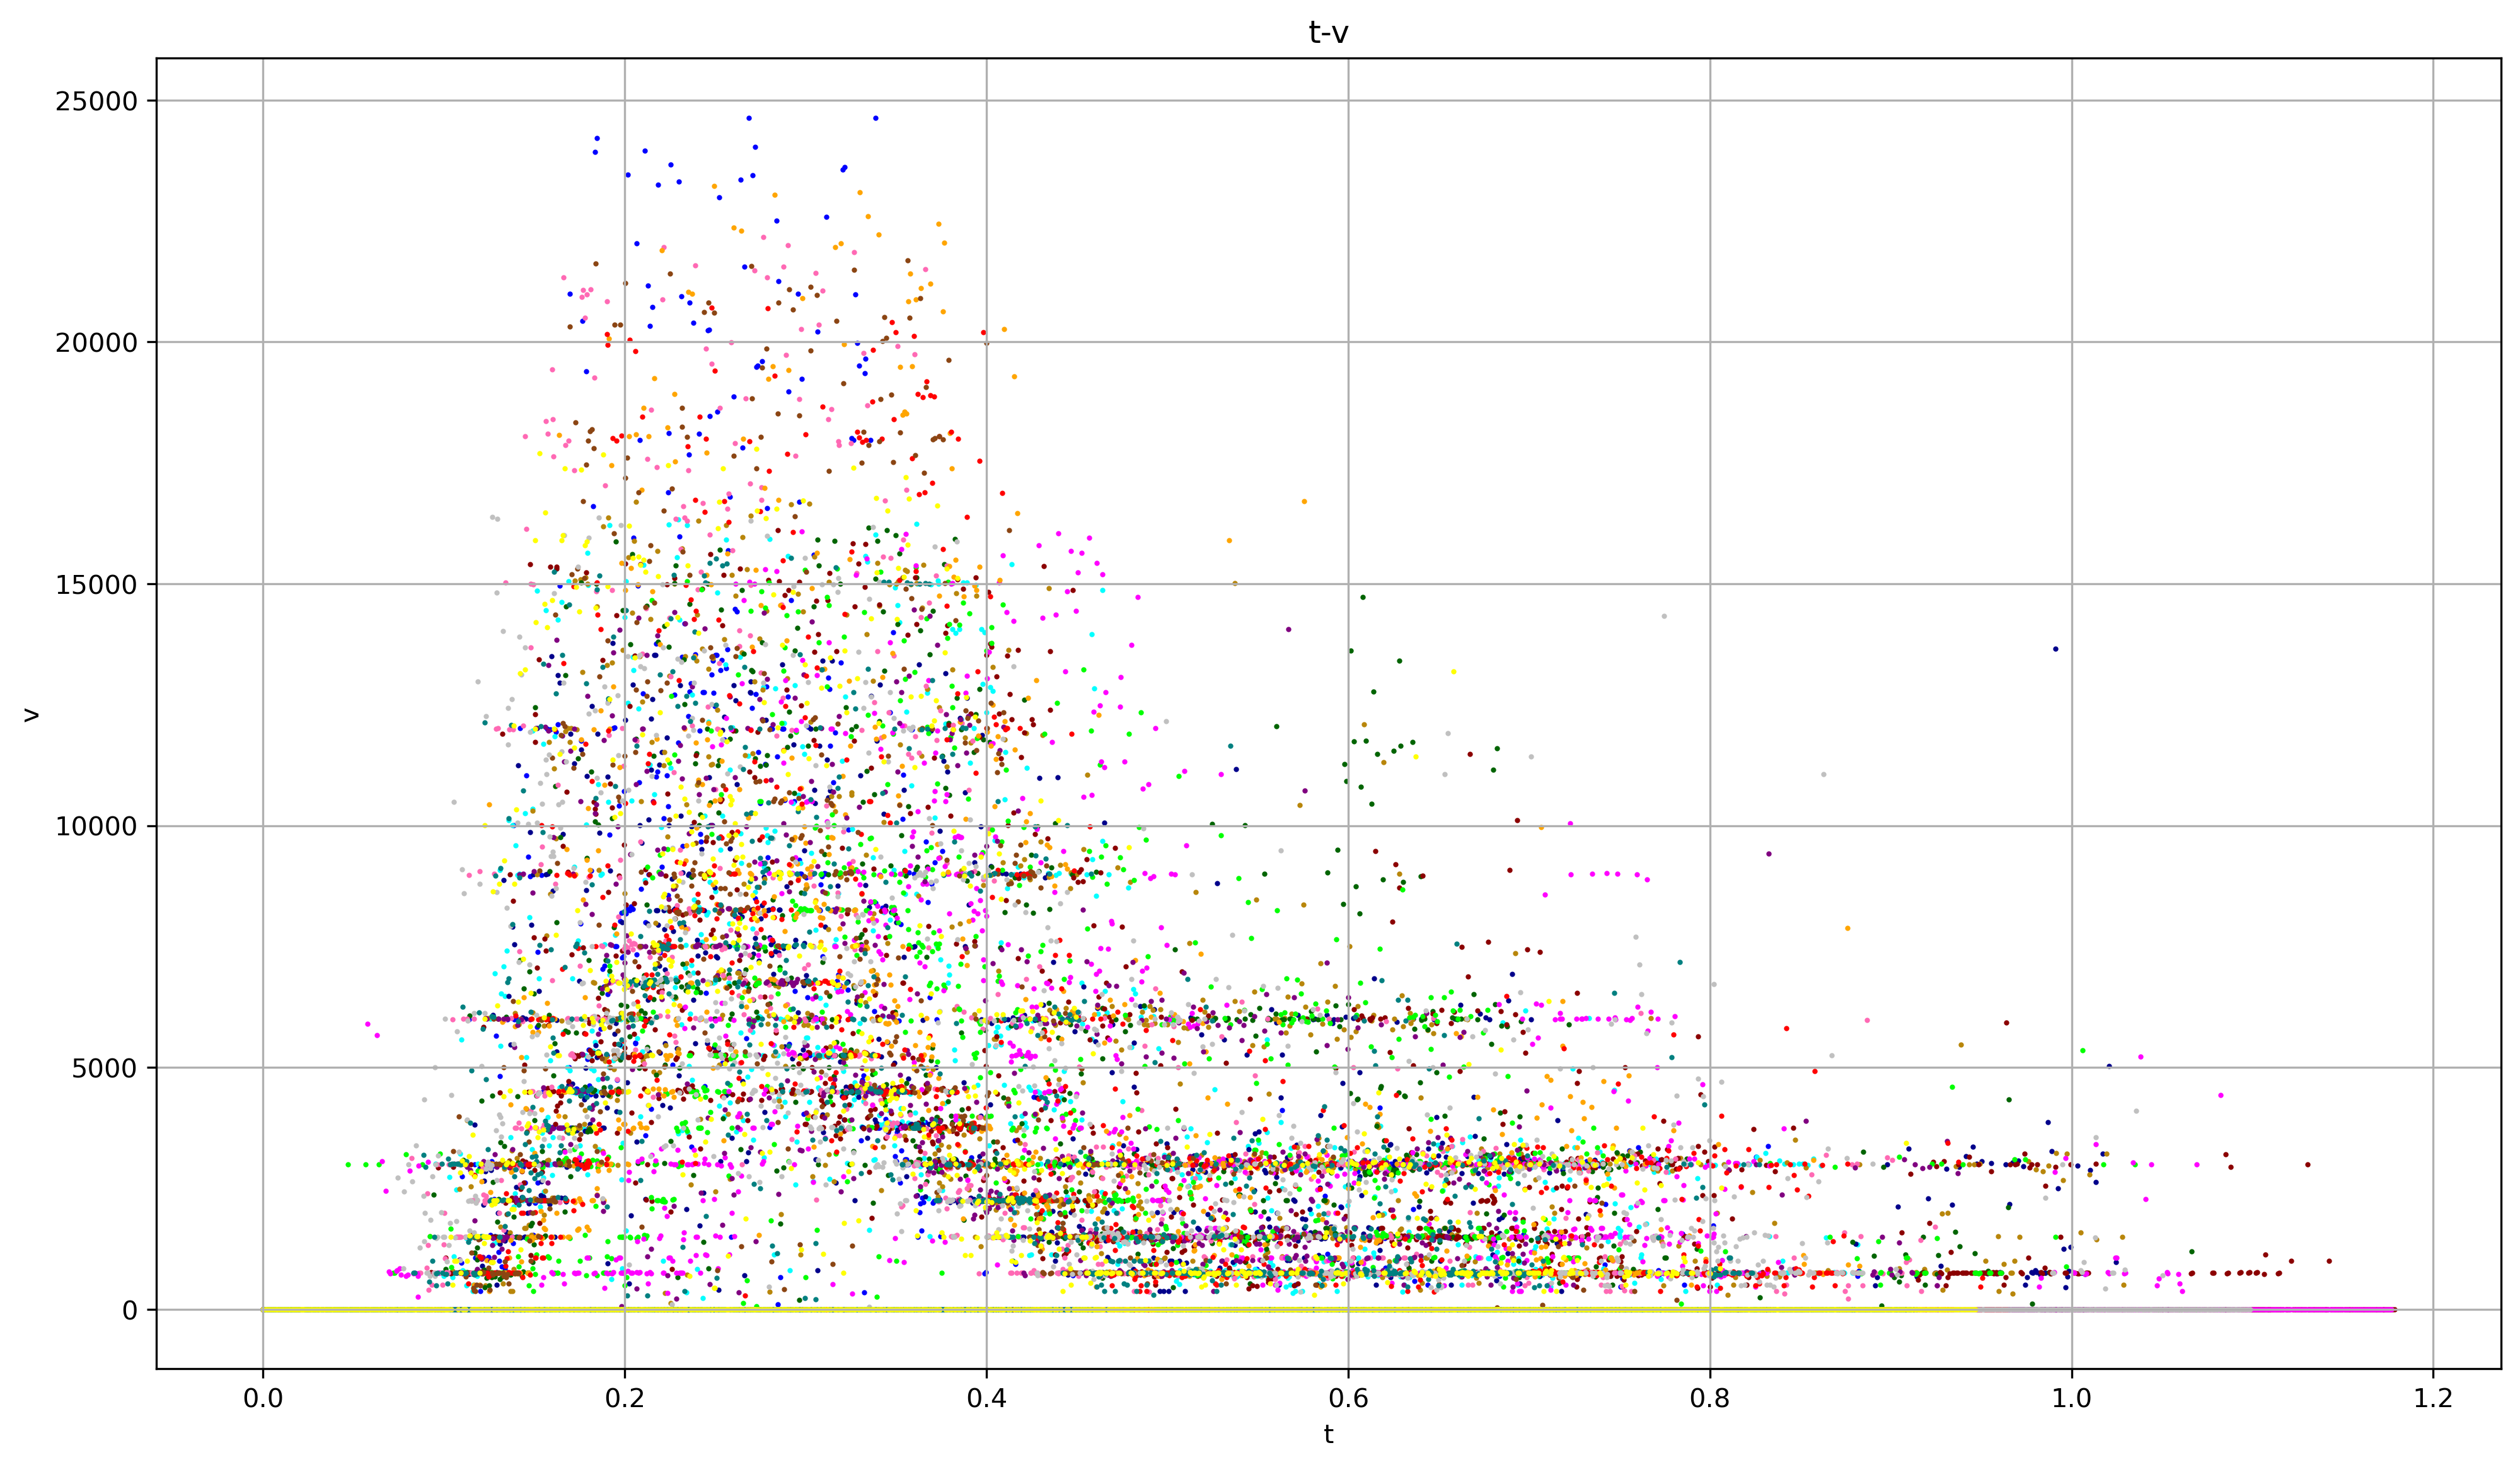

In [67]:
plot2data(Track,'t','v')

16


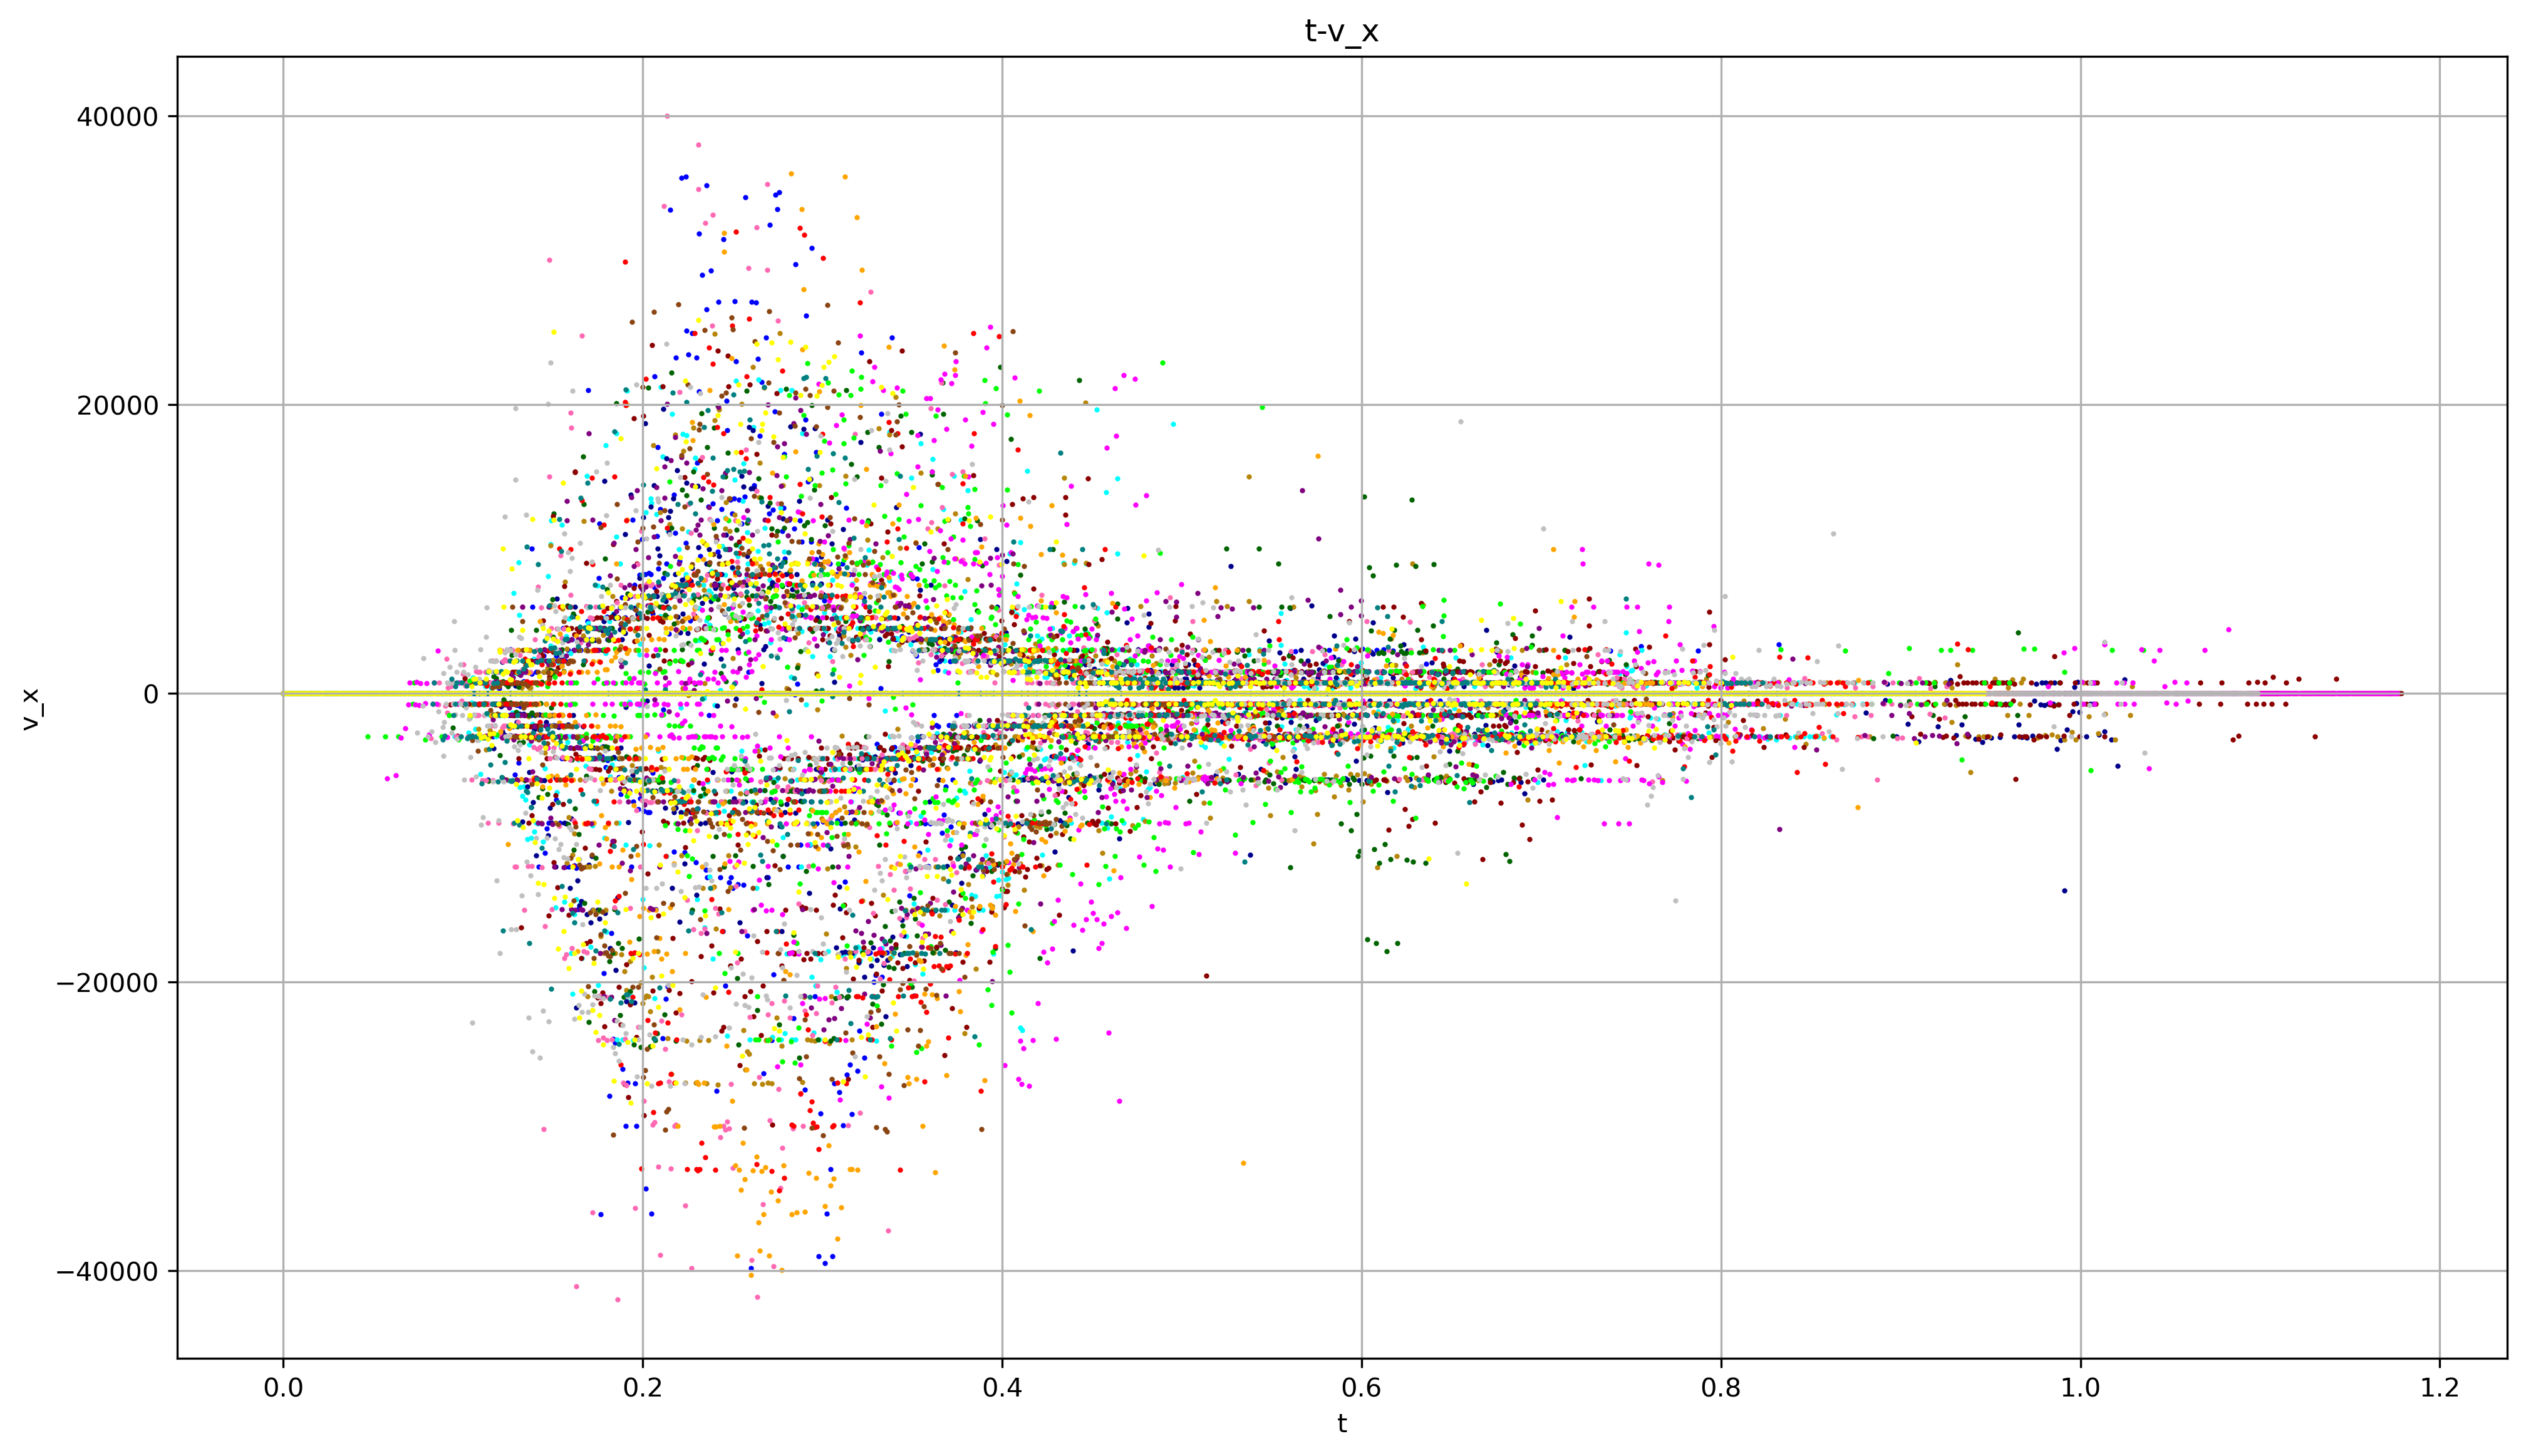

In [68]:
plot2data(Track,'t','v_x')

6.绘制t,s的散点图

16


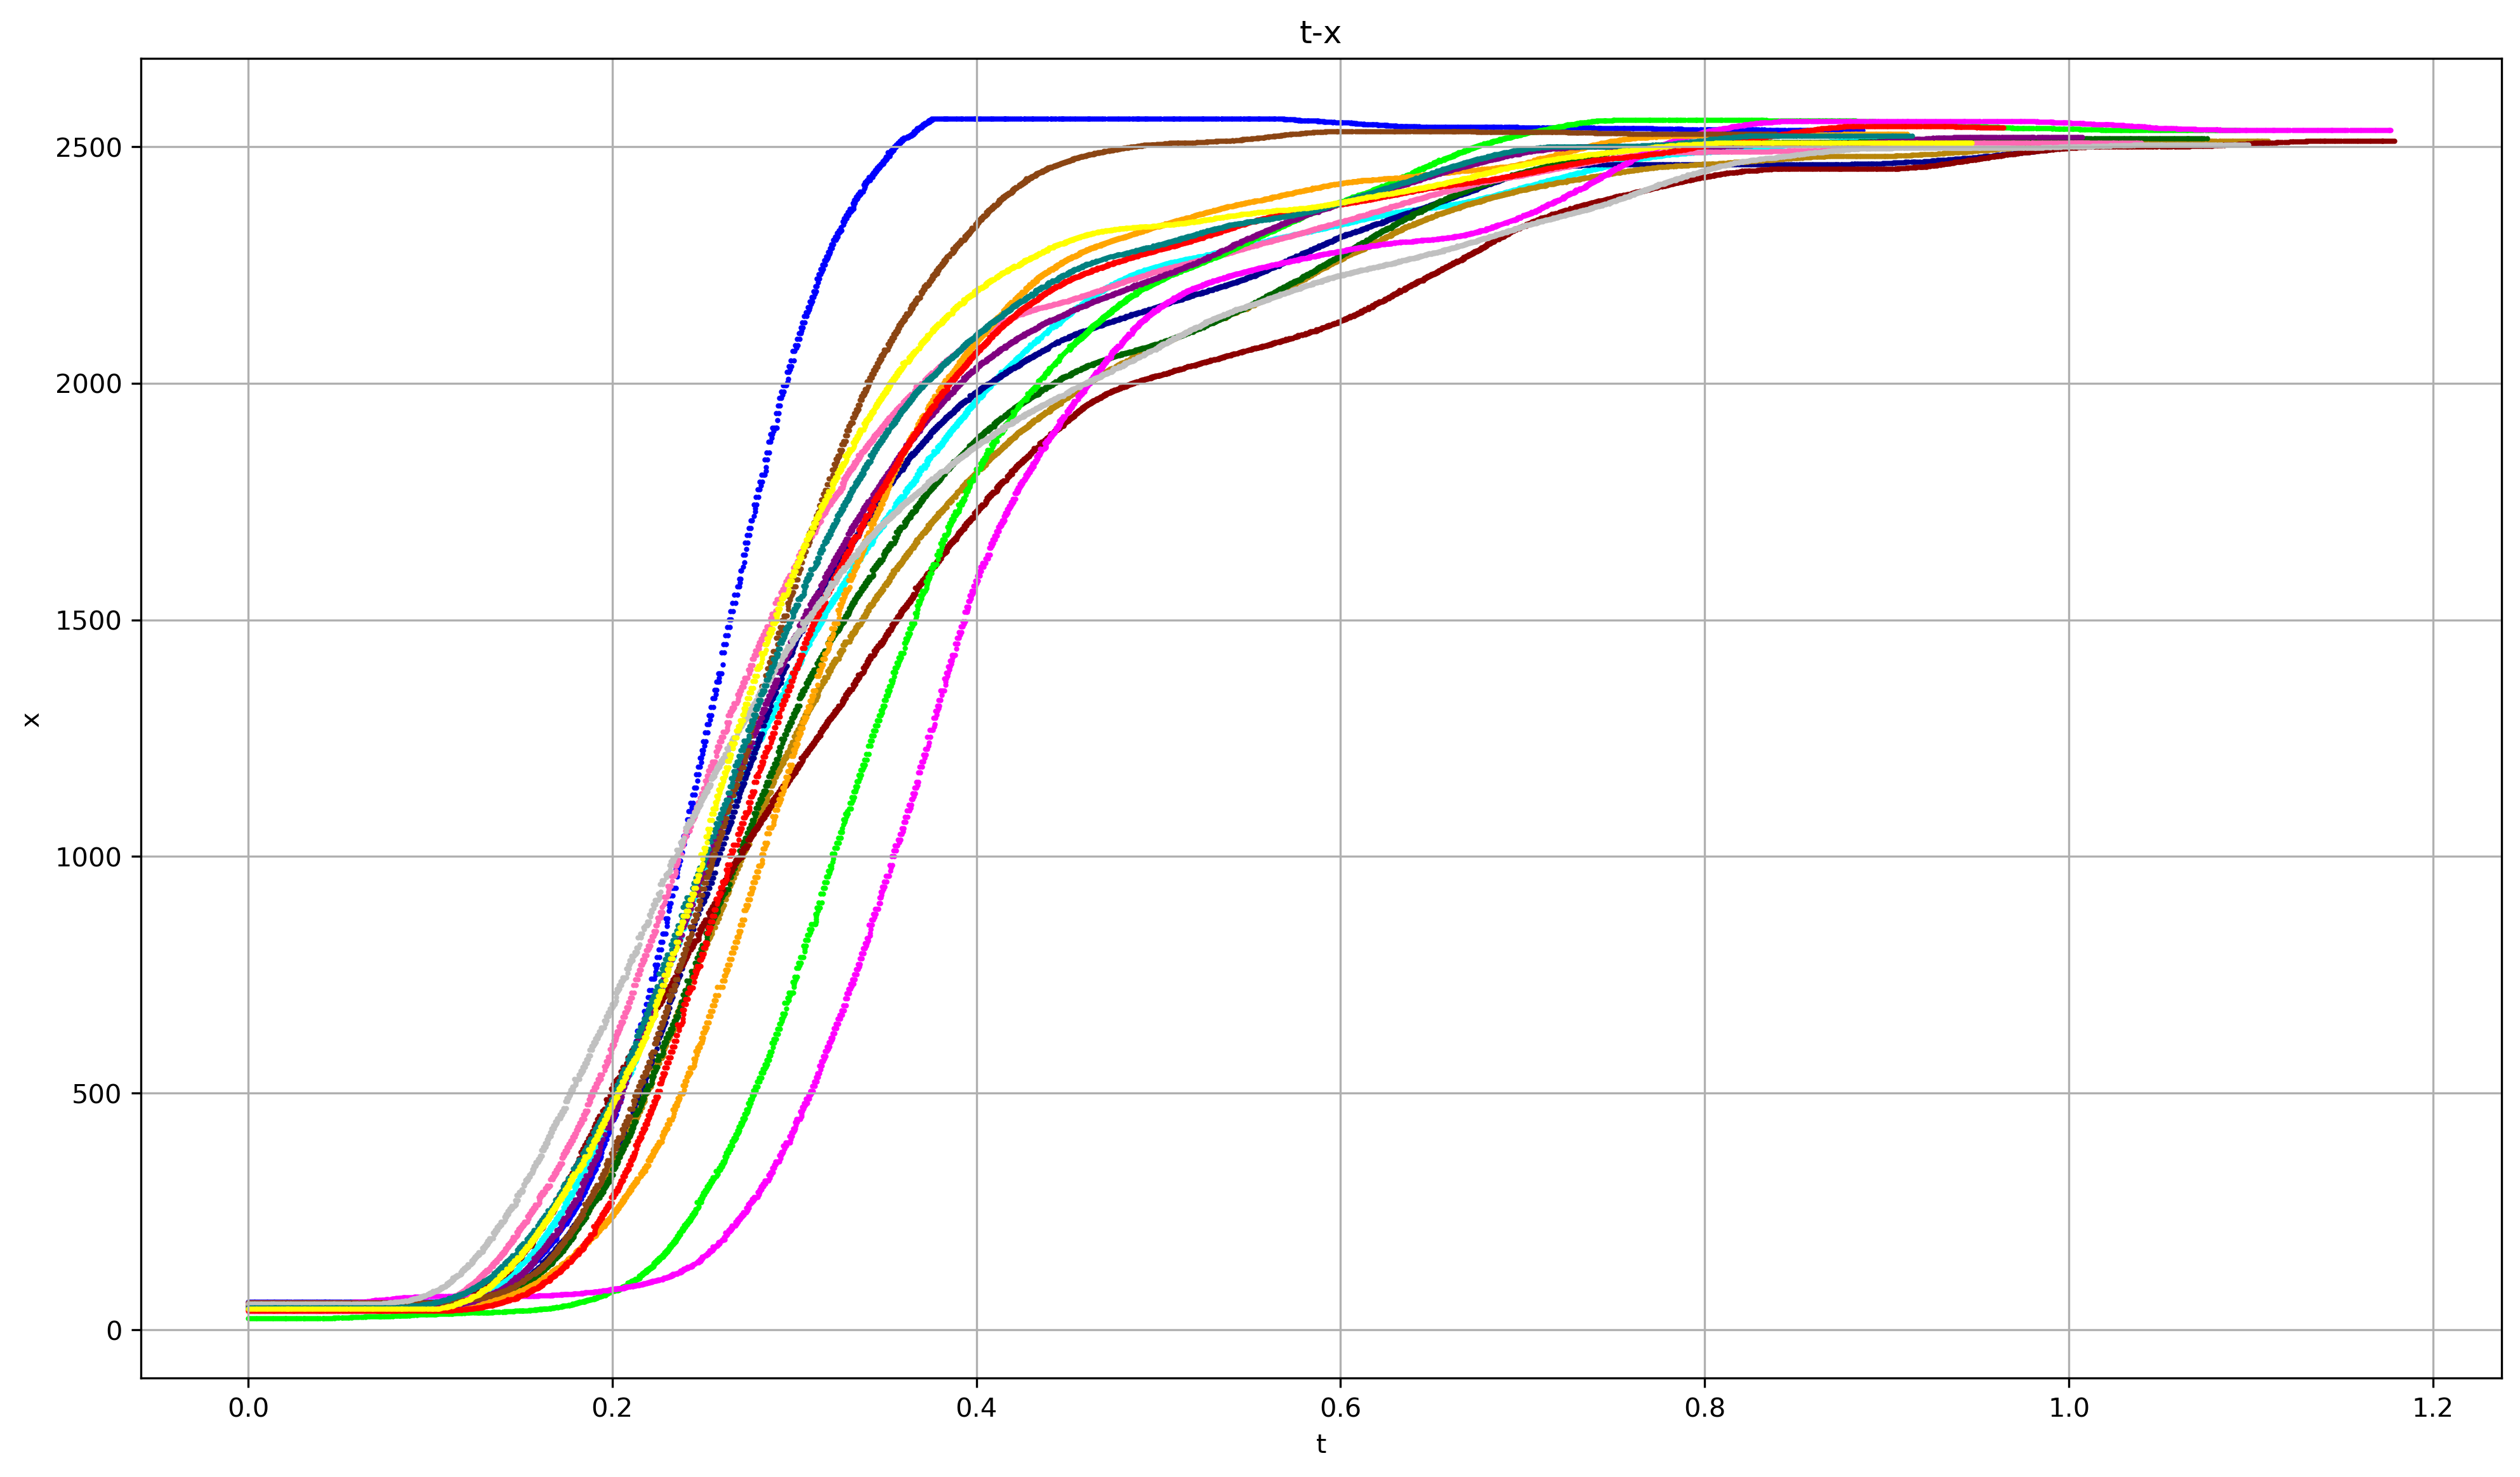

In [69]:
plot2data(Track,'t','x')

绘制三变量

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


def plot3data(Track,x,y,z):
    colors = [
    ('red', '#FF0000'),
    ('black', '#00FF00'),
    ('blue', '#0000FF'),]

    sorted_colors = sorted(colors)

    #plt.figure(figsize=(16, 9),dpi=300)
    print(len(Track))
    for i in range(len(Track)):
        fig, ax1 = plt.subplots()
        fig.dpi=300
        fig.set_size_inches(16, 9)
        #plt.figure(figsize=(16, 9),dpi=300)
        X=np.array(Track[i][x].values.tolist())
        Y=np.array(Track[i][y].values.tolist())
        Z=np.array(Track[i][z].values.tolist())
        
        #plt.axis('equal')
        # 绘制原始数据和拟合曲线
        ax1.set_xlabel(x)
        ax1.set_ylabel(y, color=colors[0][0])
        ax1.scatter(X, Y, color=colors[0][0],s=1)
        ax1.tick_params(axis='y', labelcolor=colors[0][0])
        
        ax2 = ax1.twinx()  # 创建共享X轴的第二个坐标轴

        ax2.set_ylabel(z, color=colors[1][0])
        ax2.scatter(X, Z, color=colors[1][0],s=1)
        ax2.tick_params(axis='y', labelcolor=colors[1][0])
        
        
        plt.title(x+'-'+y+'-'+z)
        #plt.legend()
        plt.grid(True)
        plt.show()

将时间，轨迹，速度，放一起来看

In [73]:
#plot3data(Track,'t','x','v')

单独绘制带有边界的,通过边界进行区分，

16


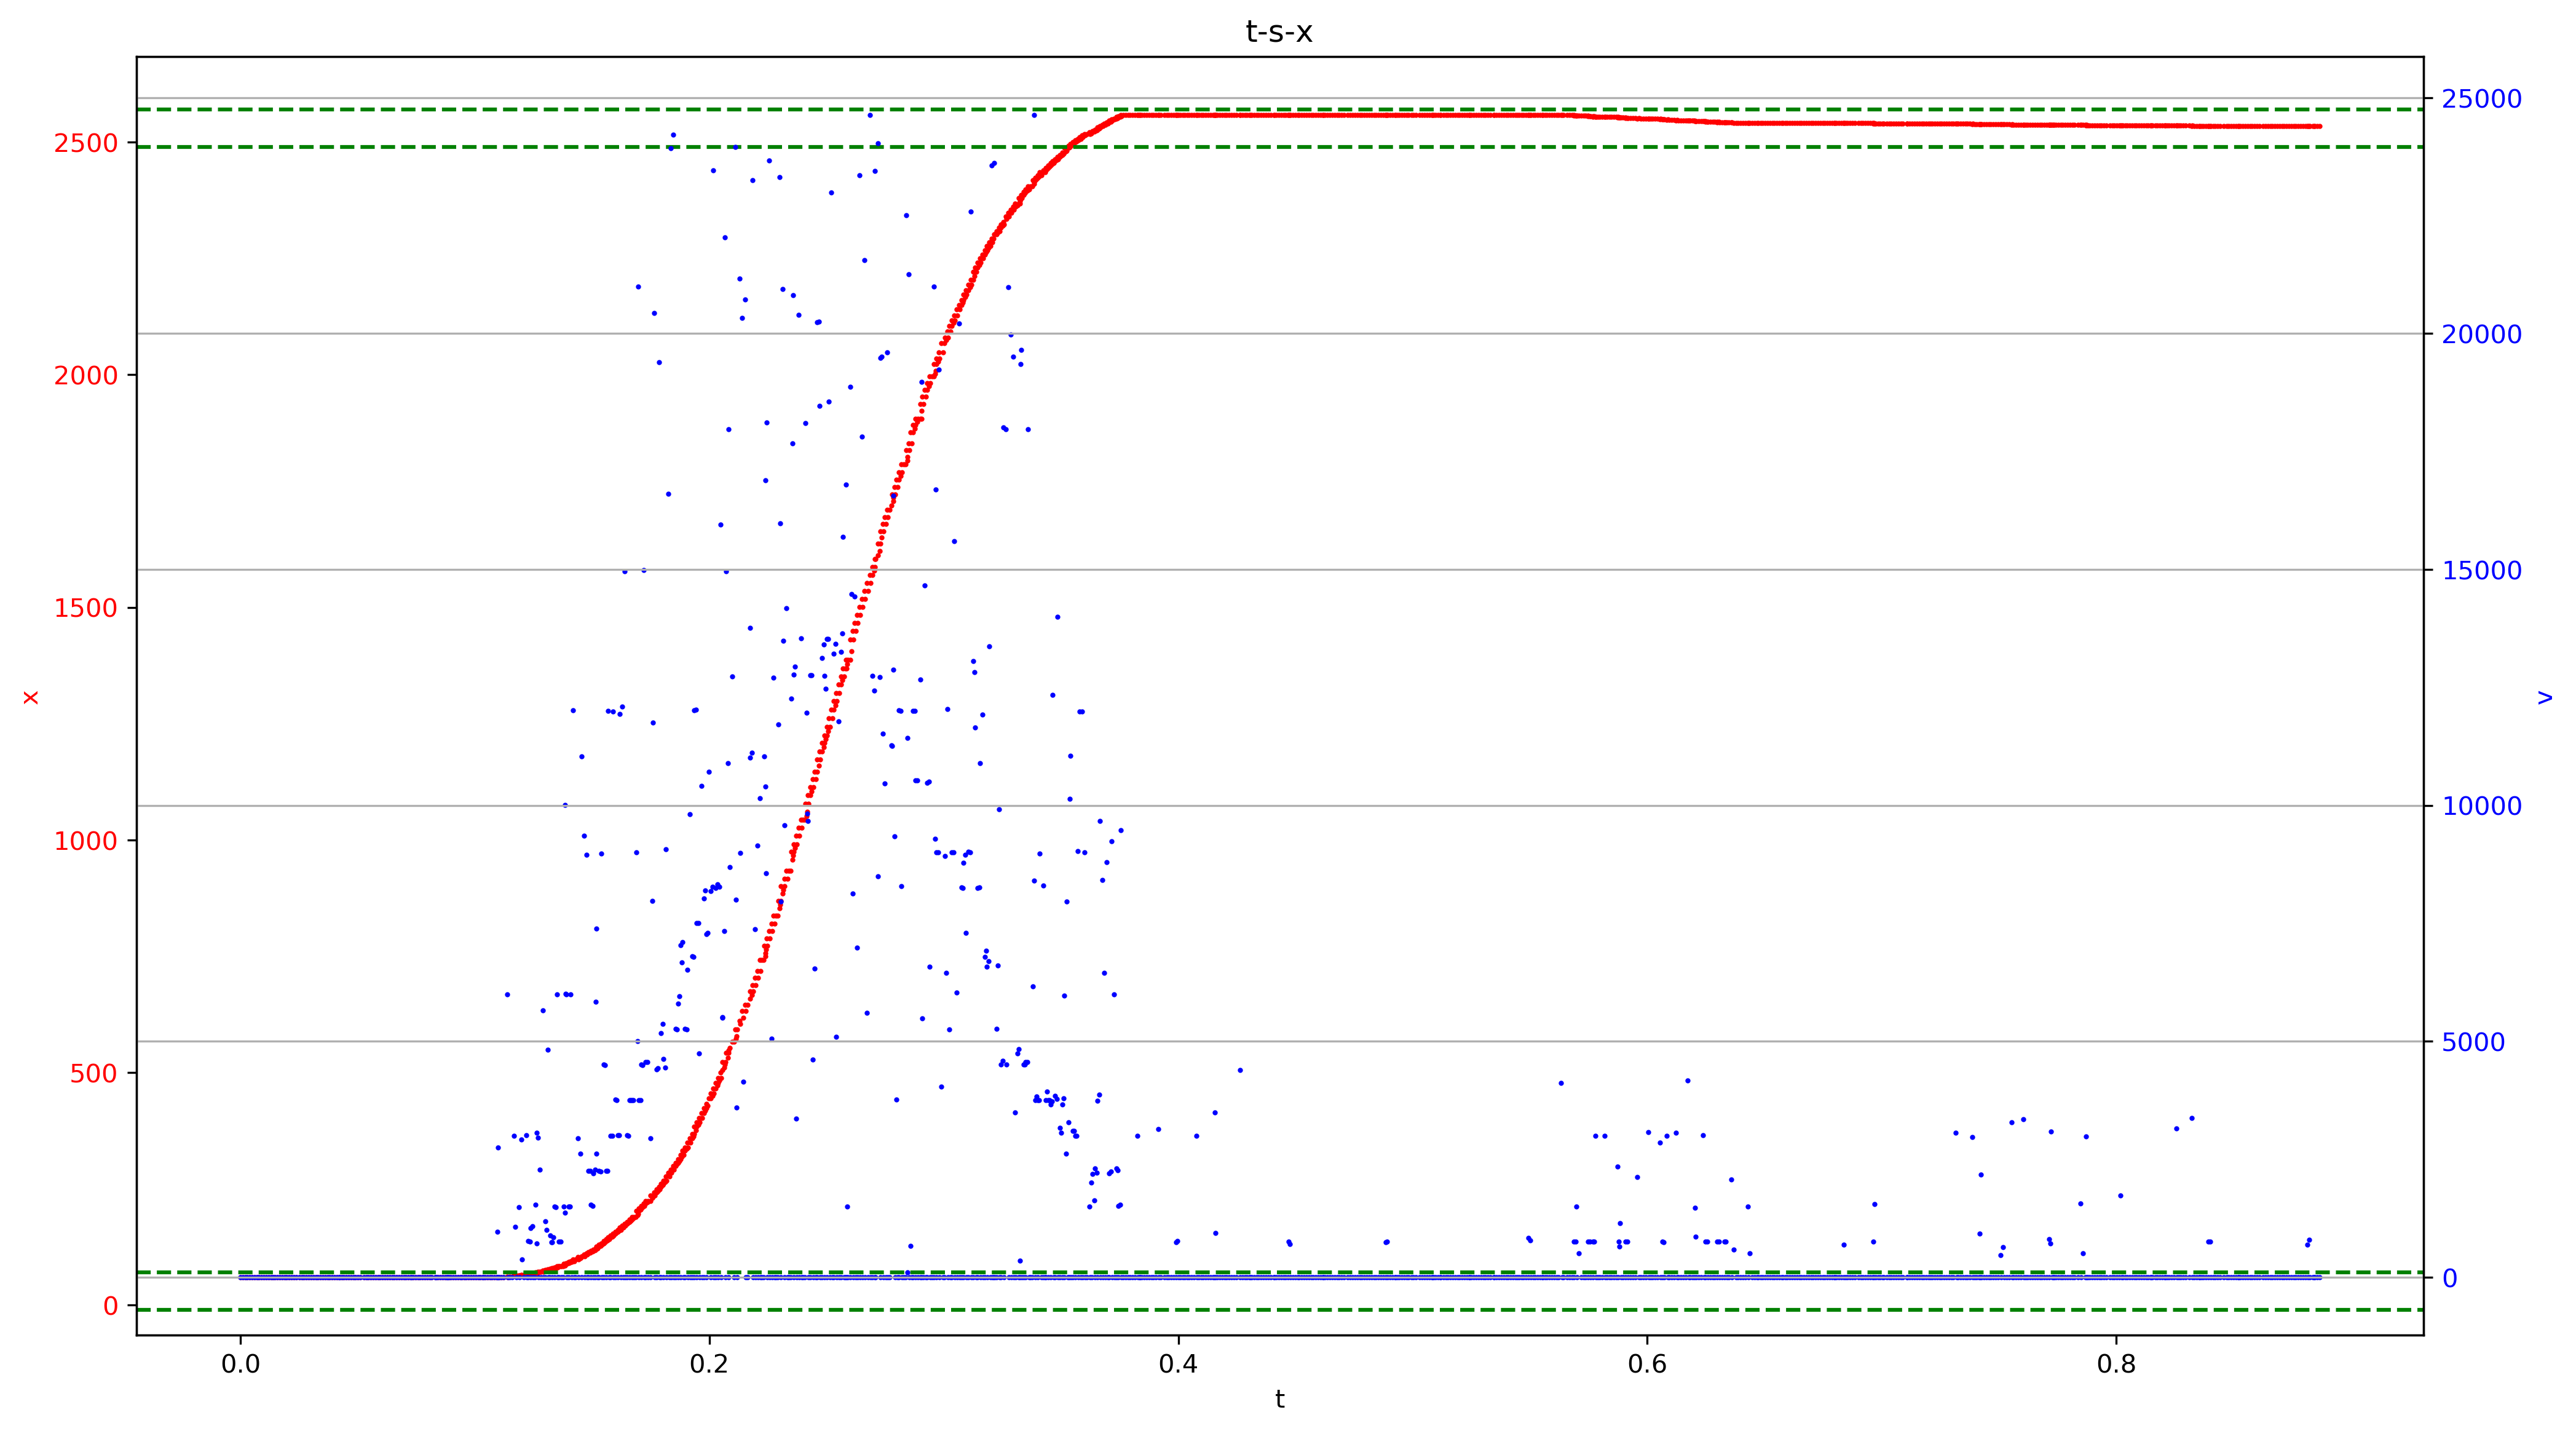

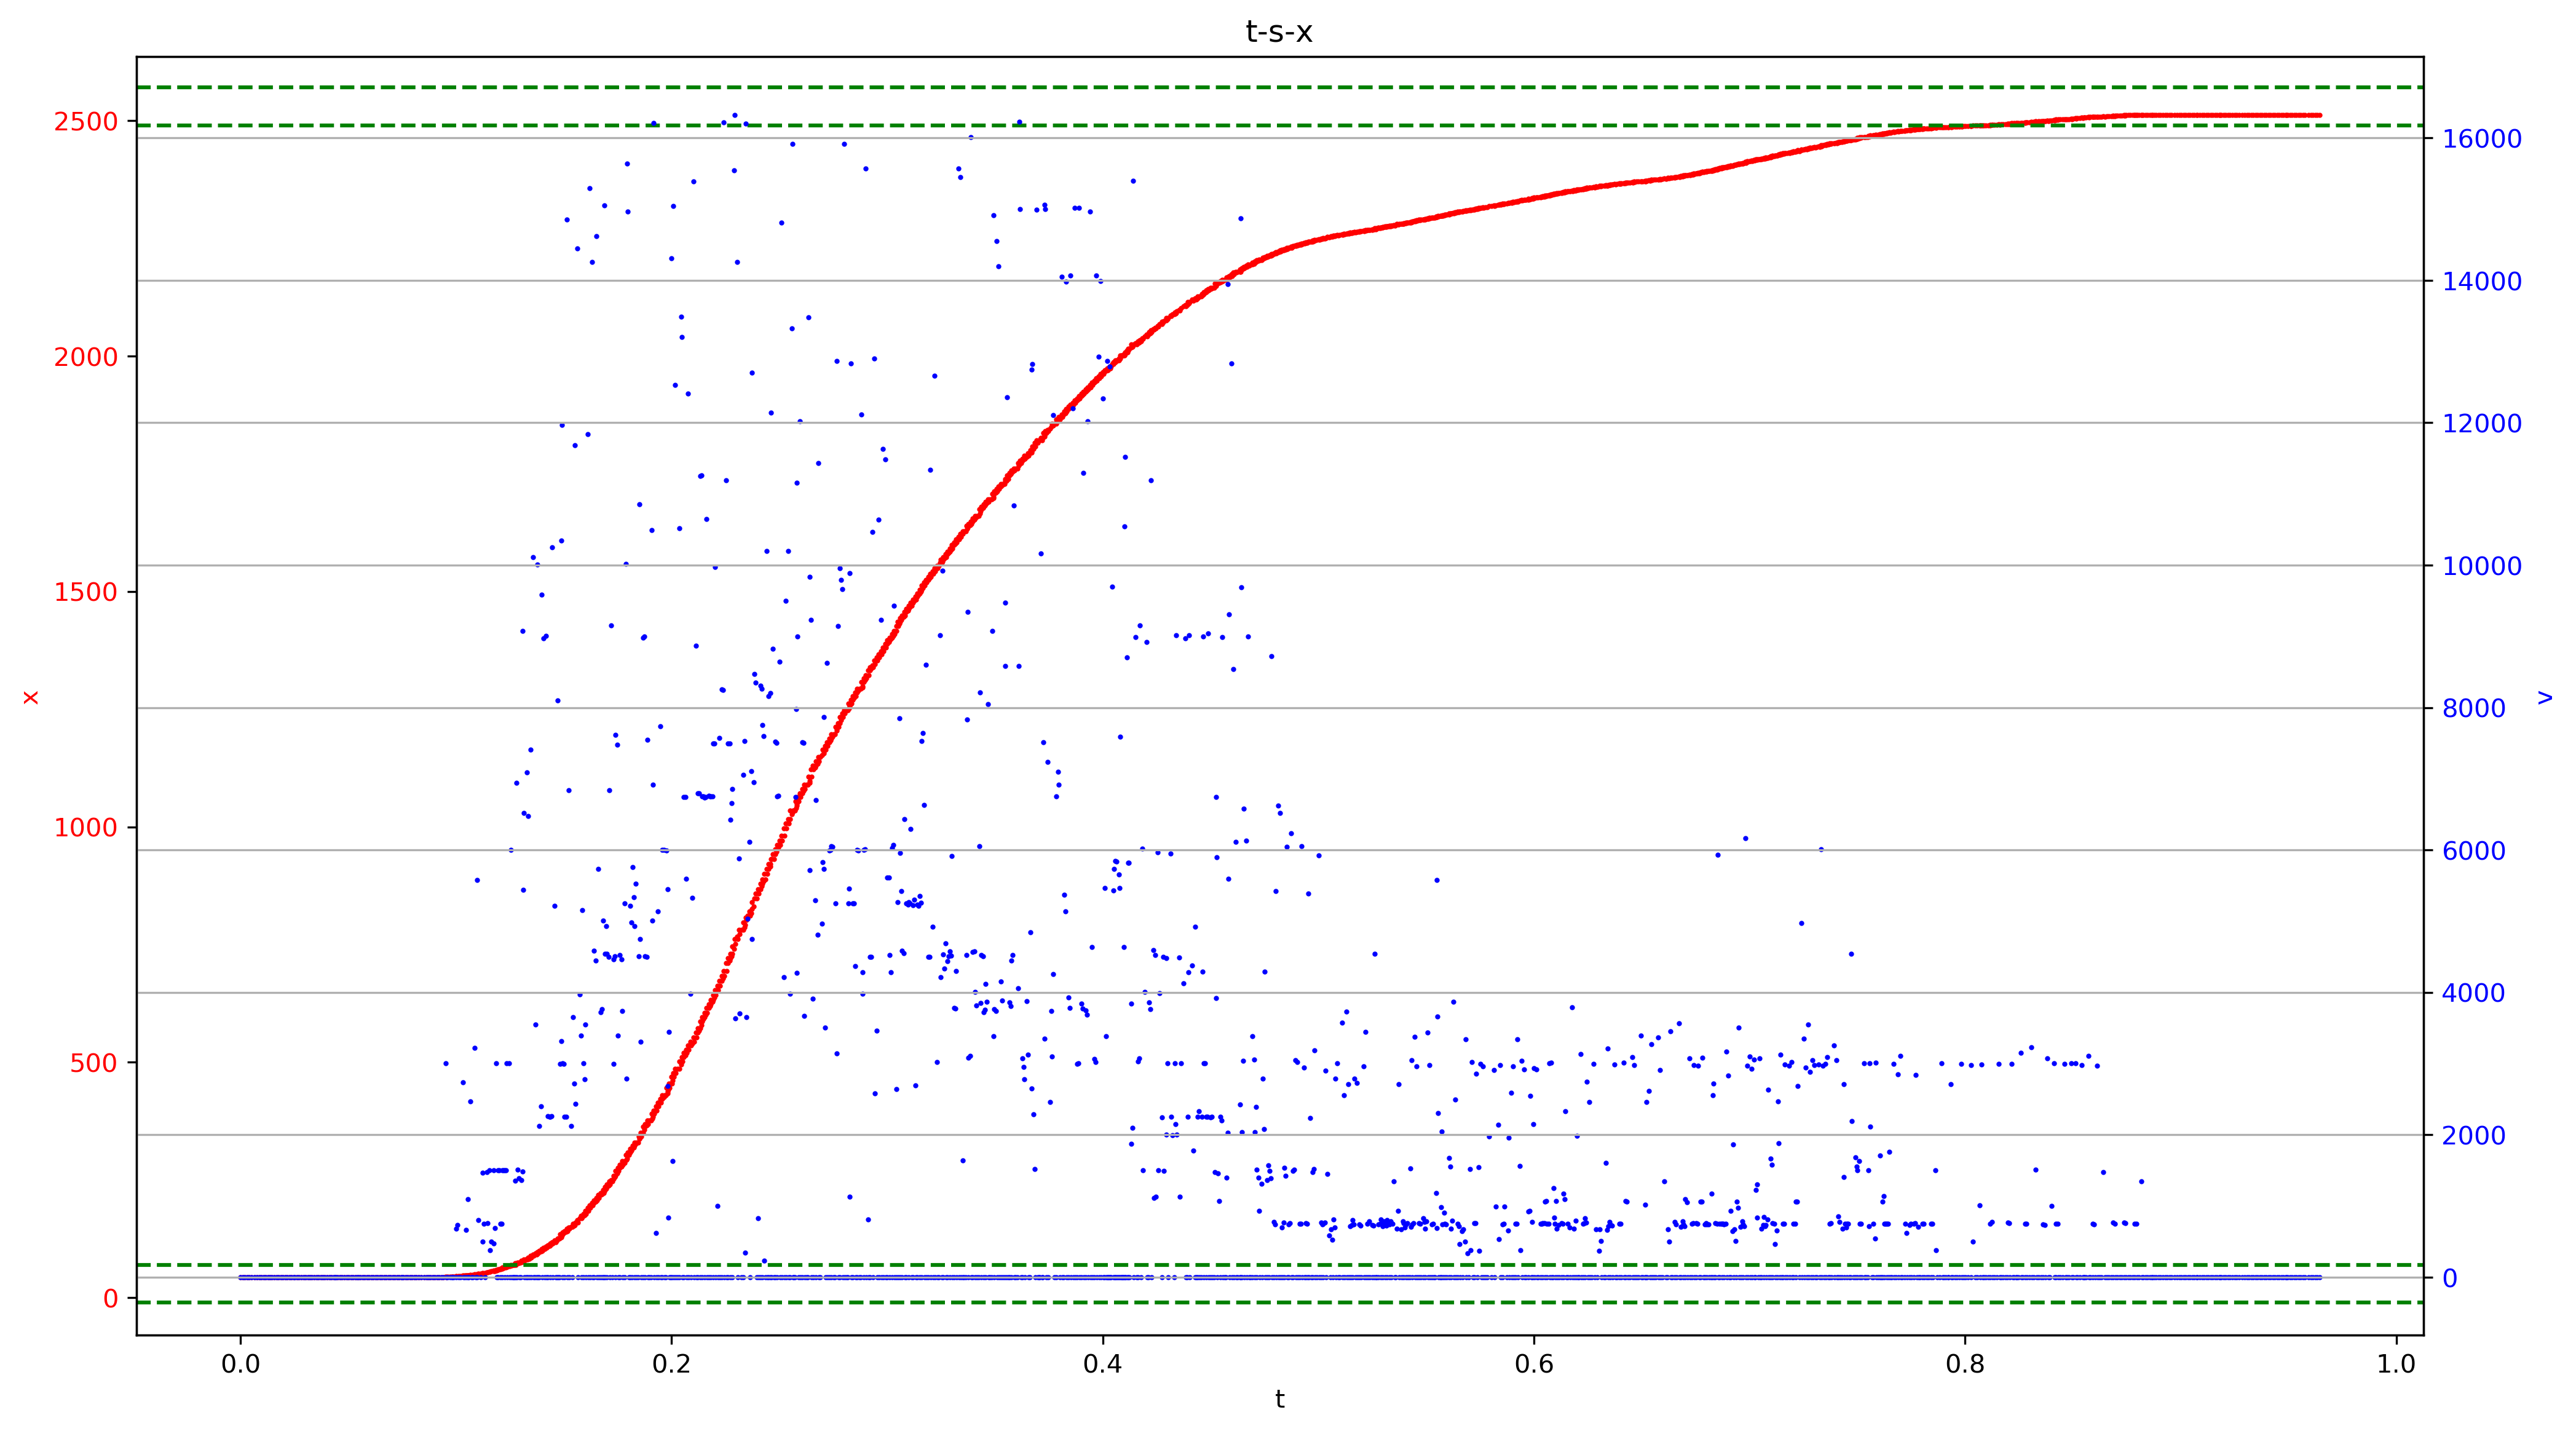

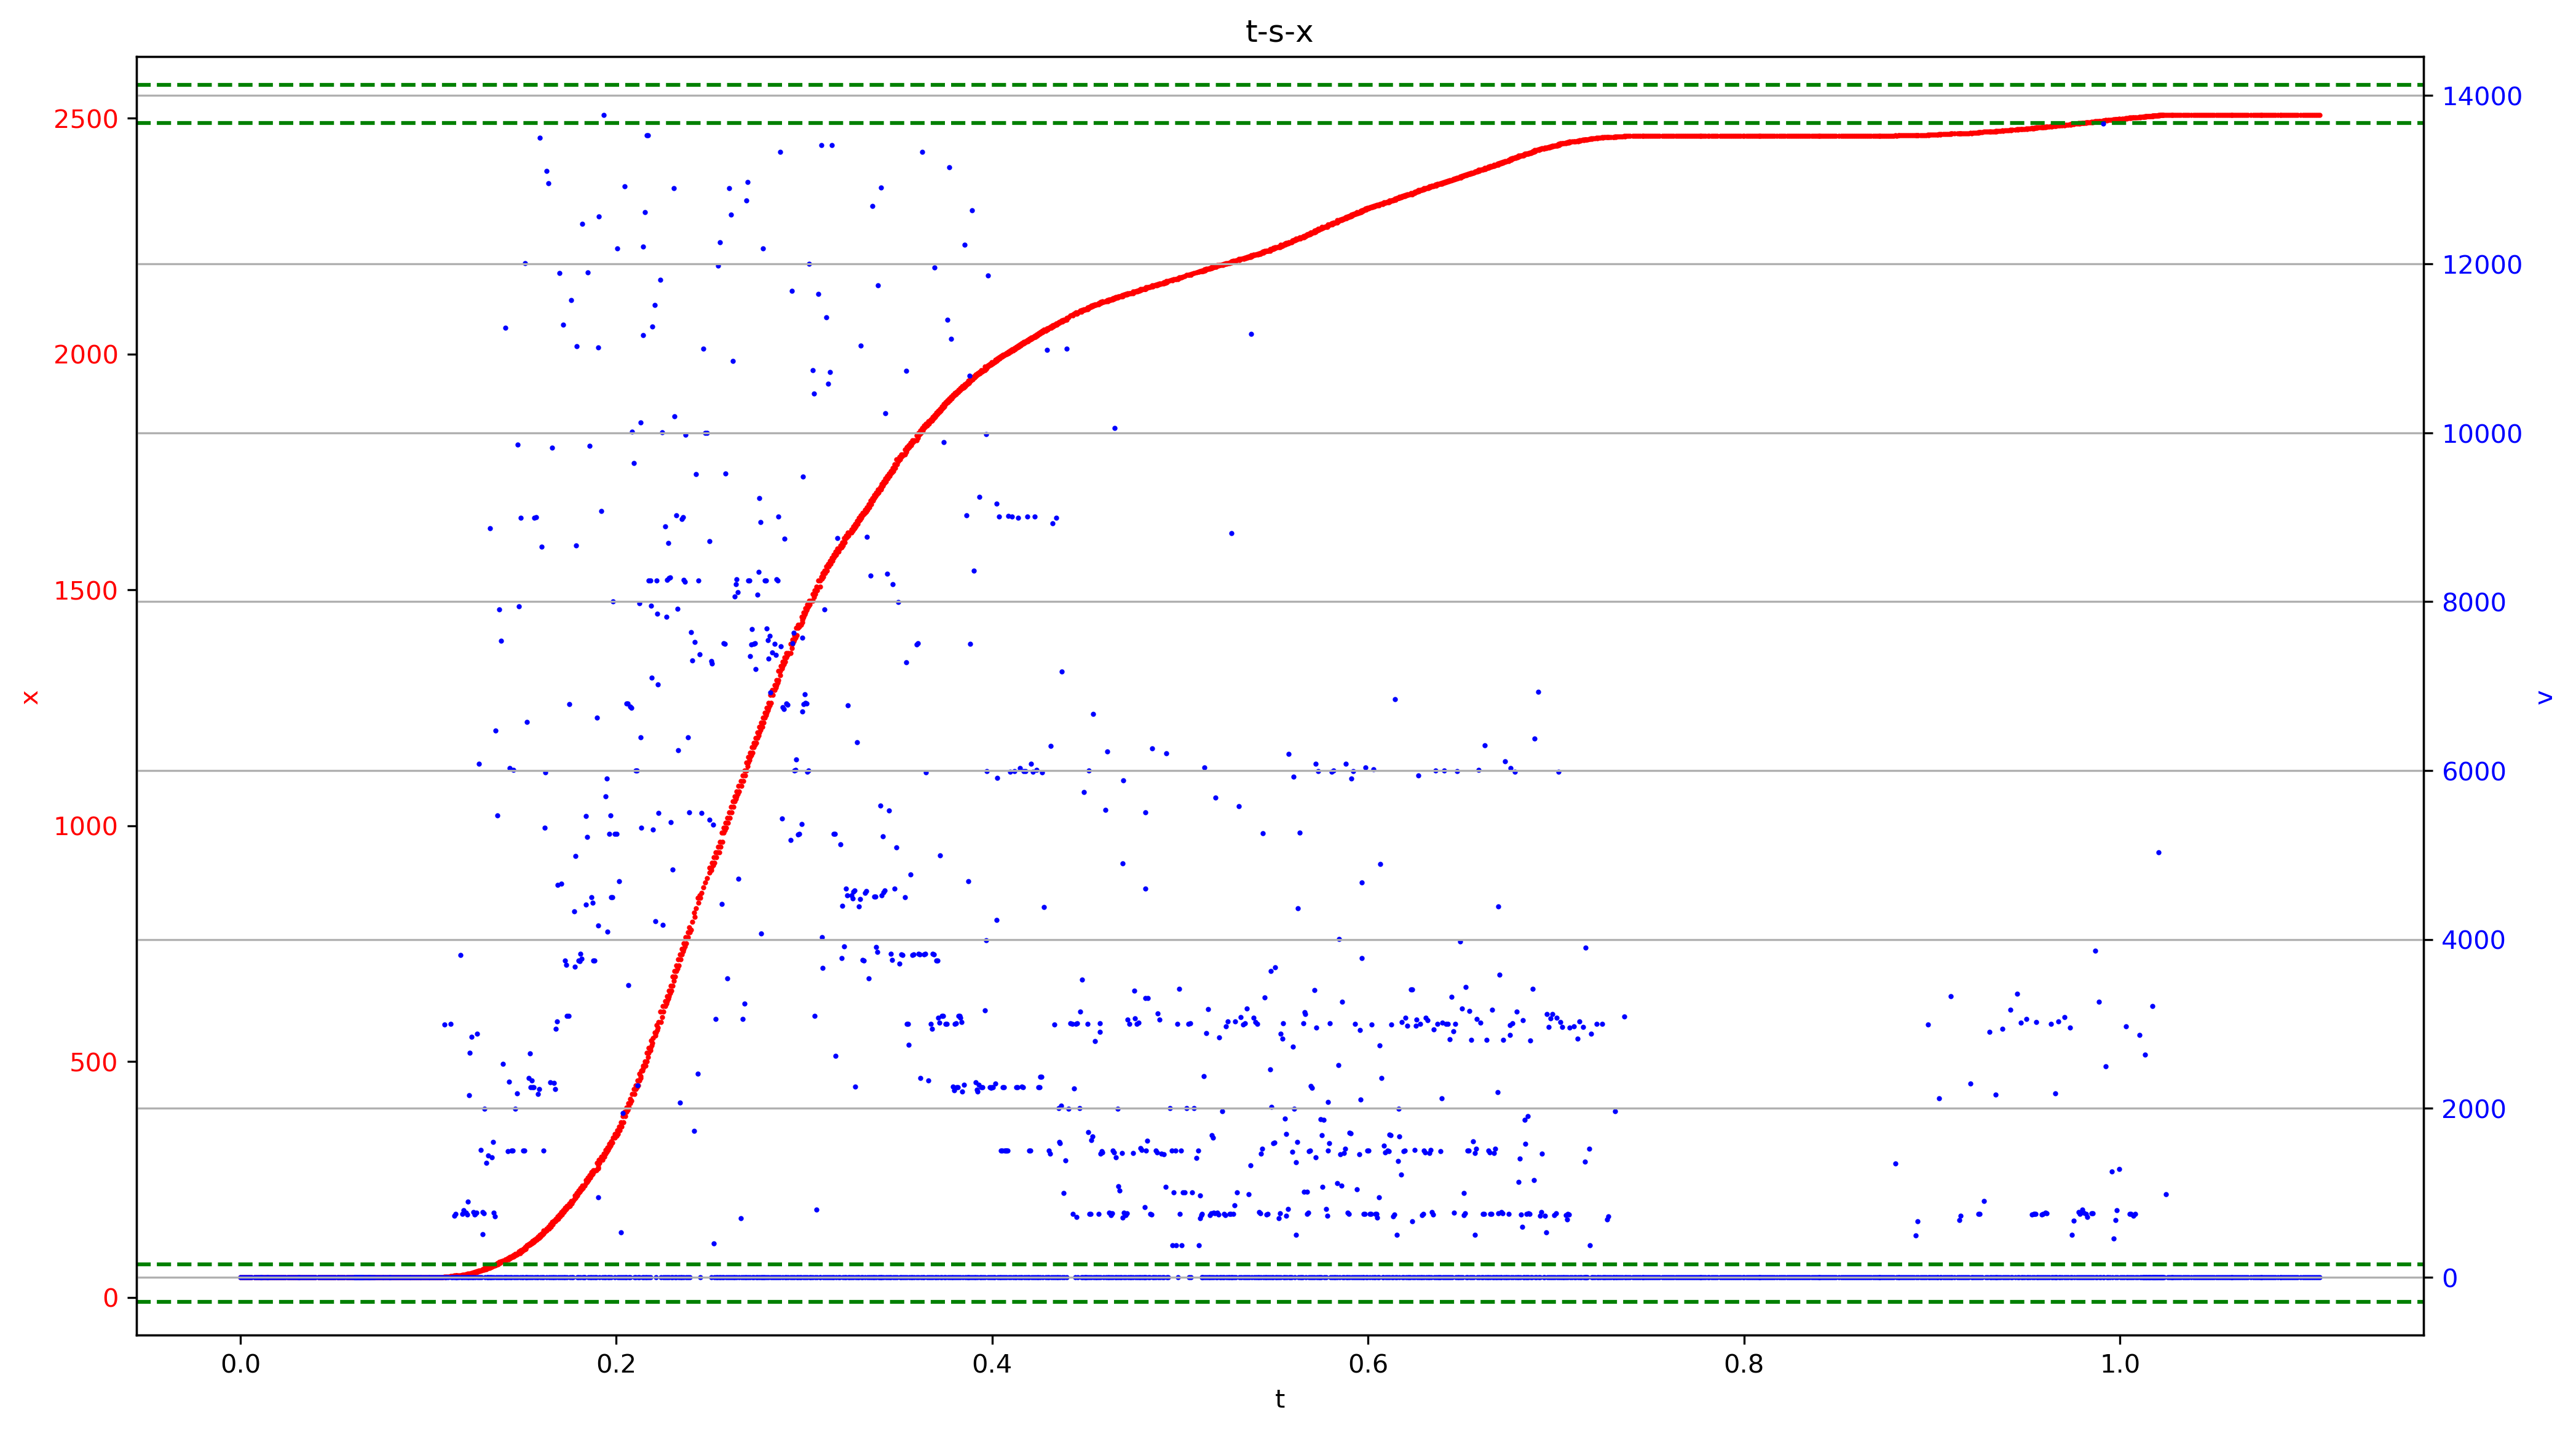

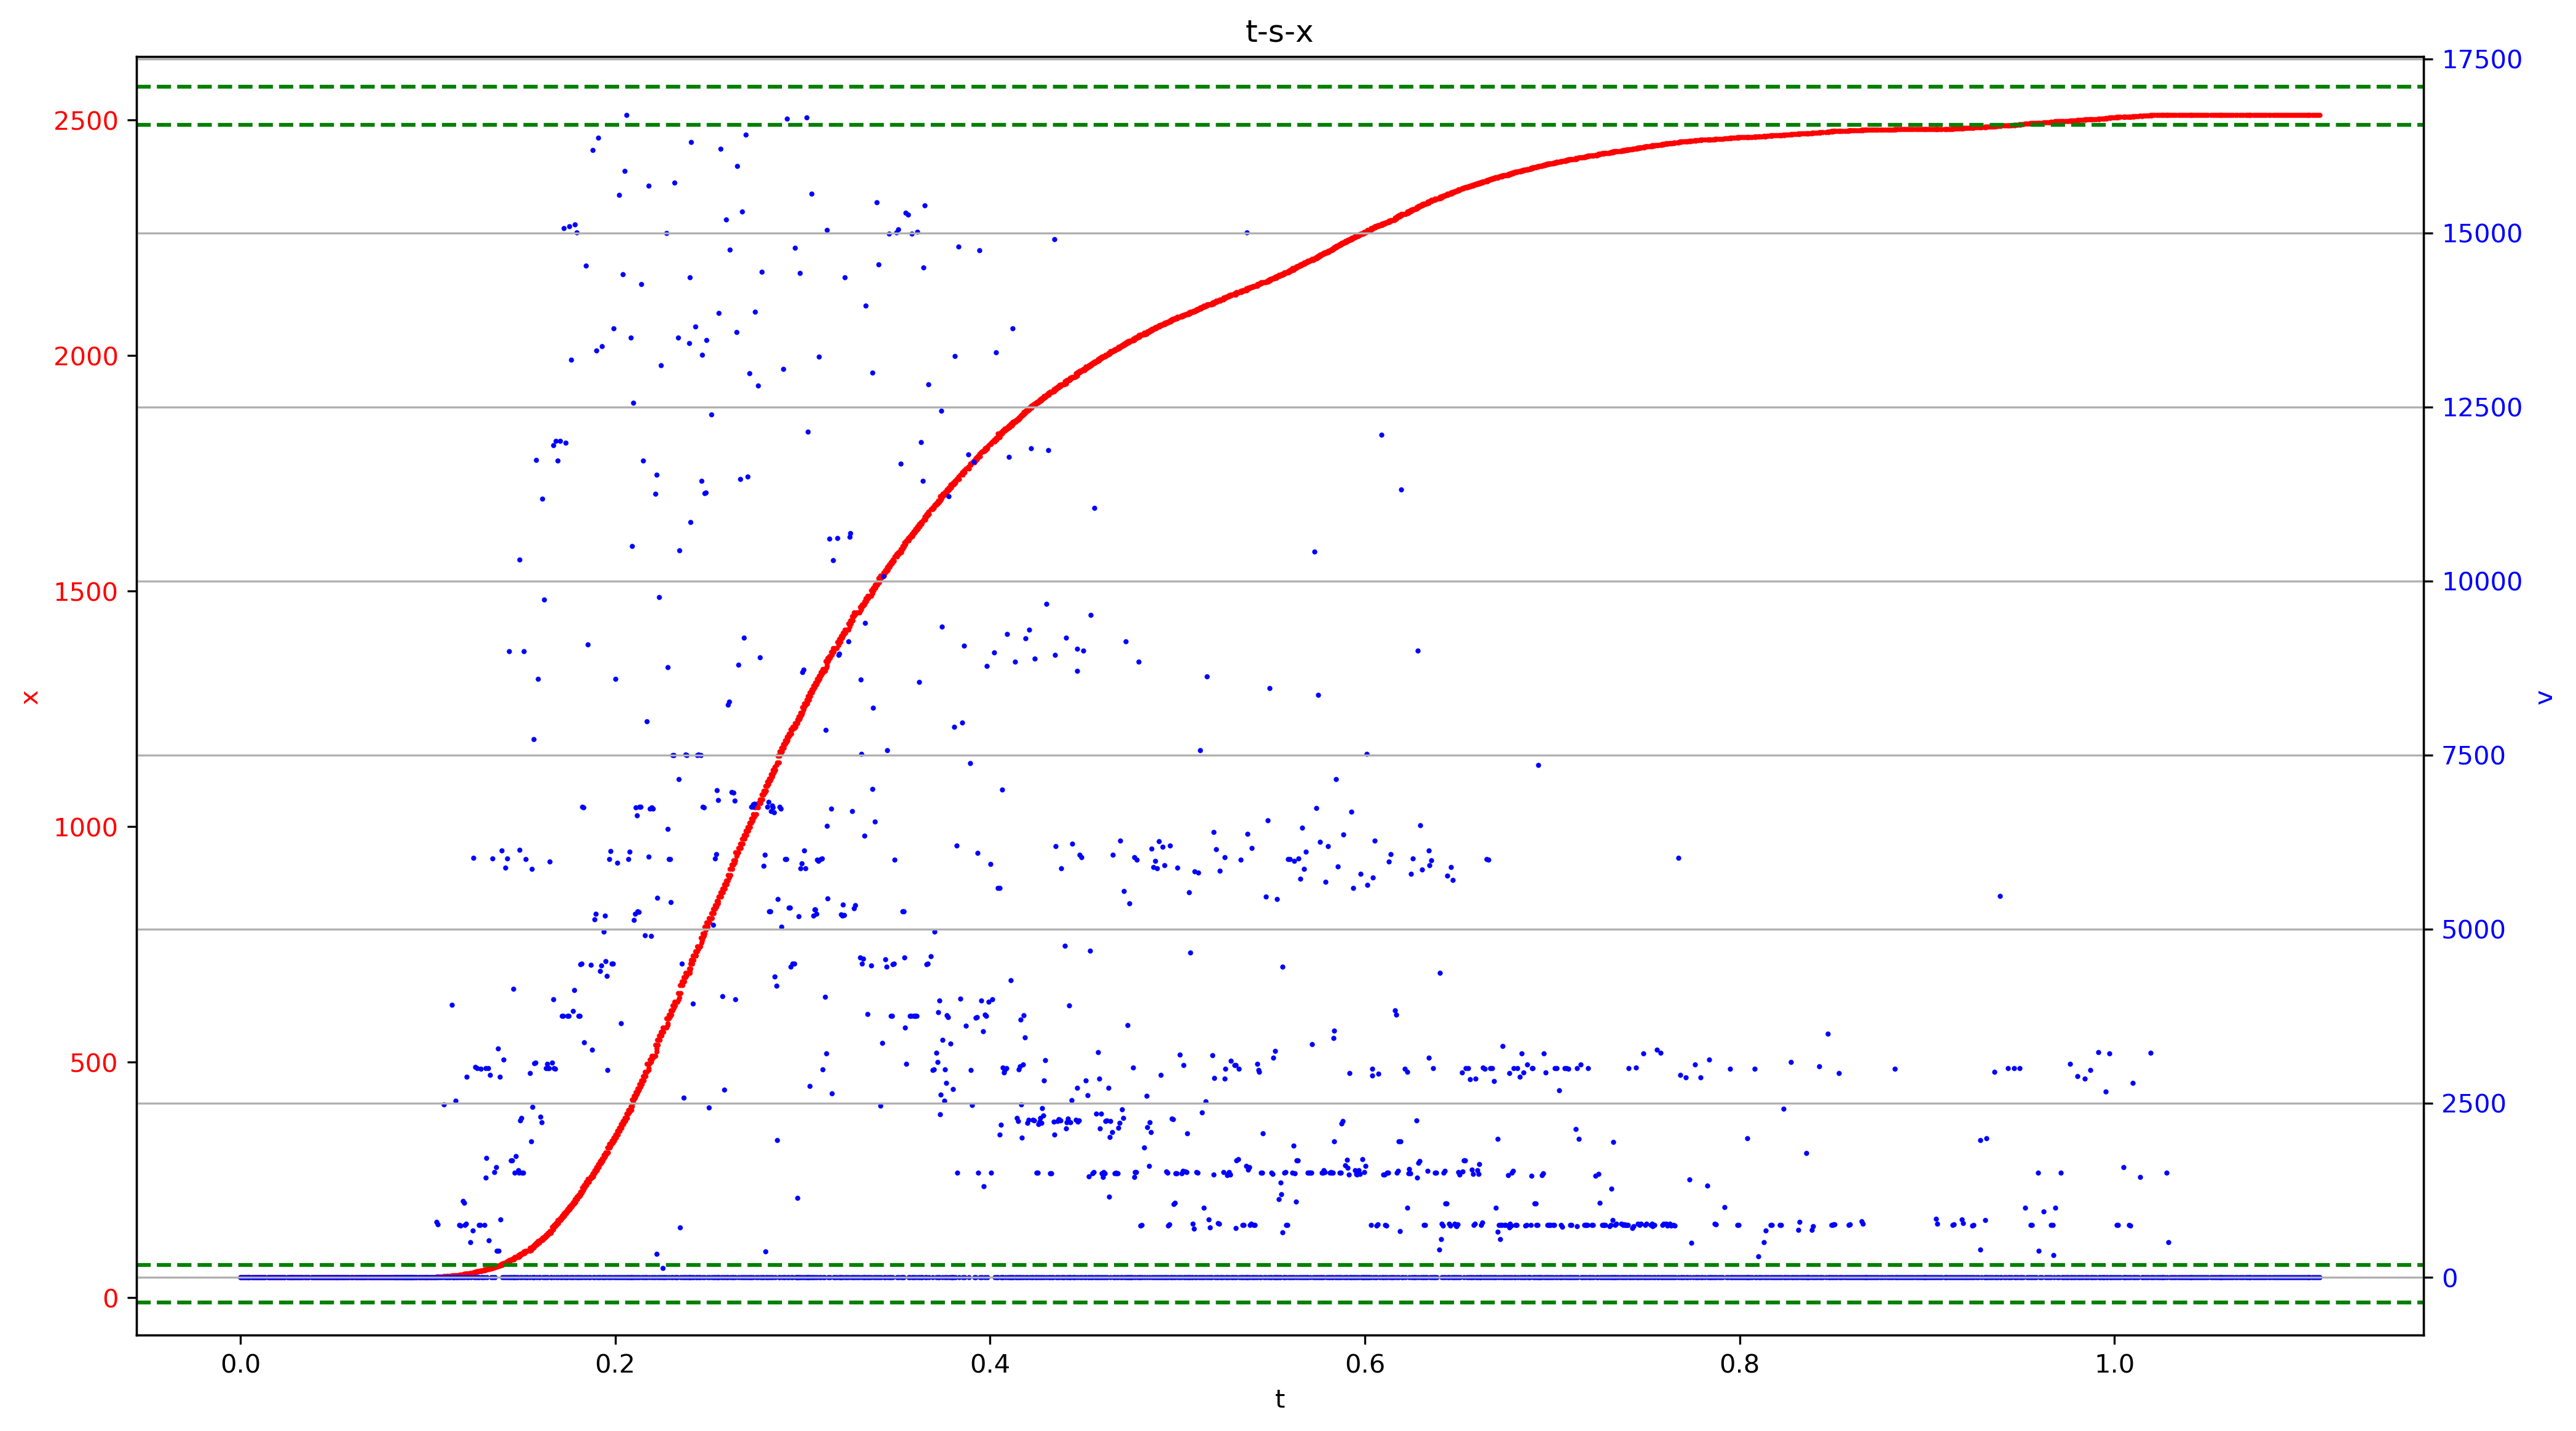

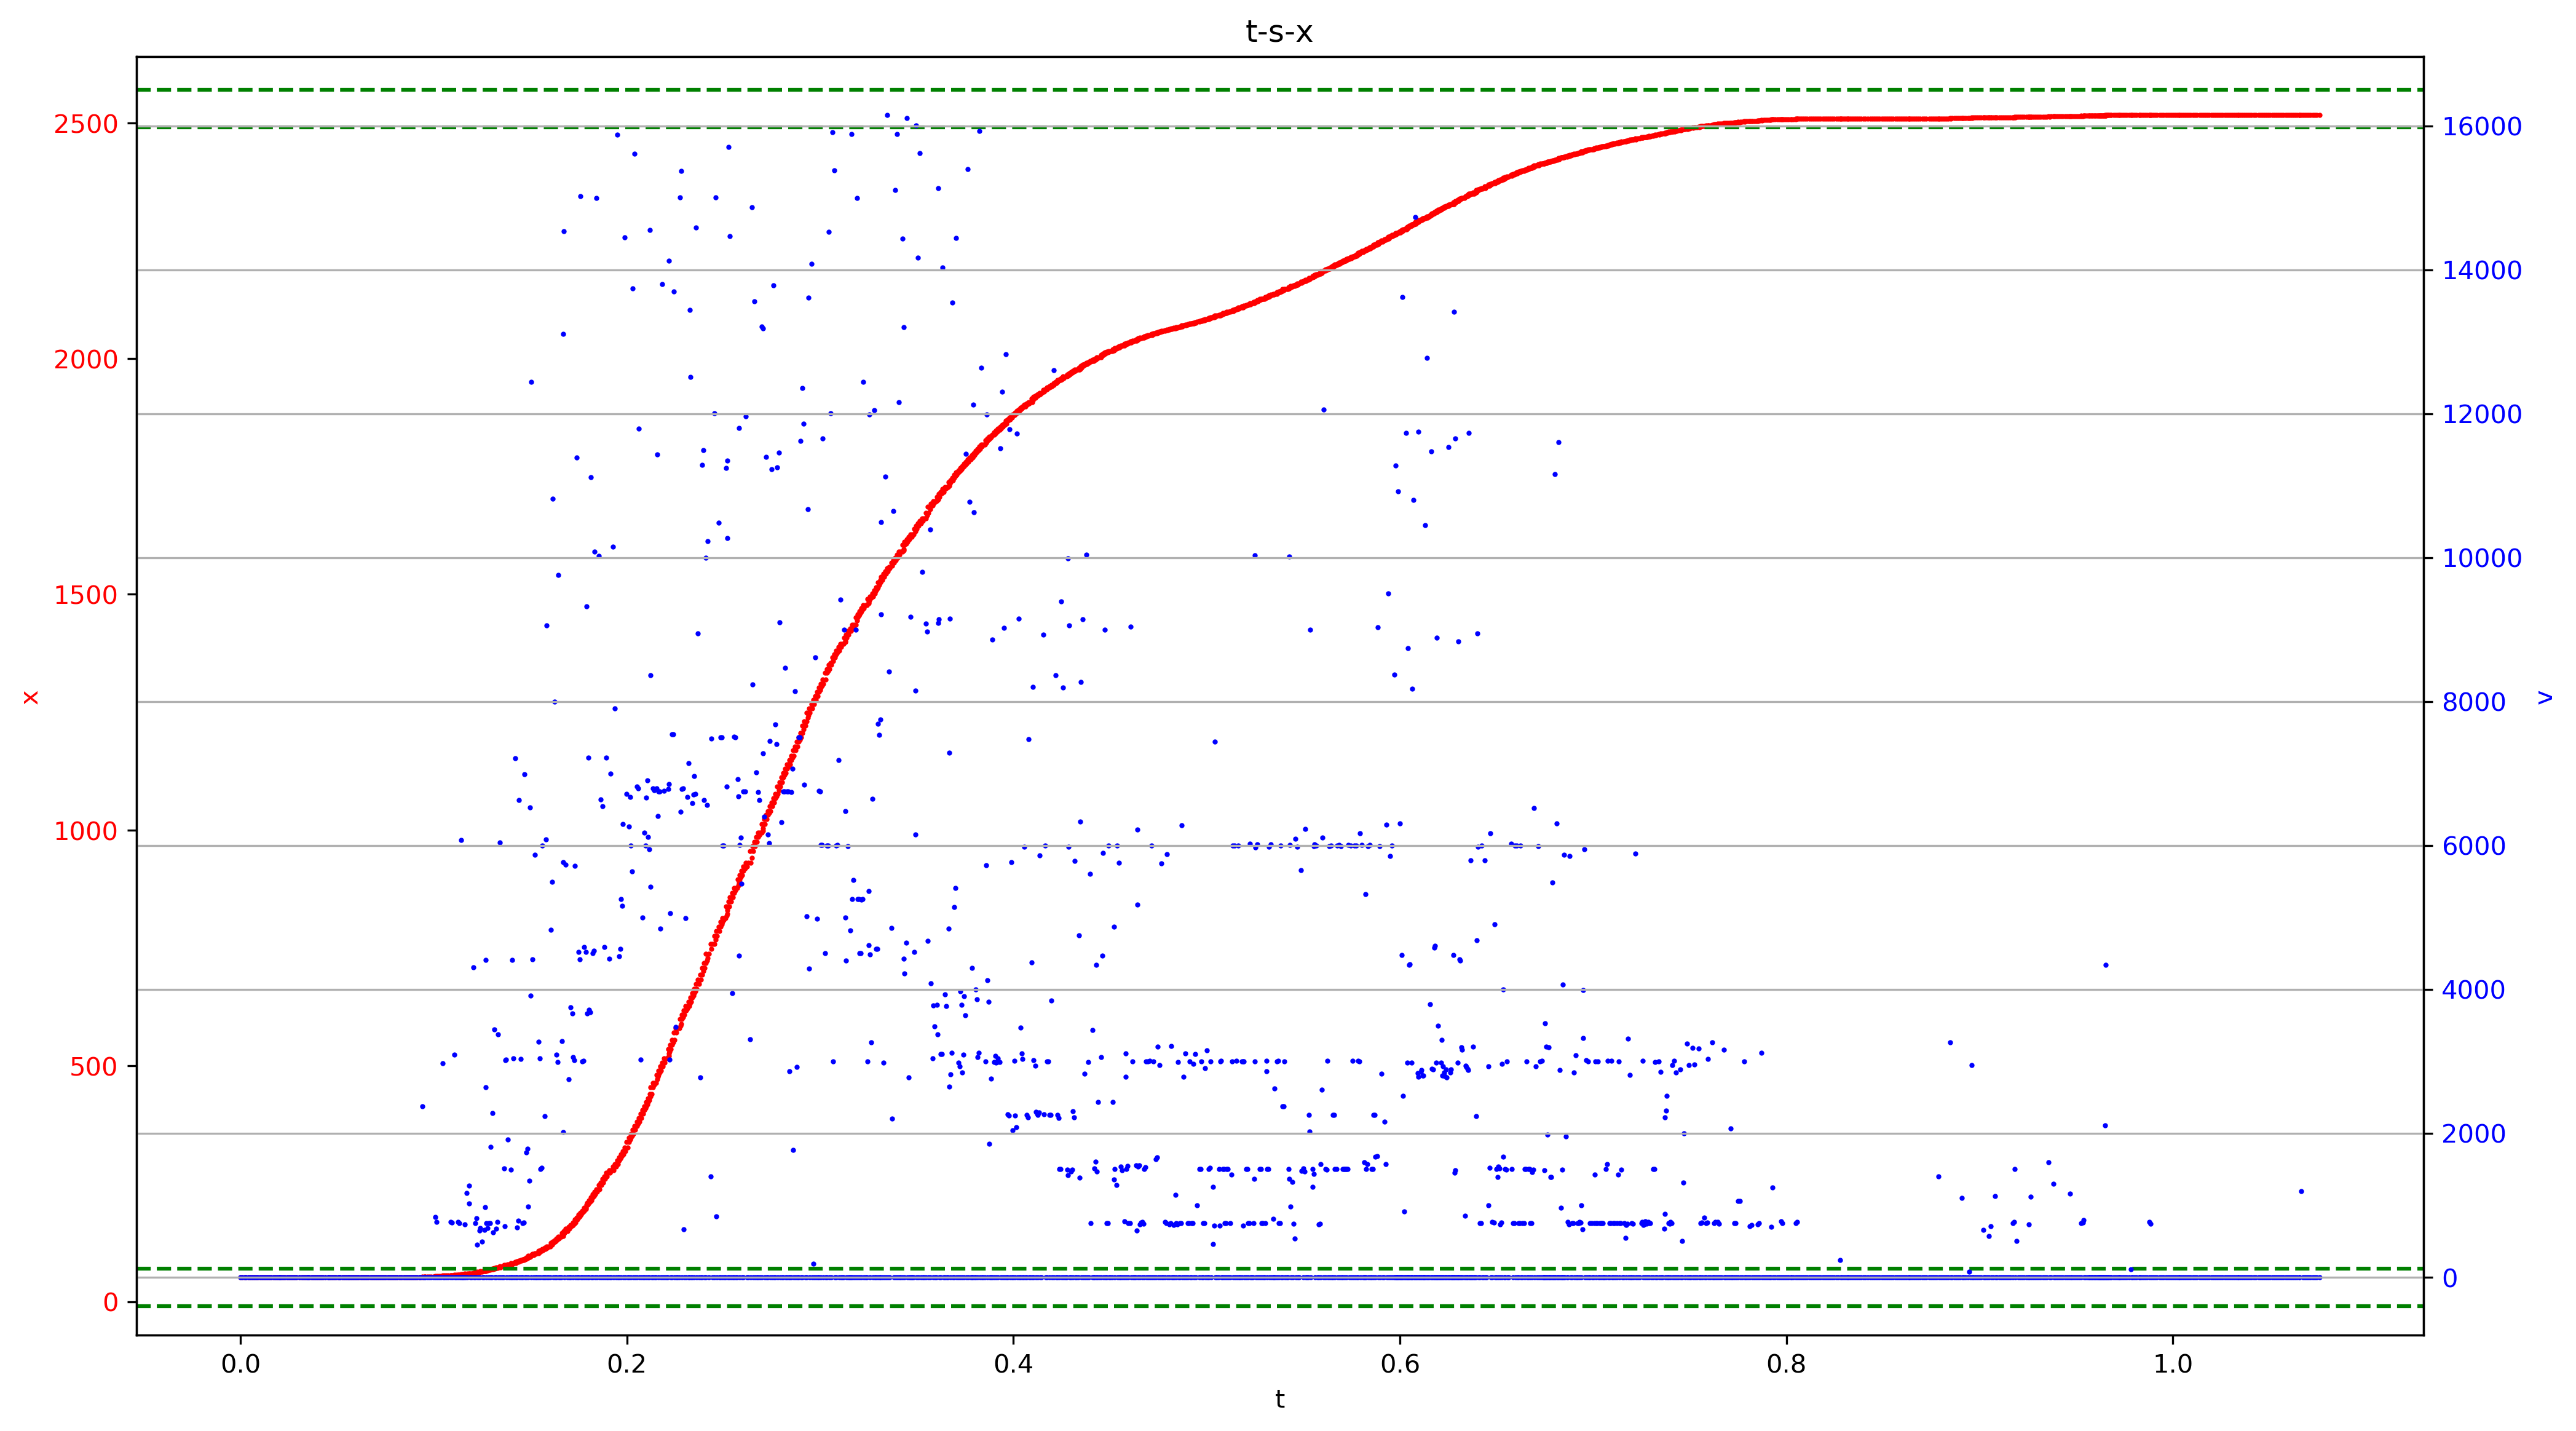

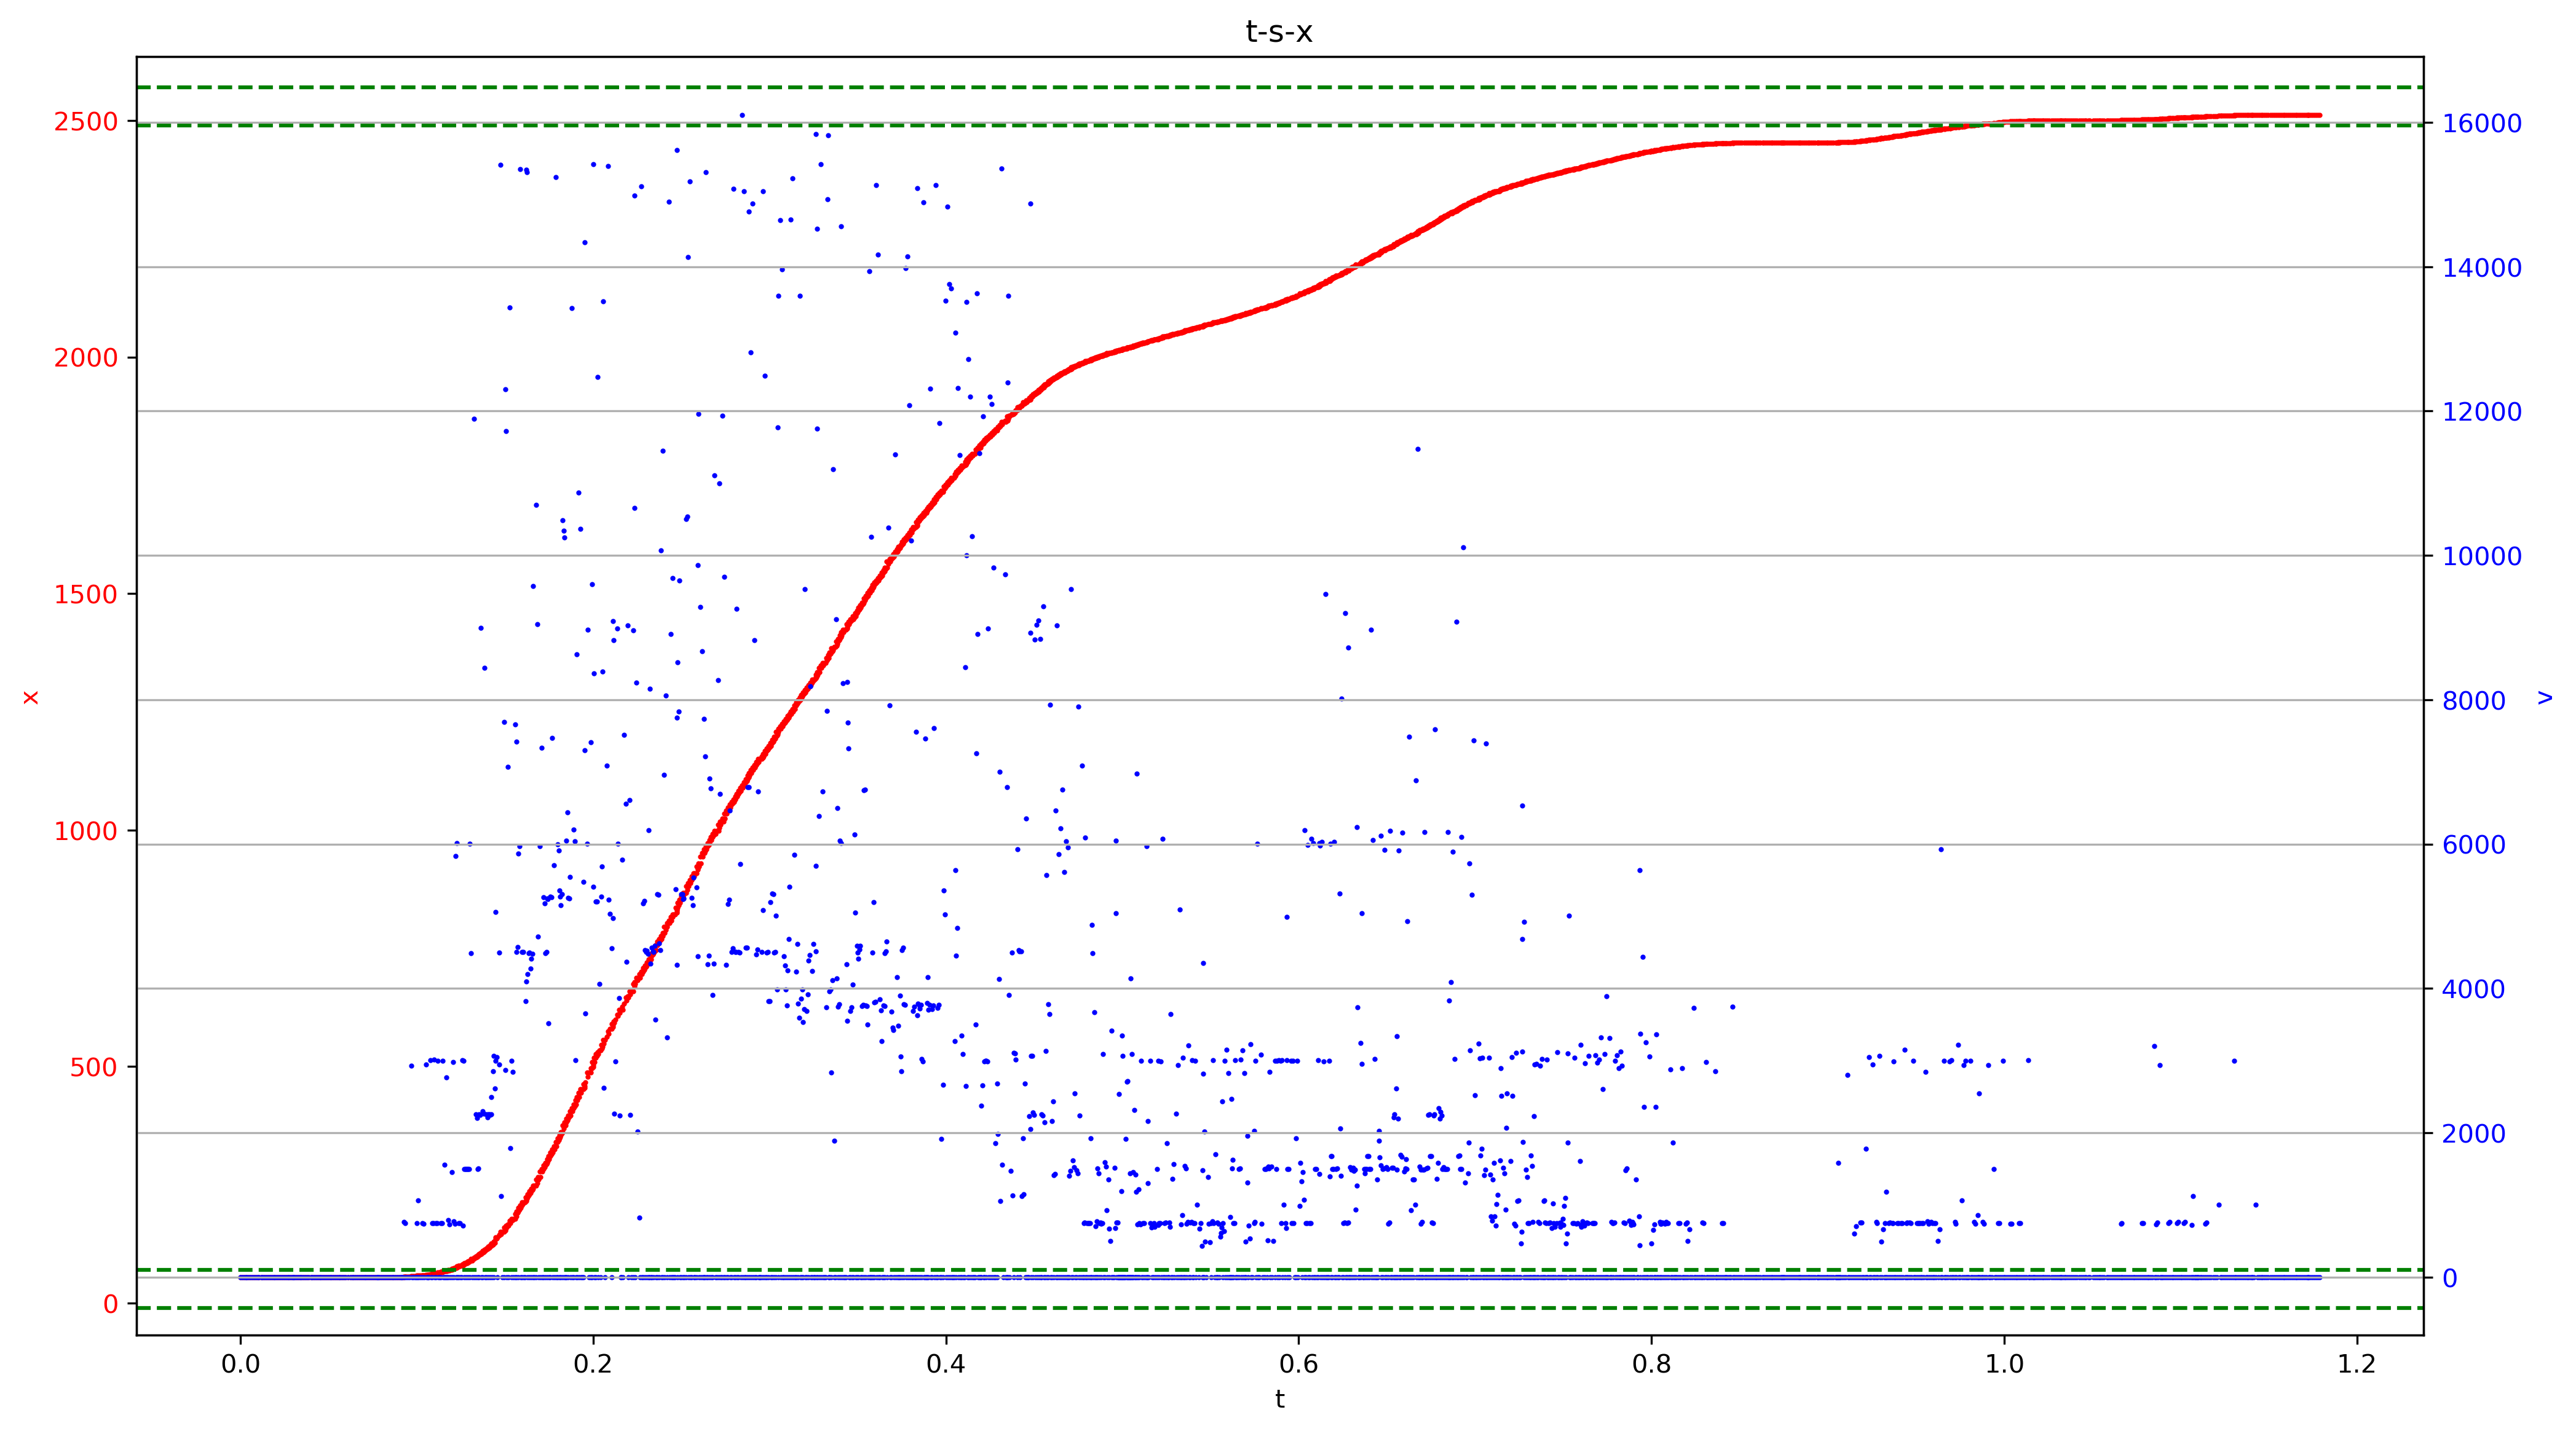

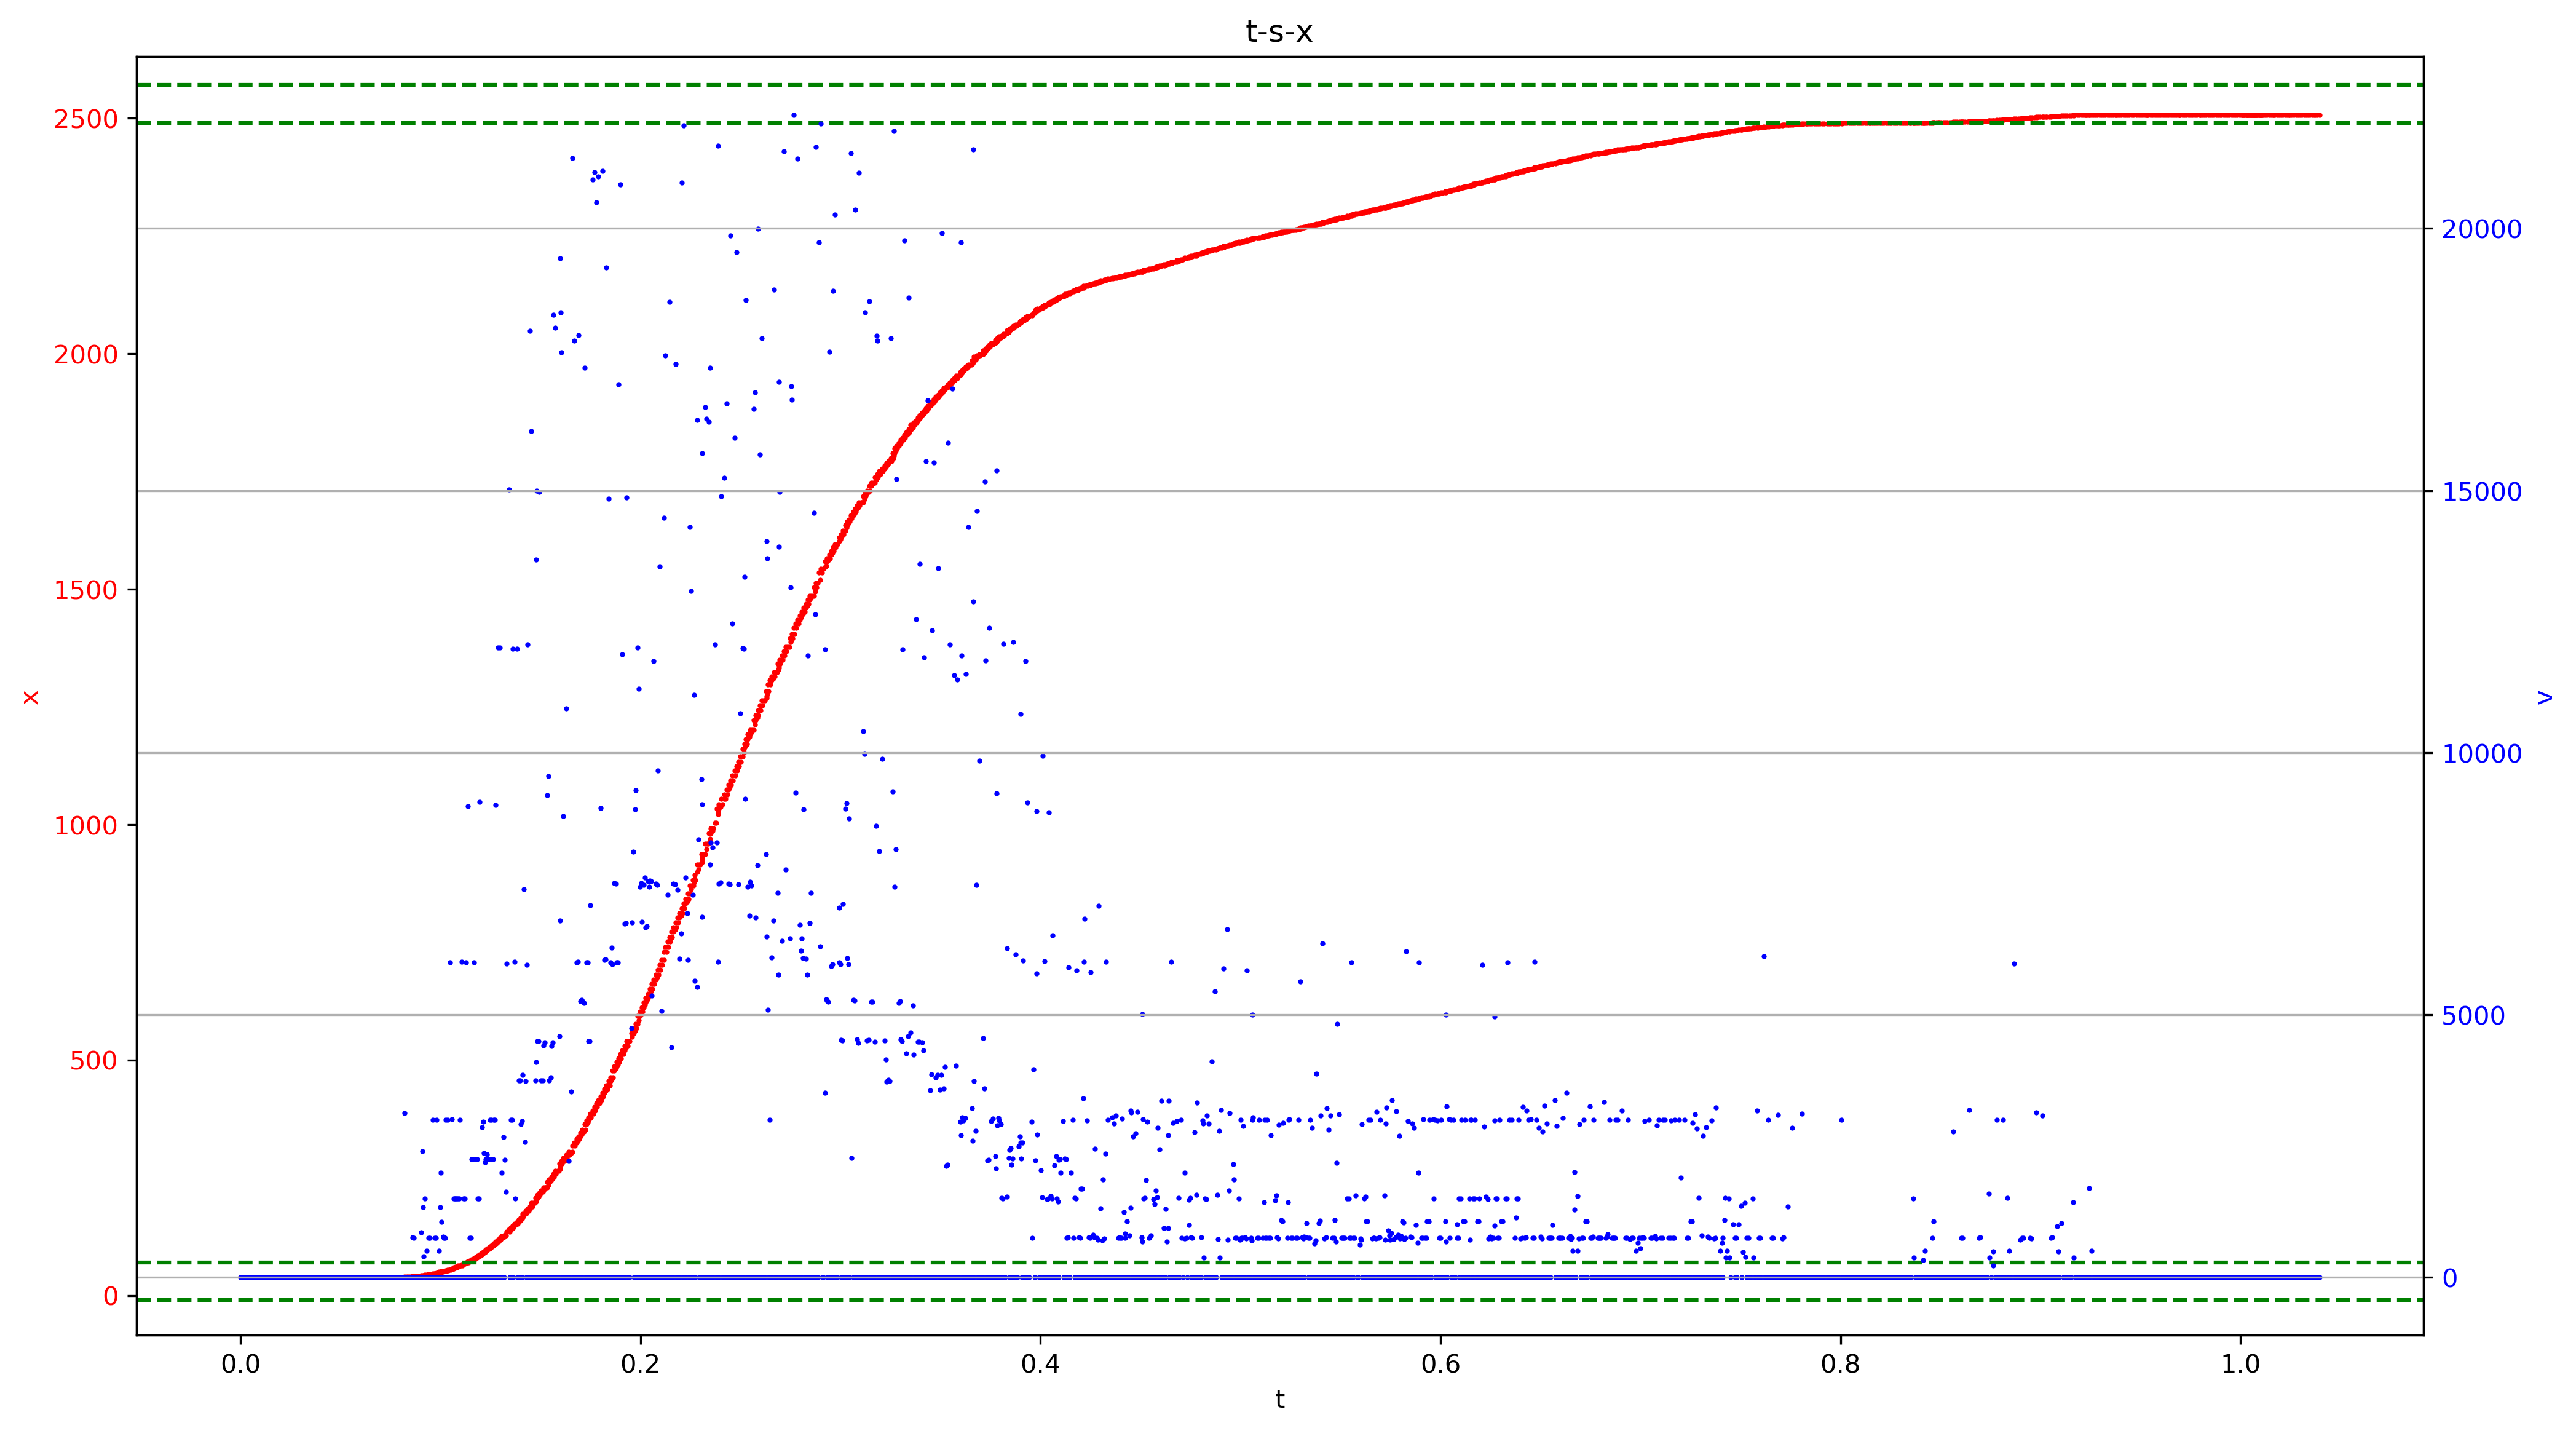

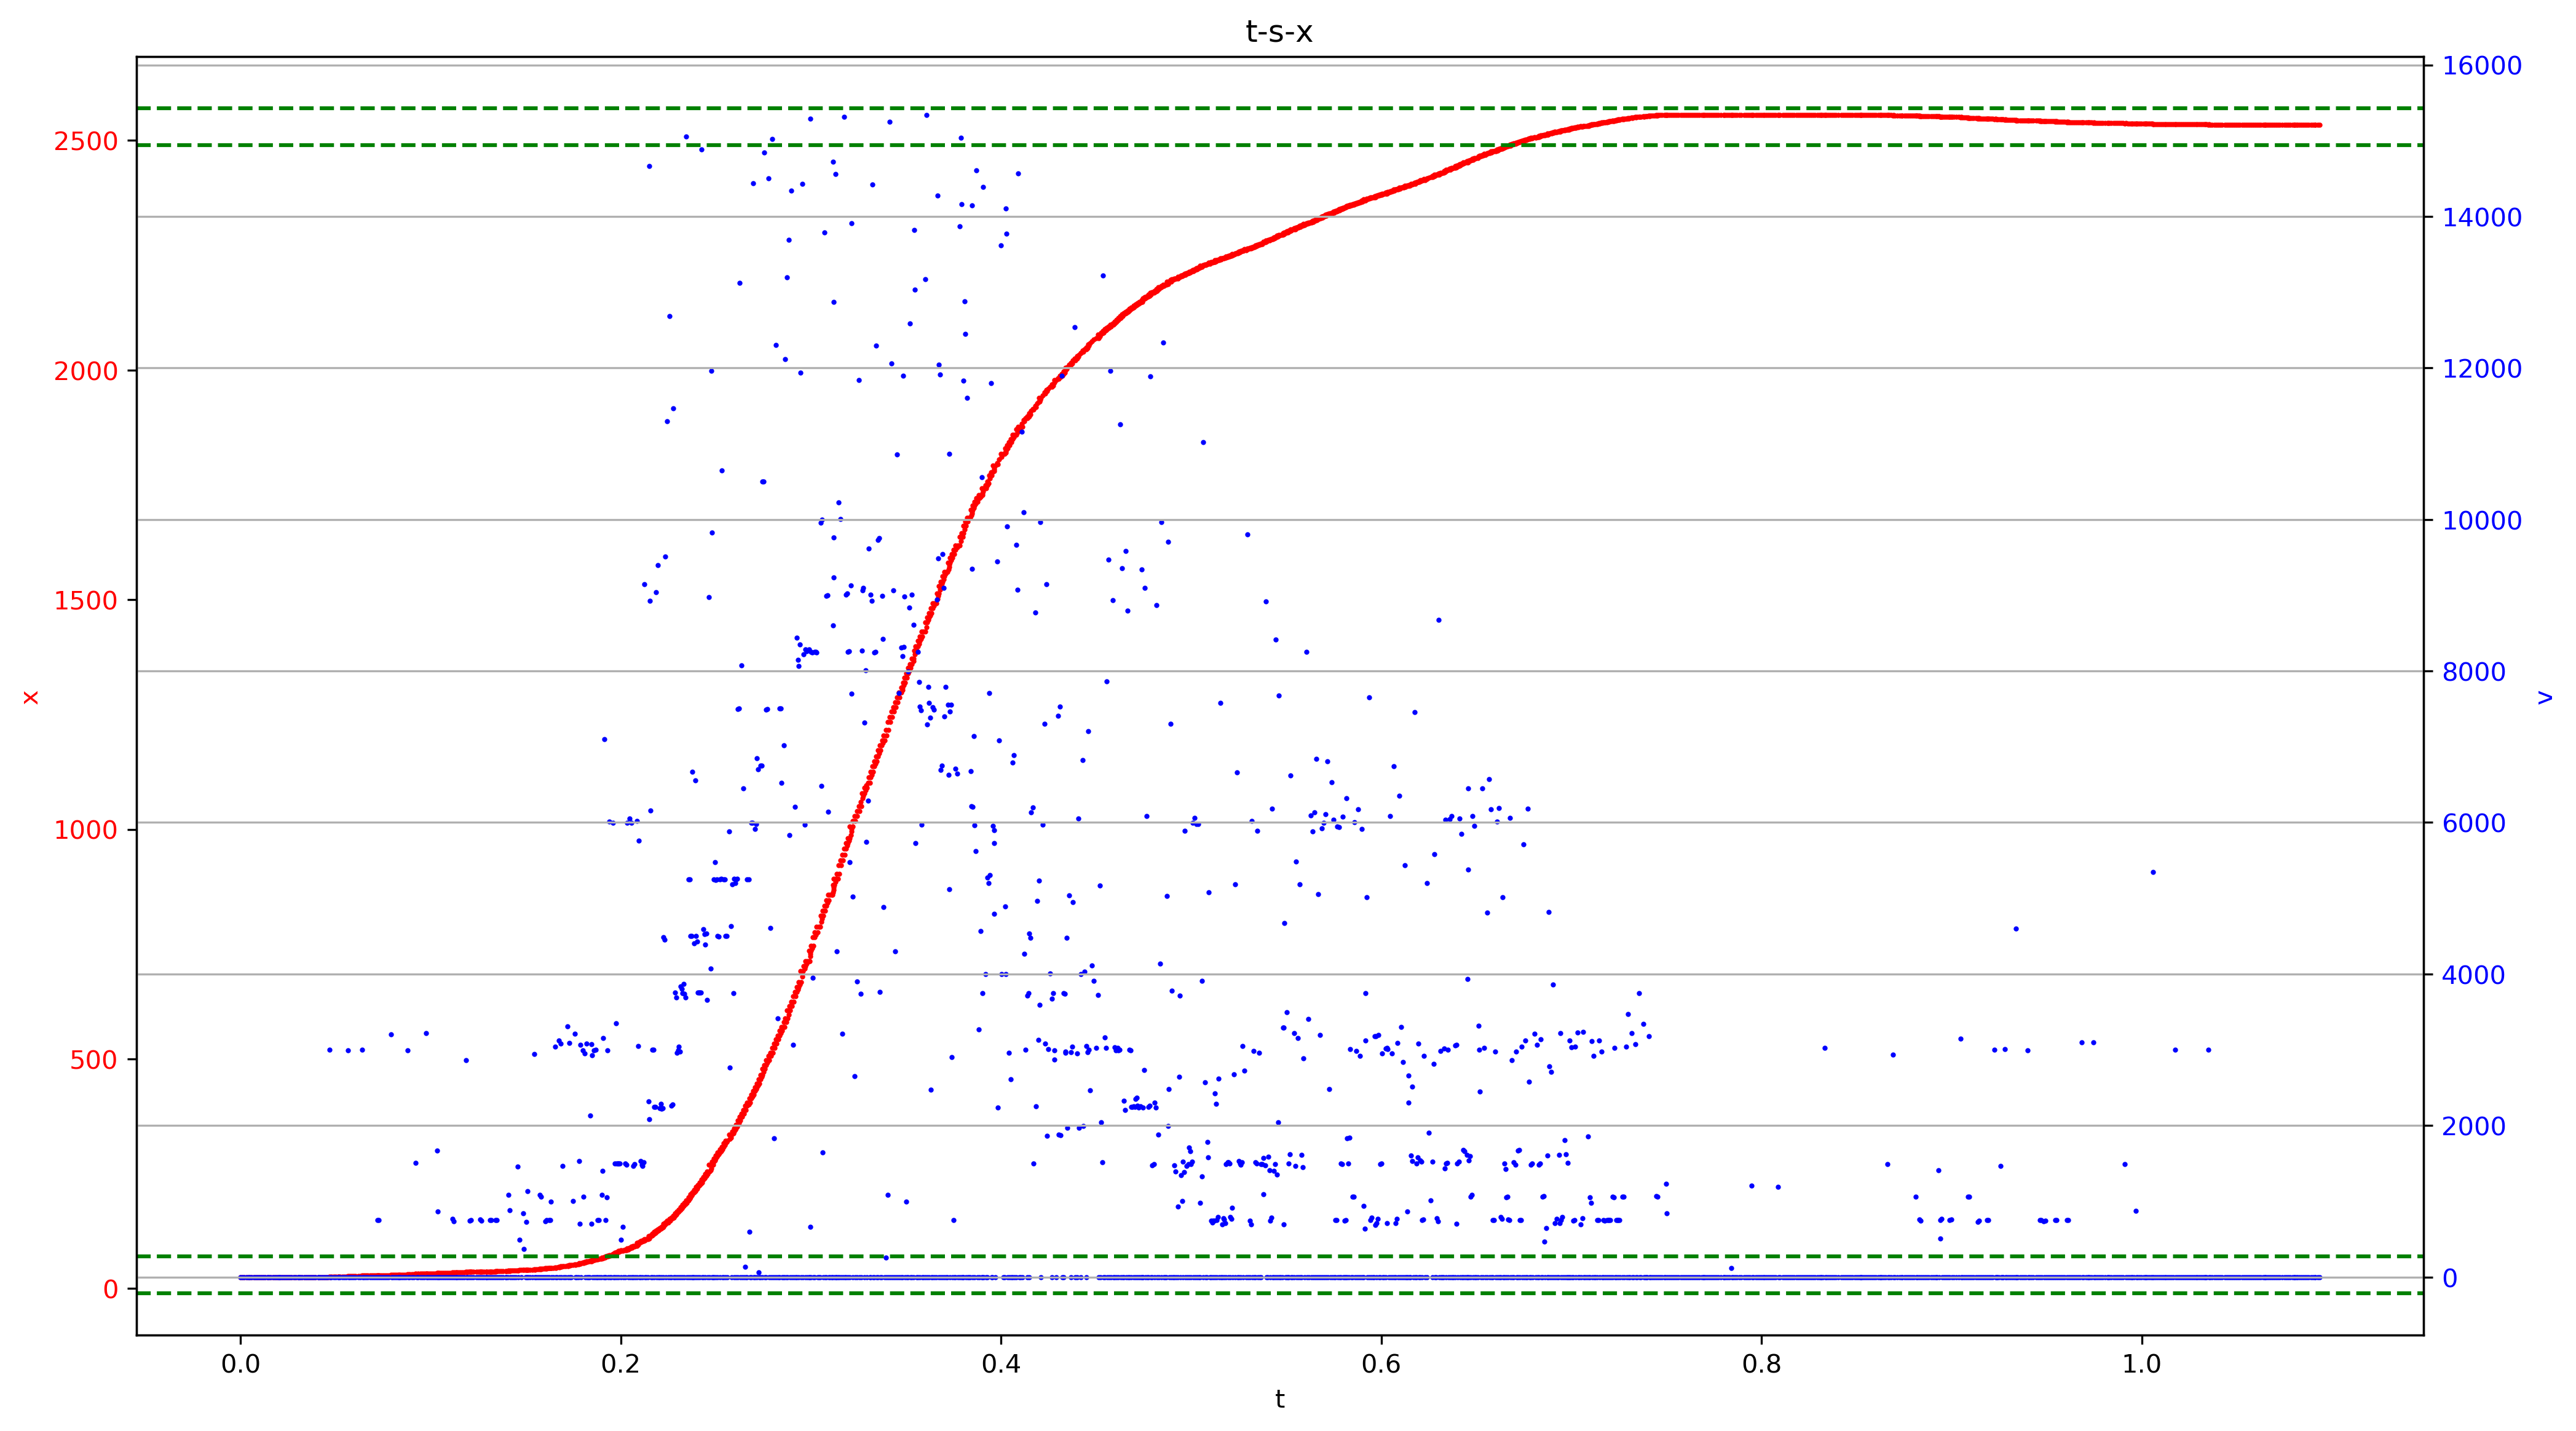

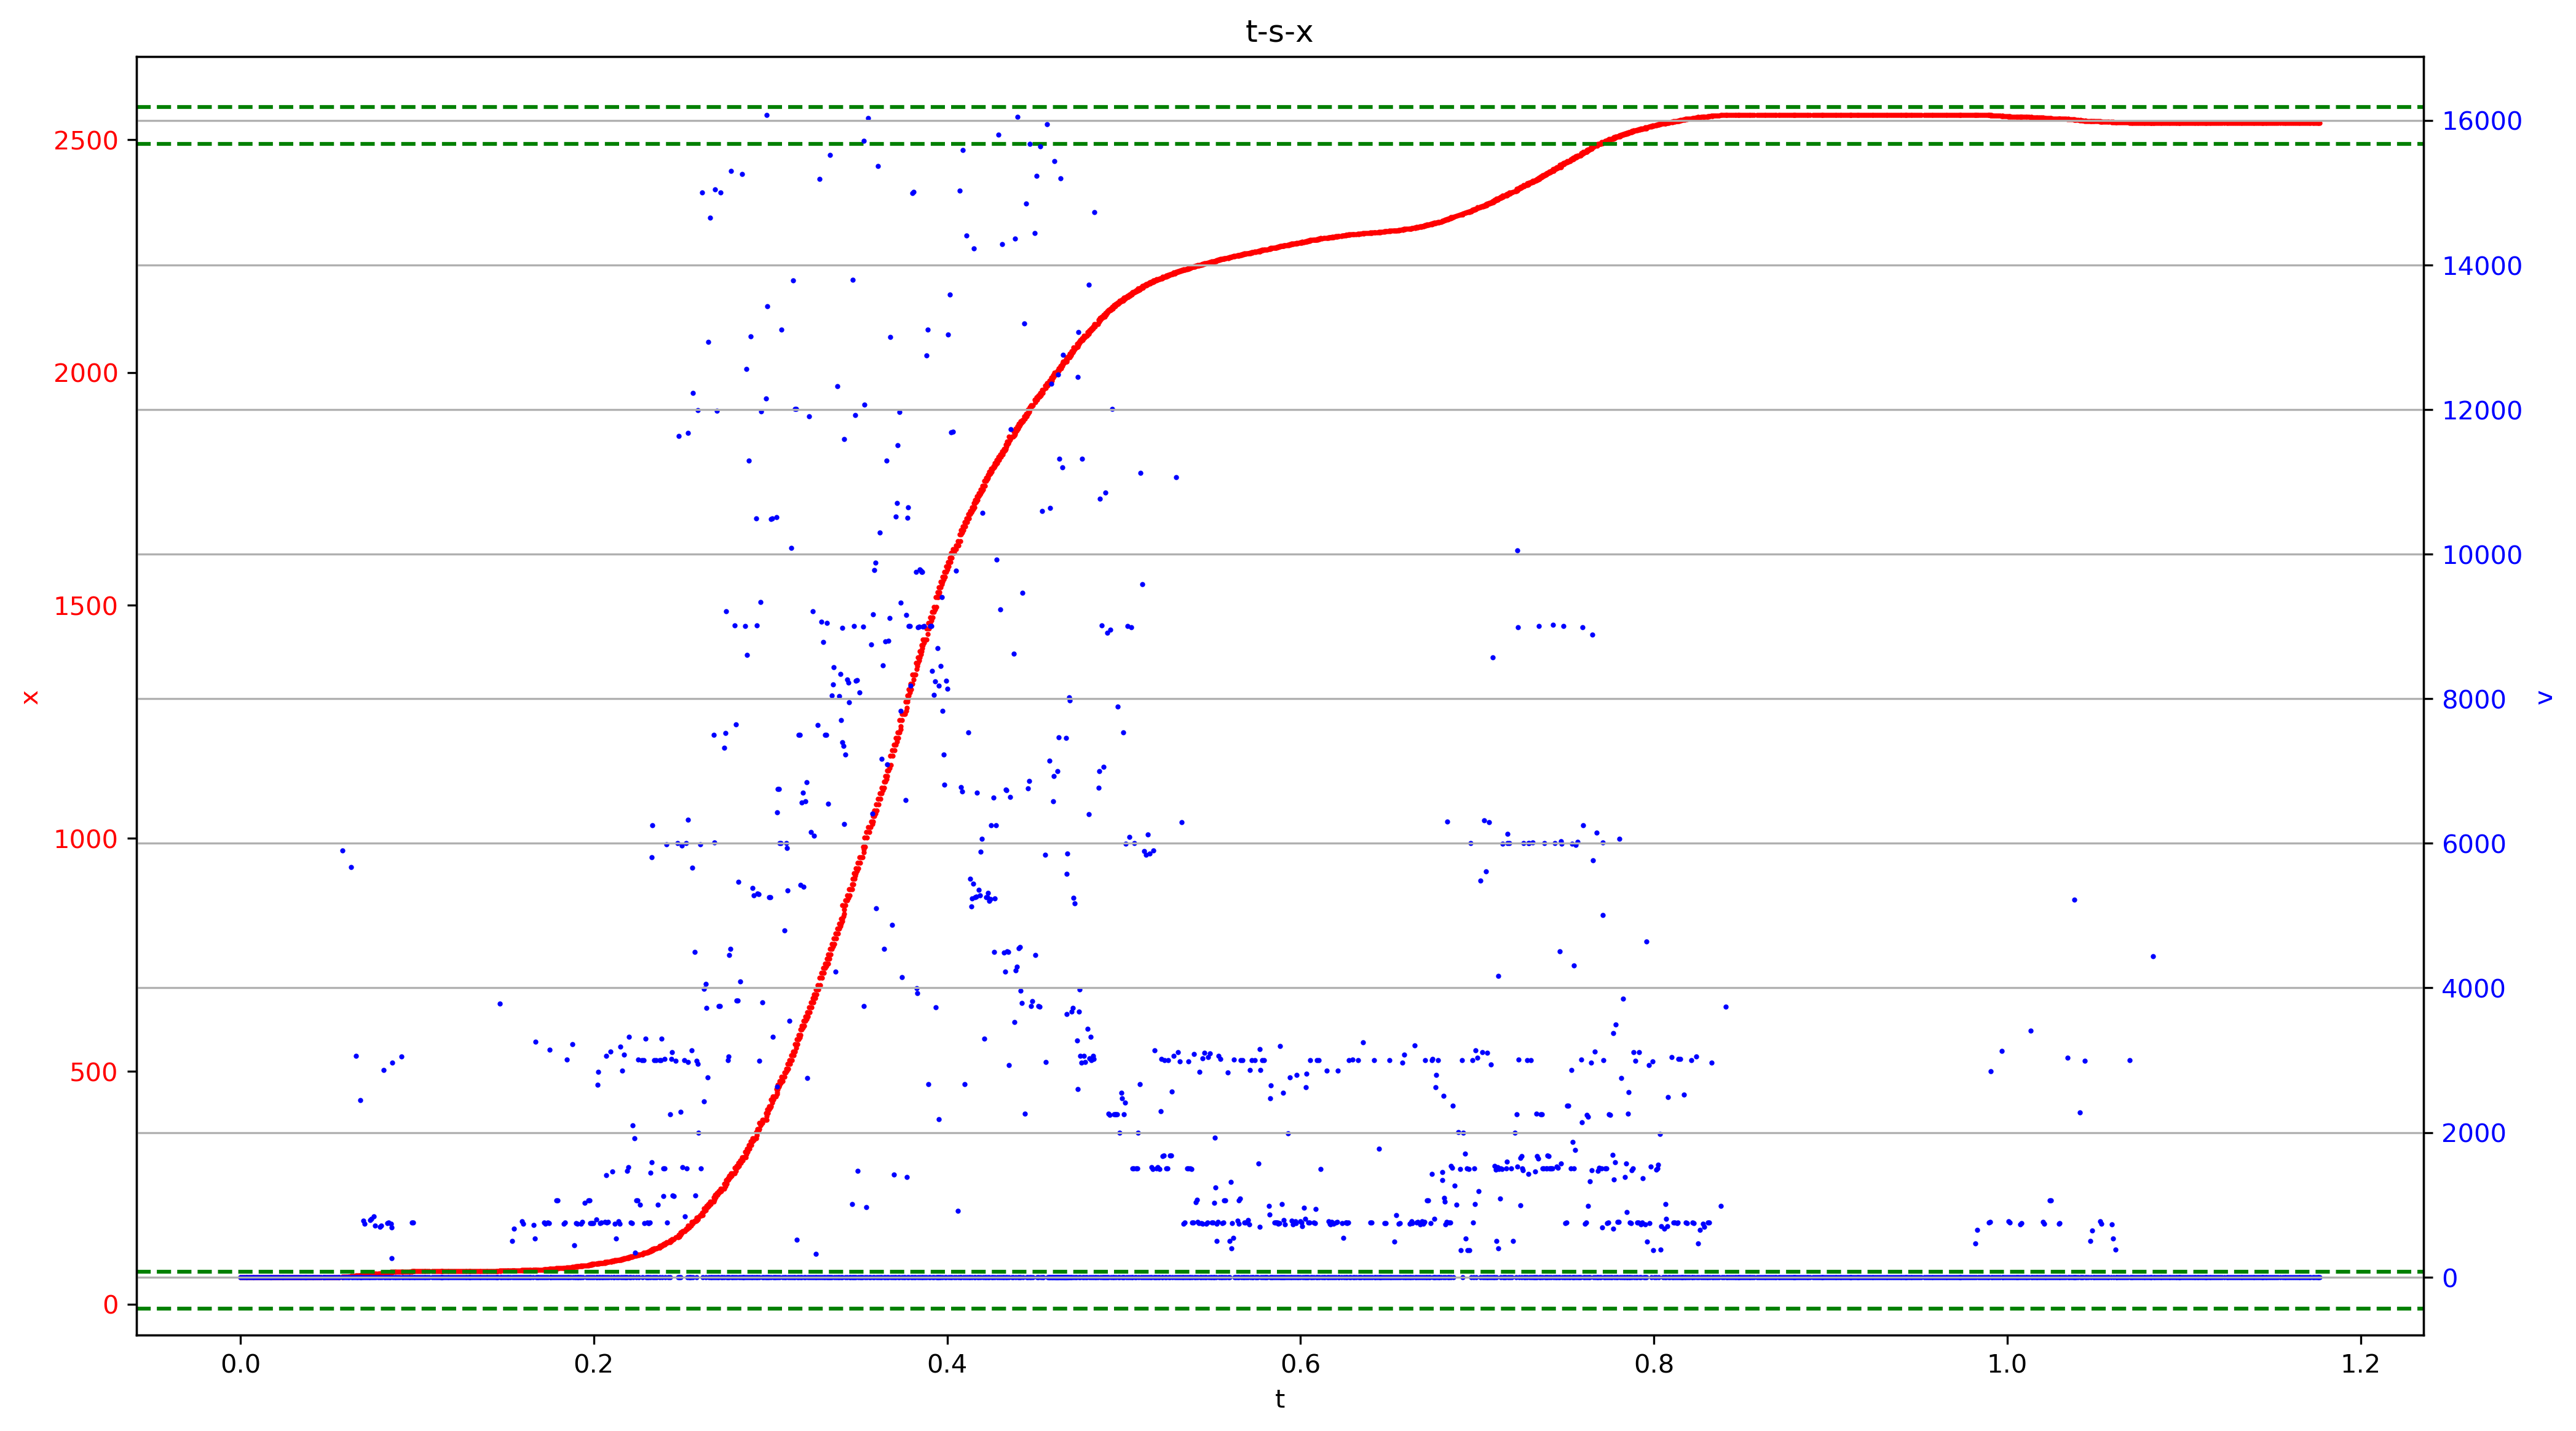

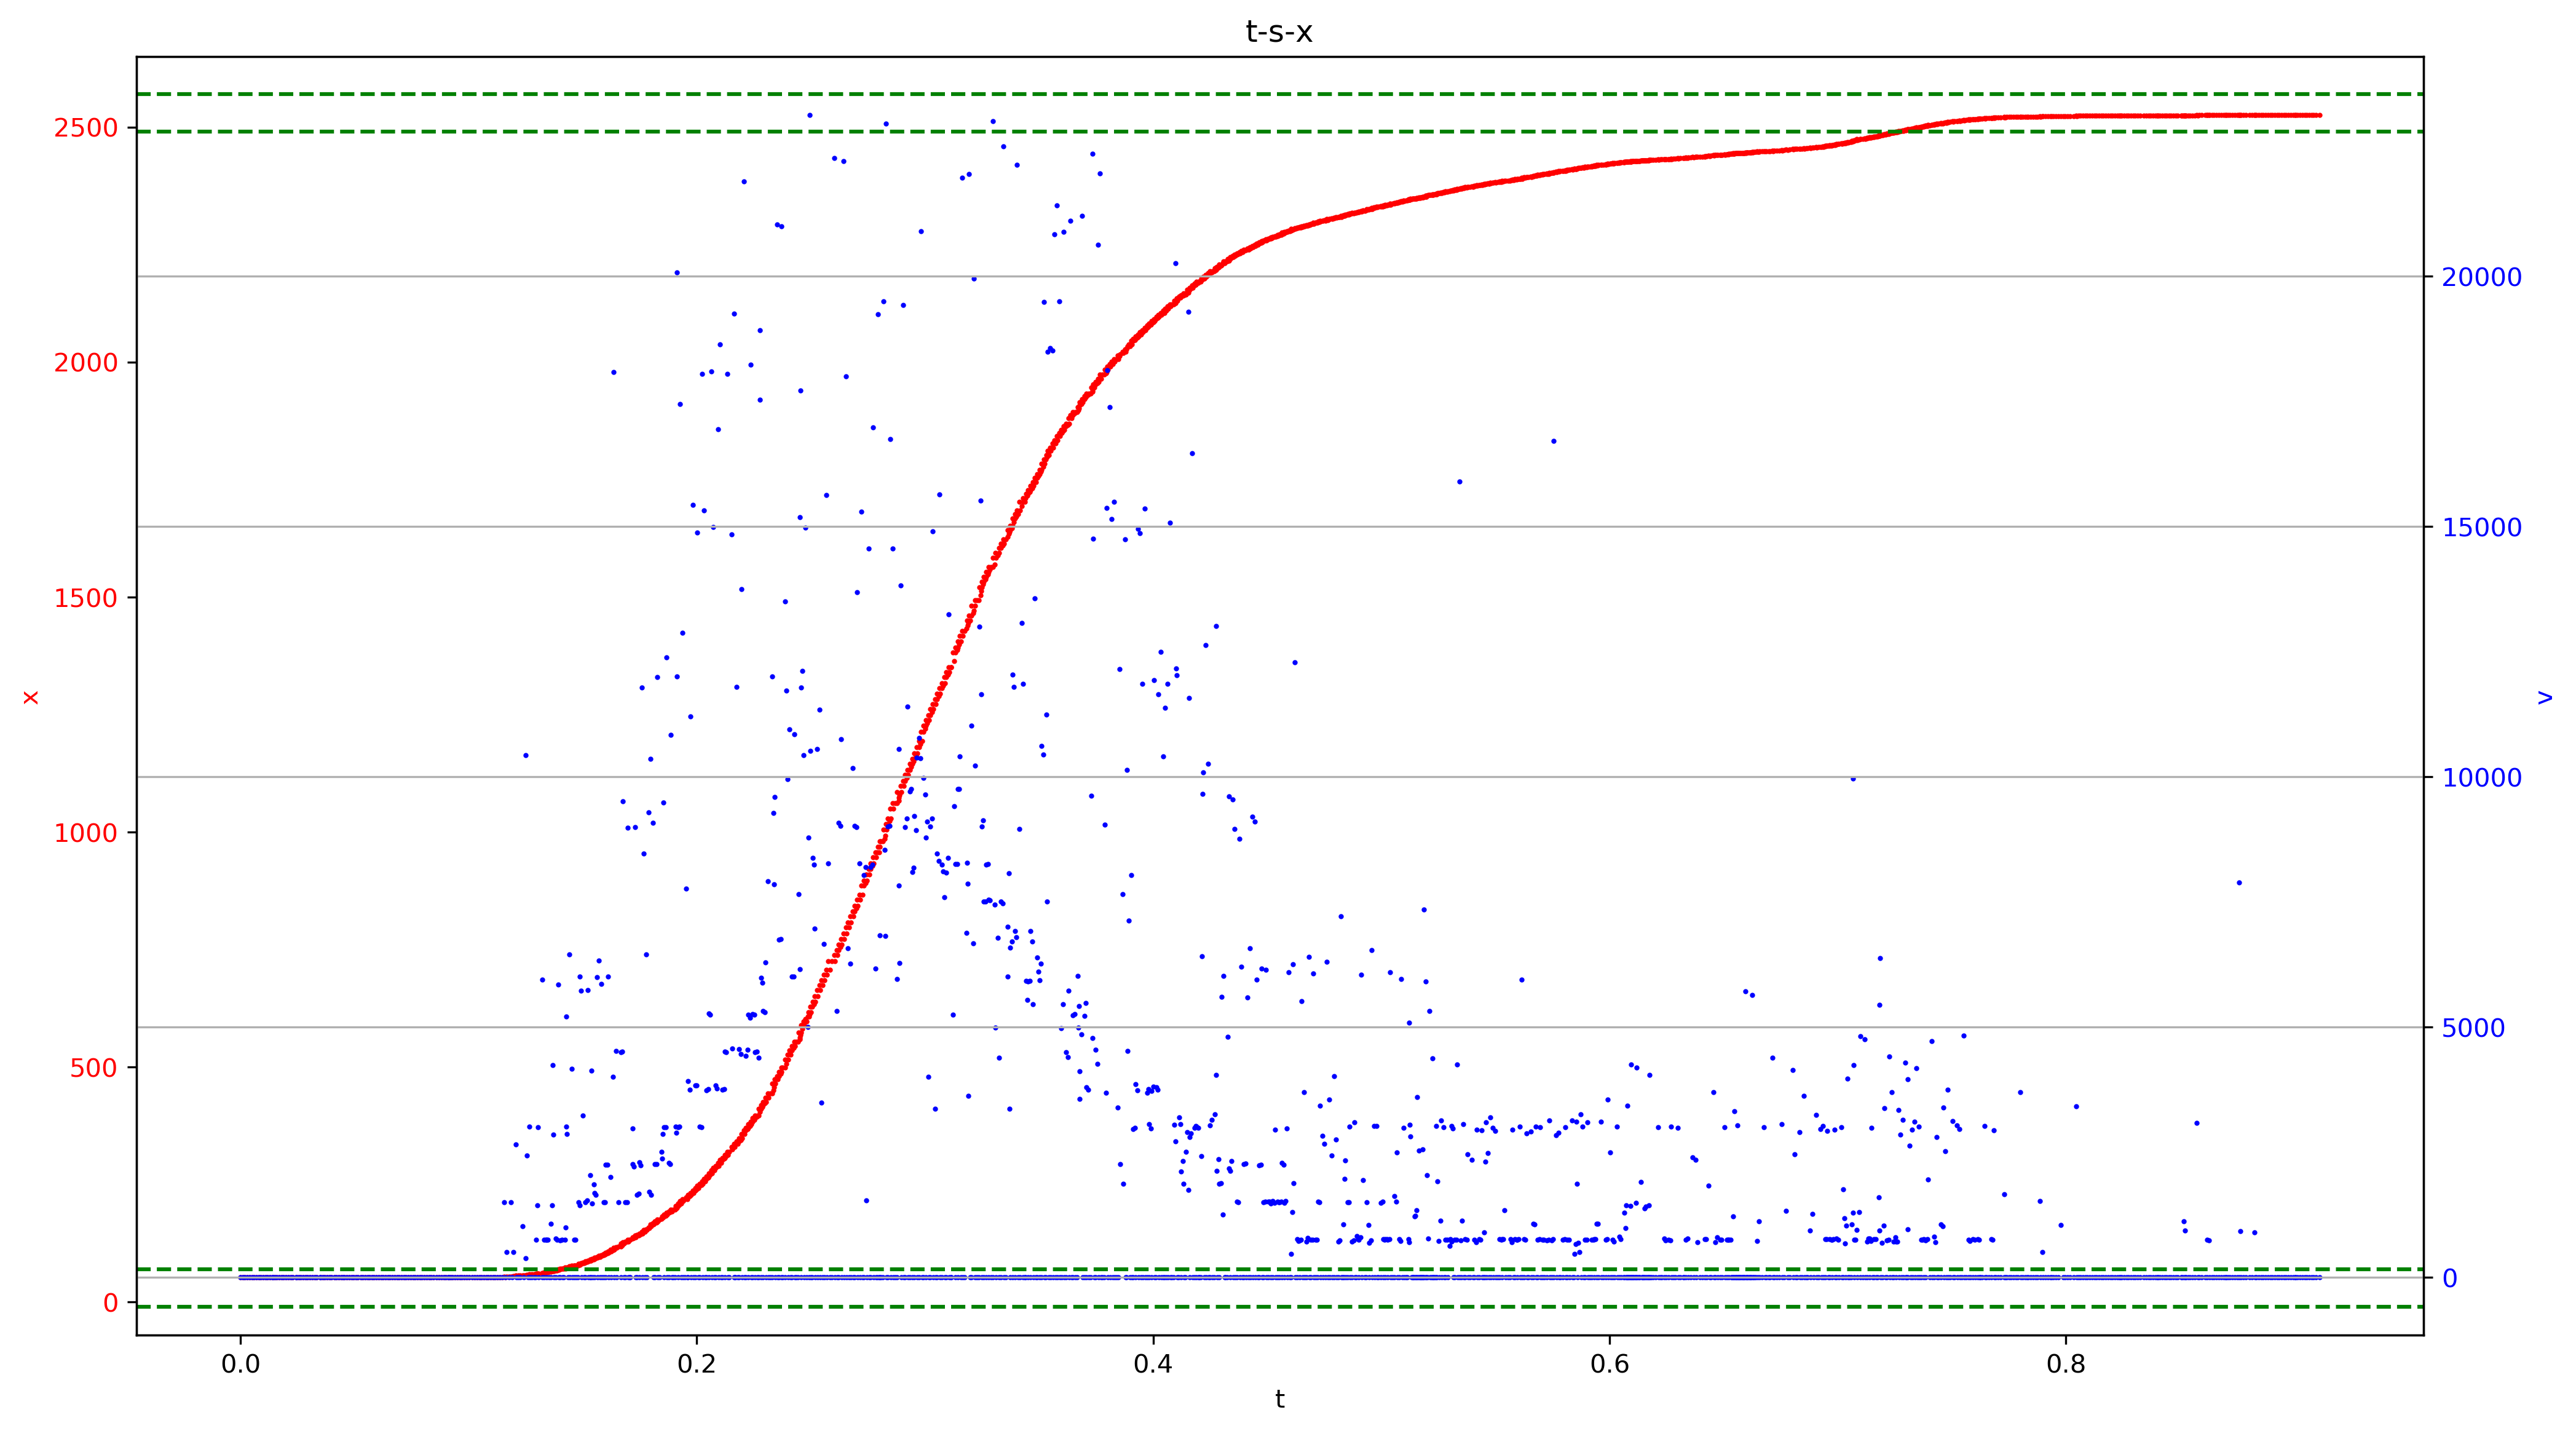

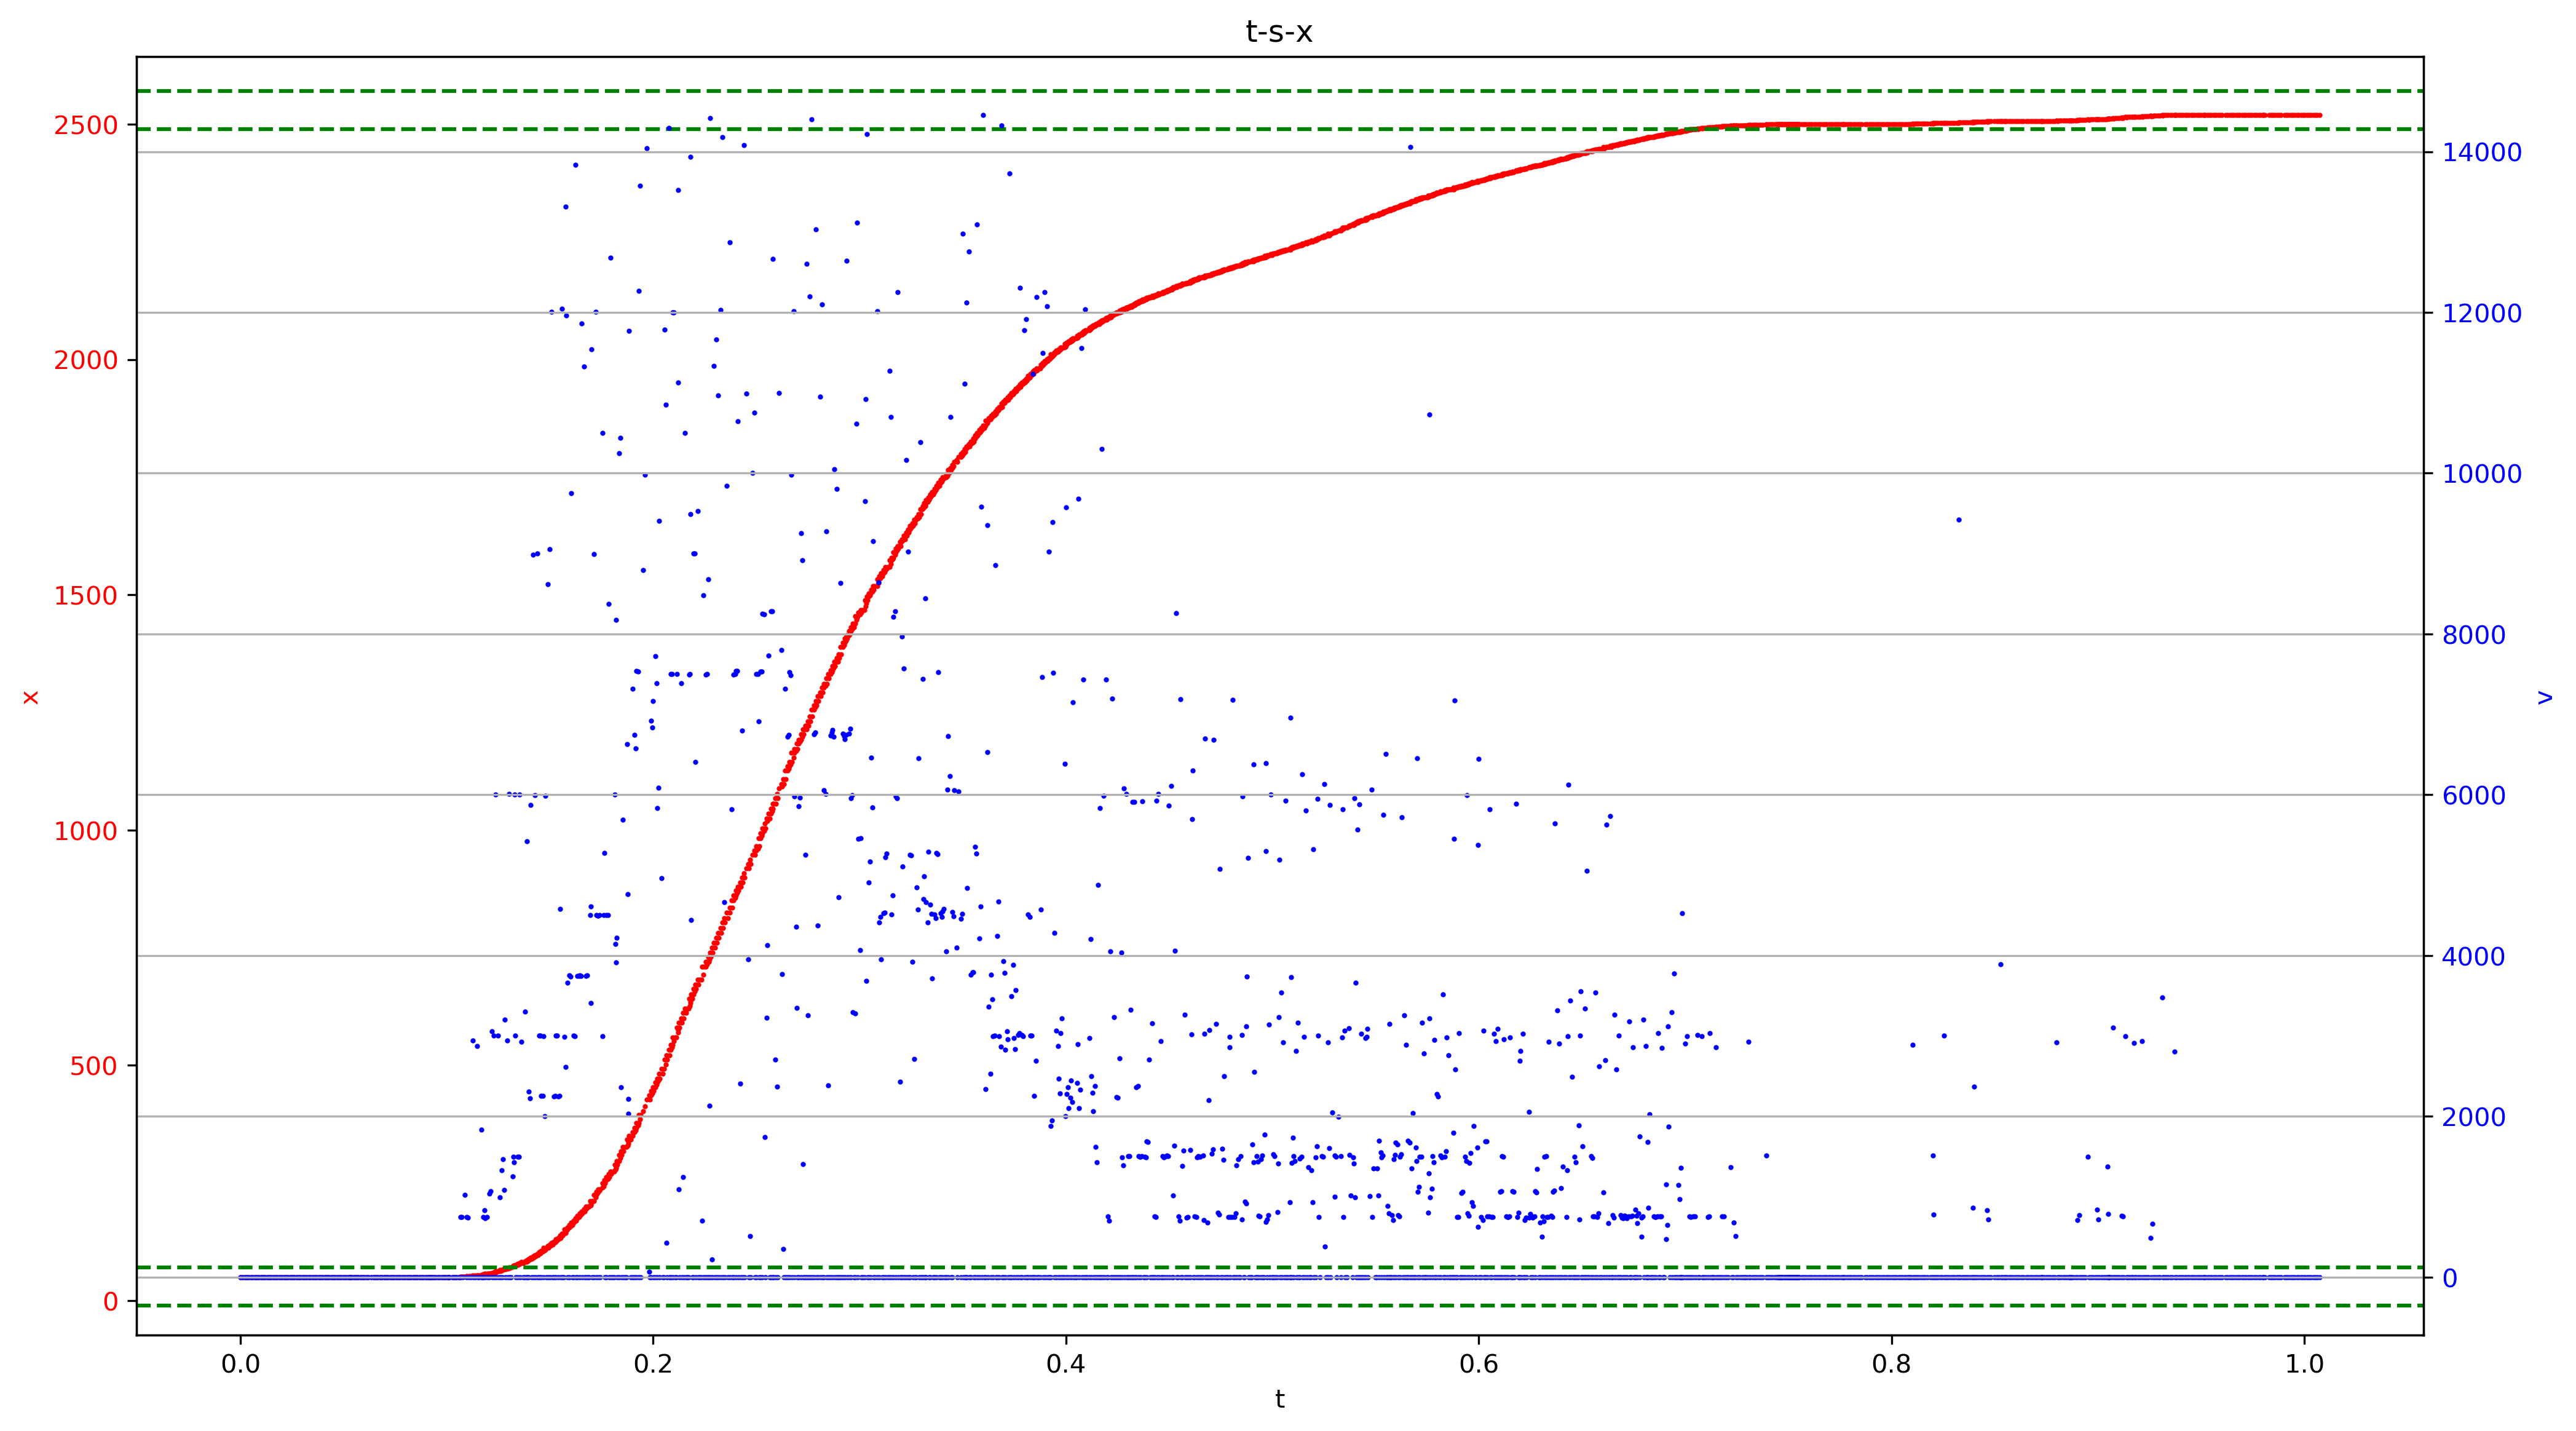

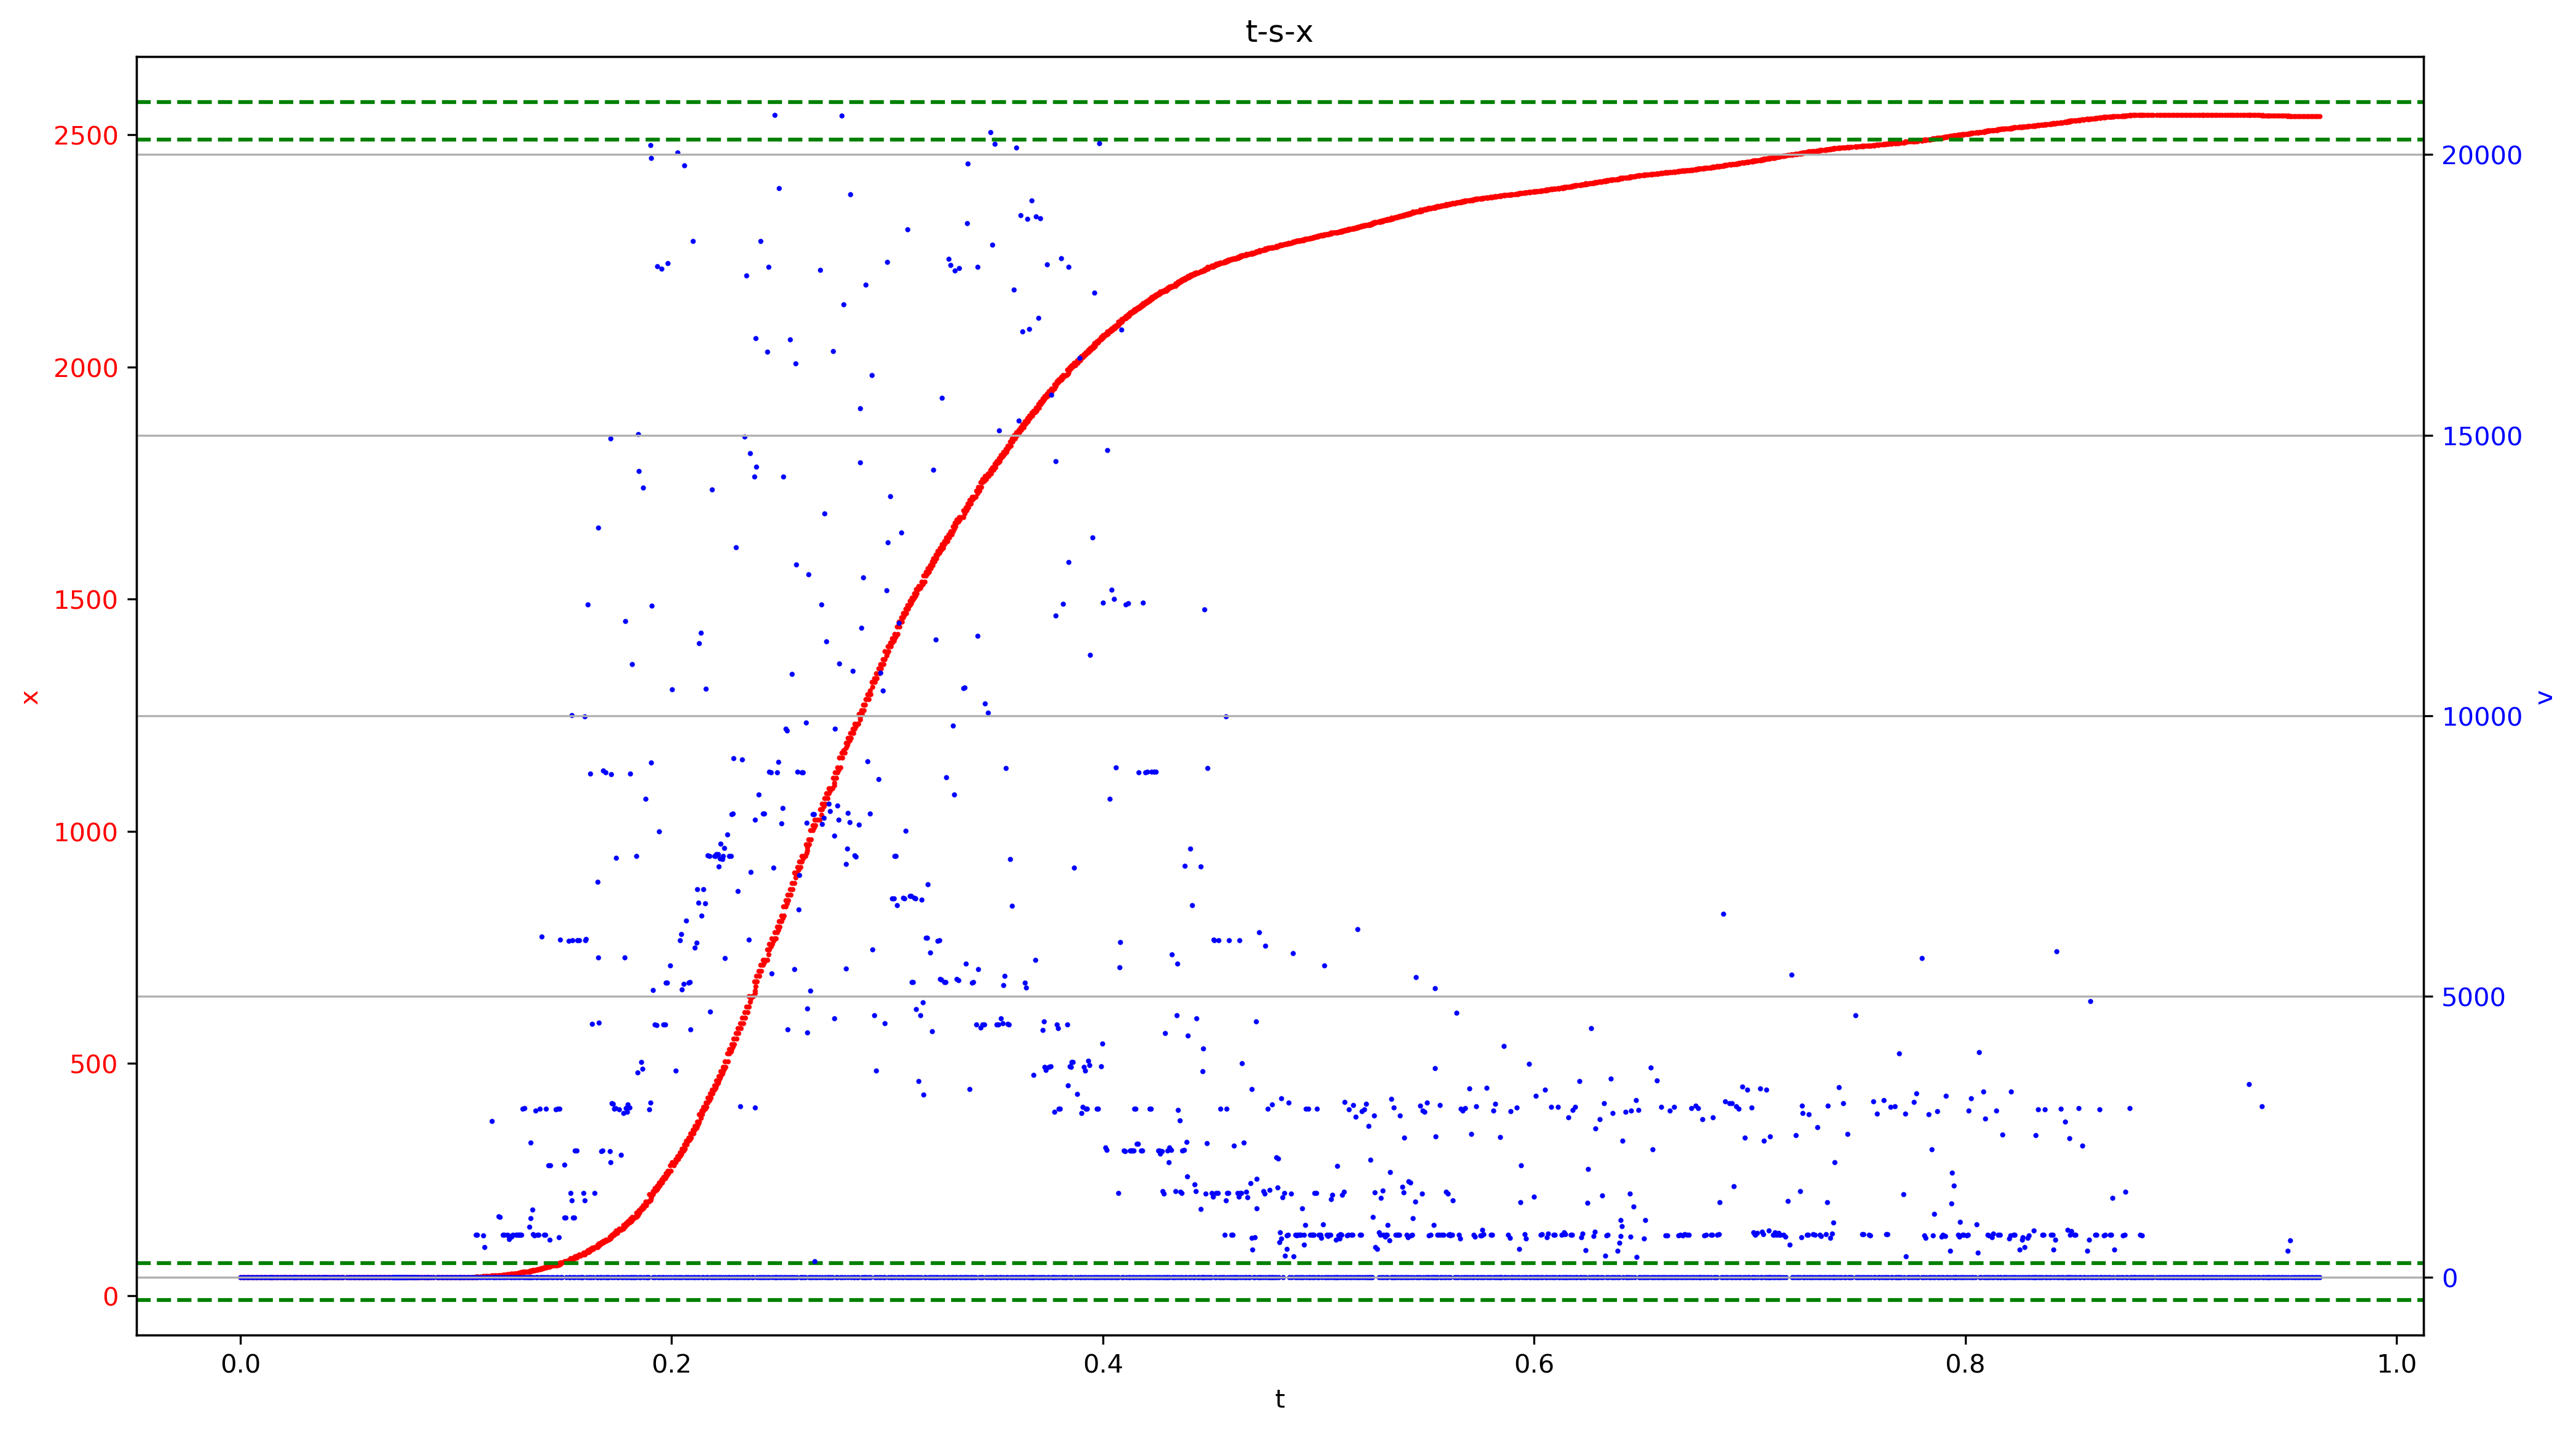

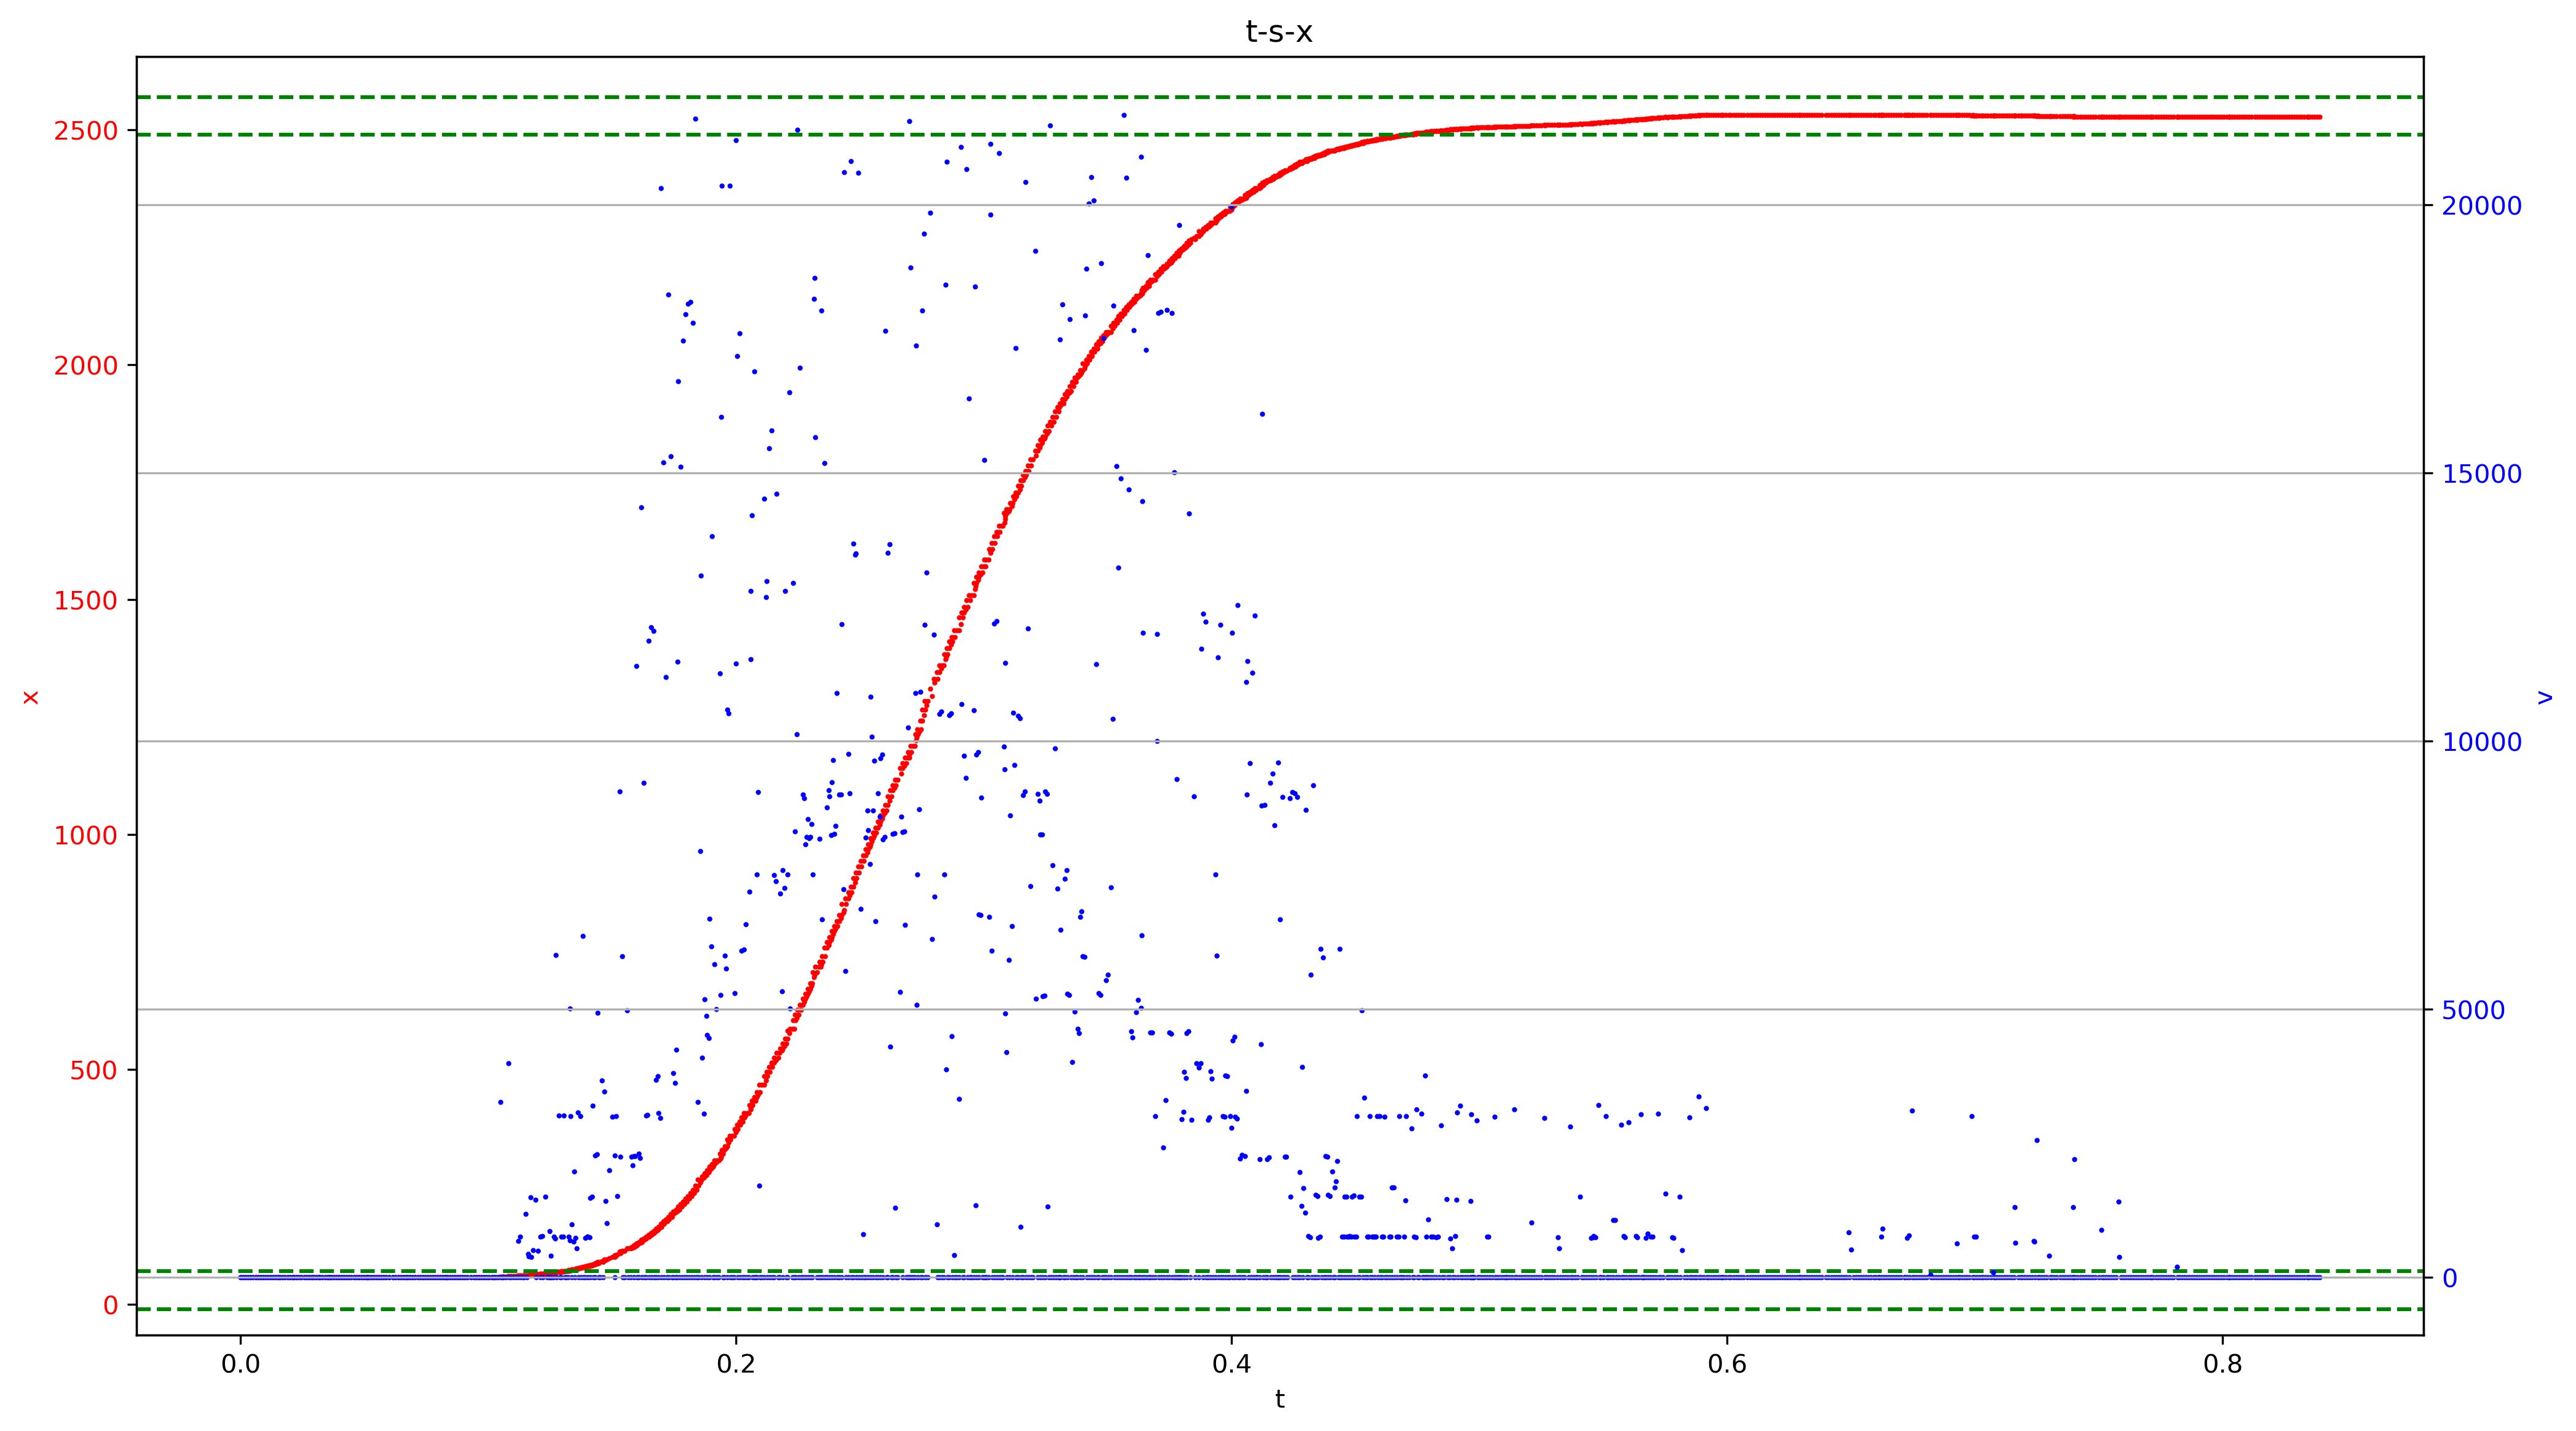

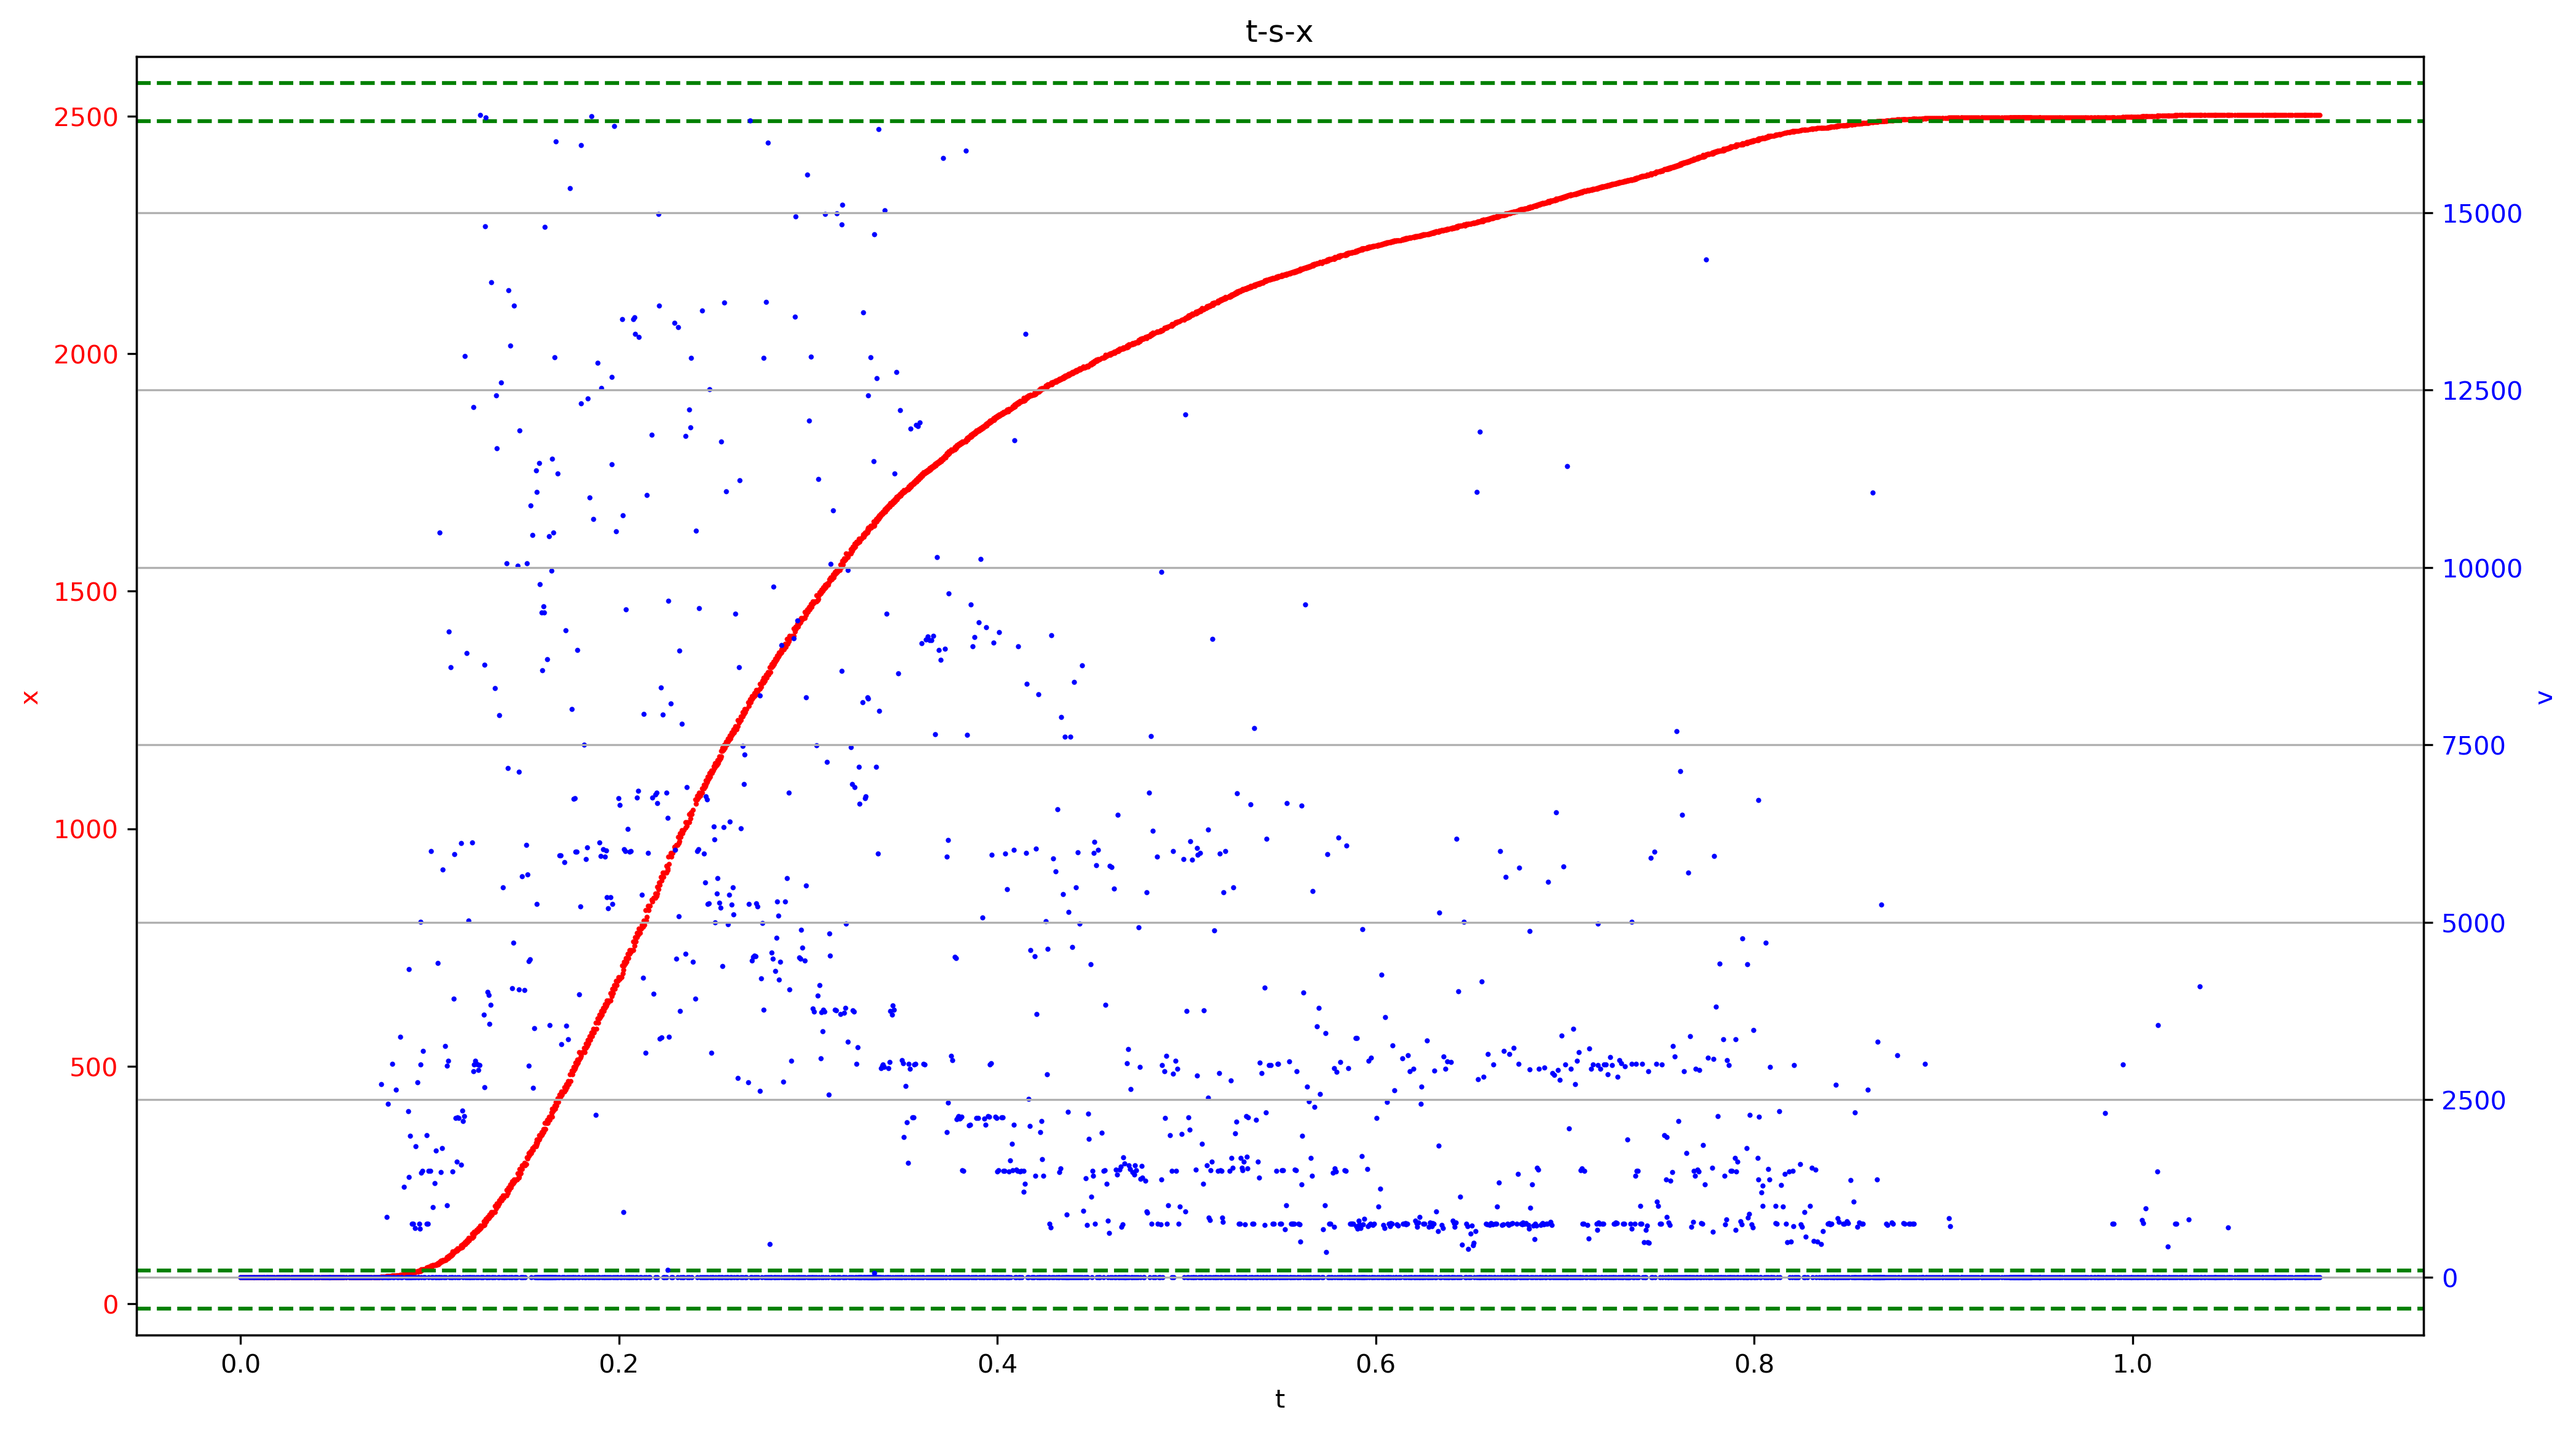

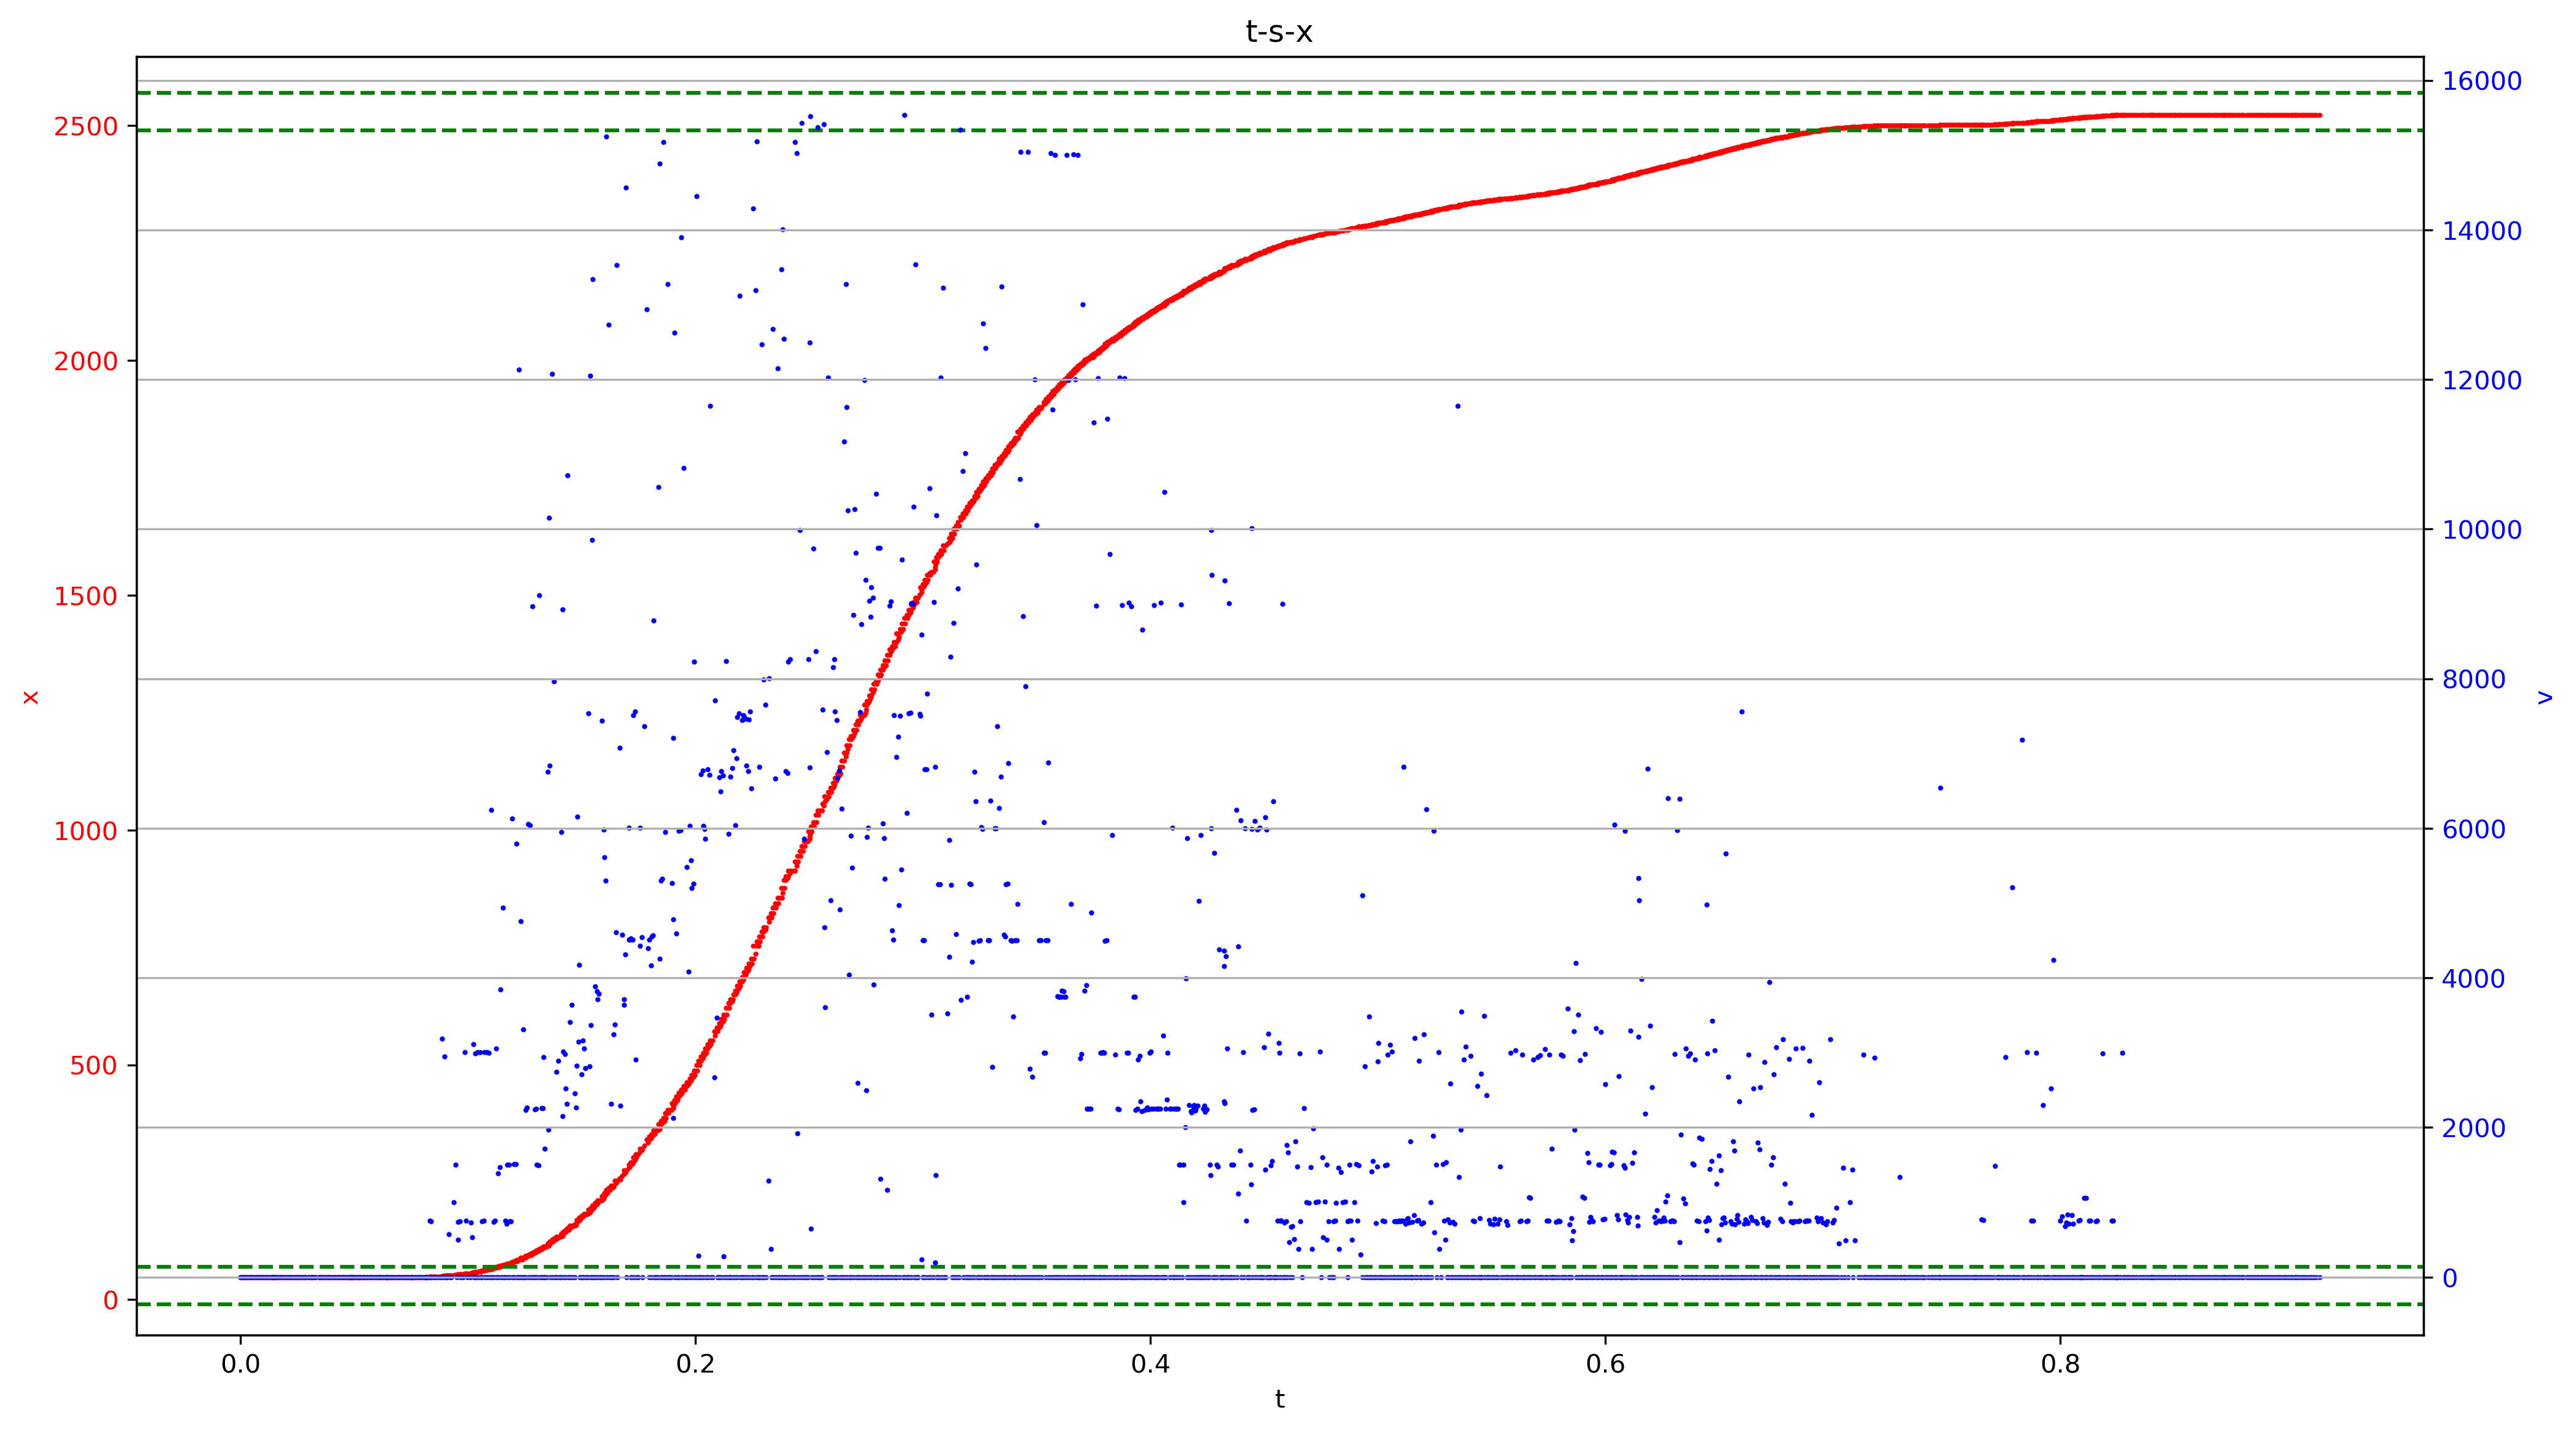

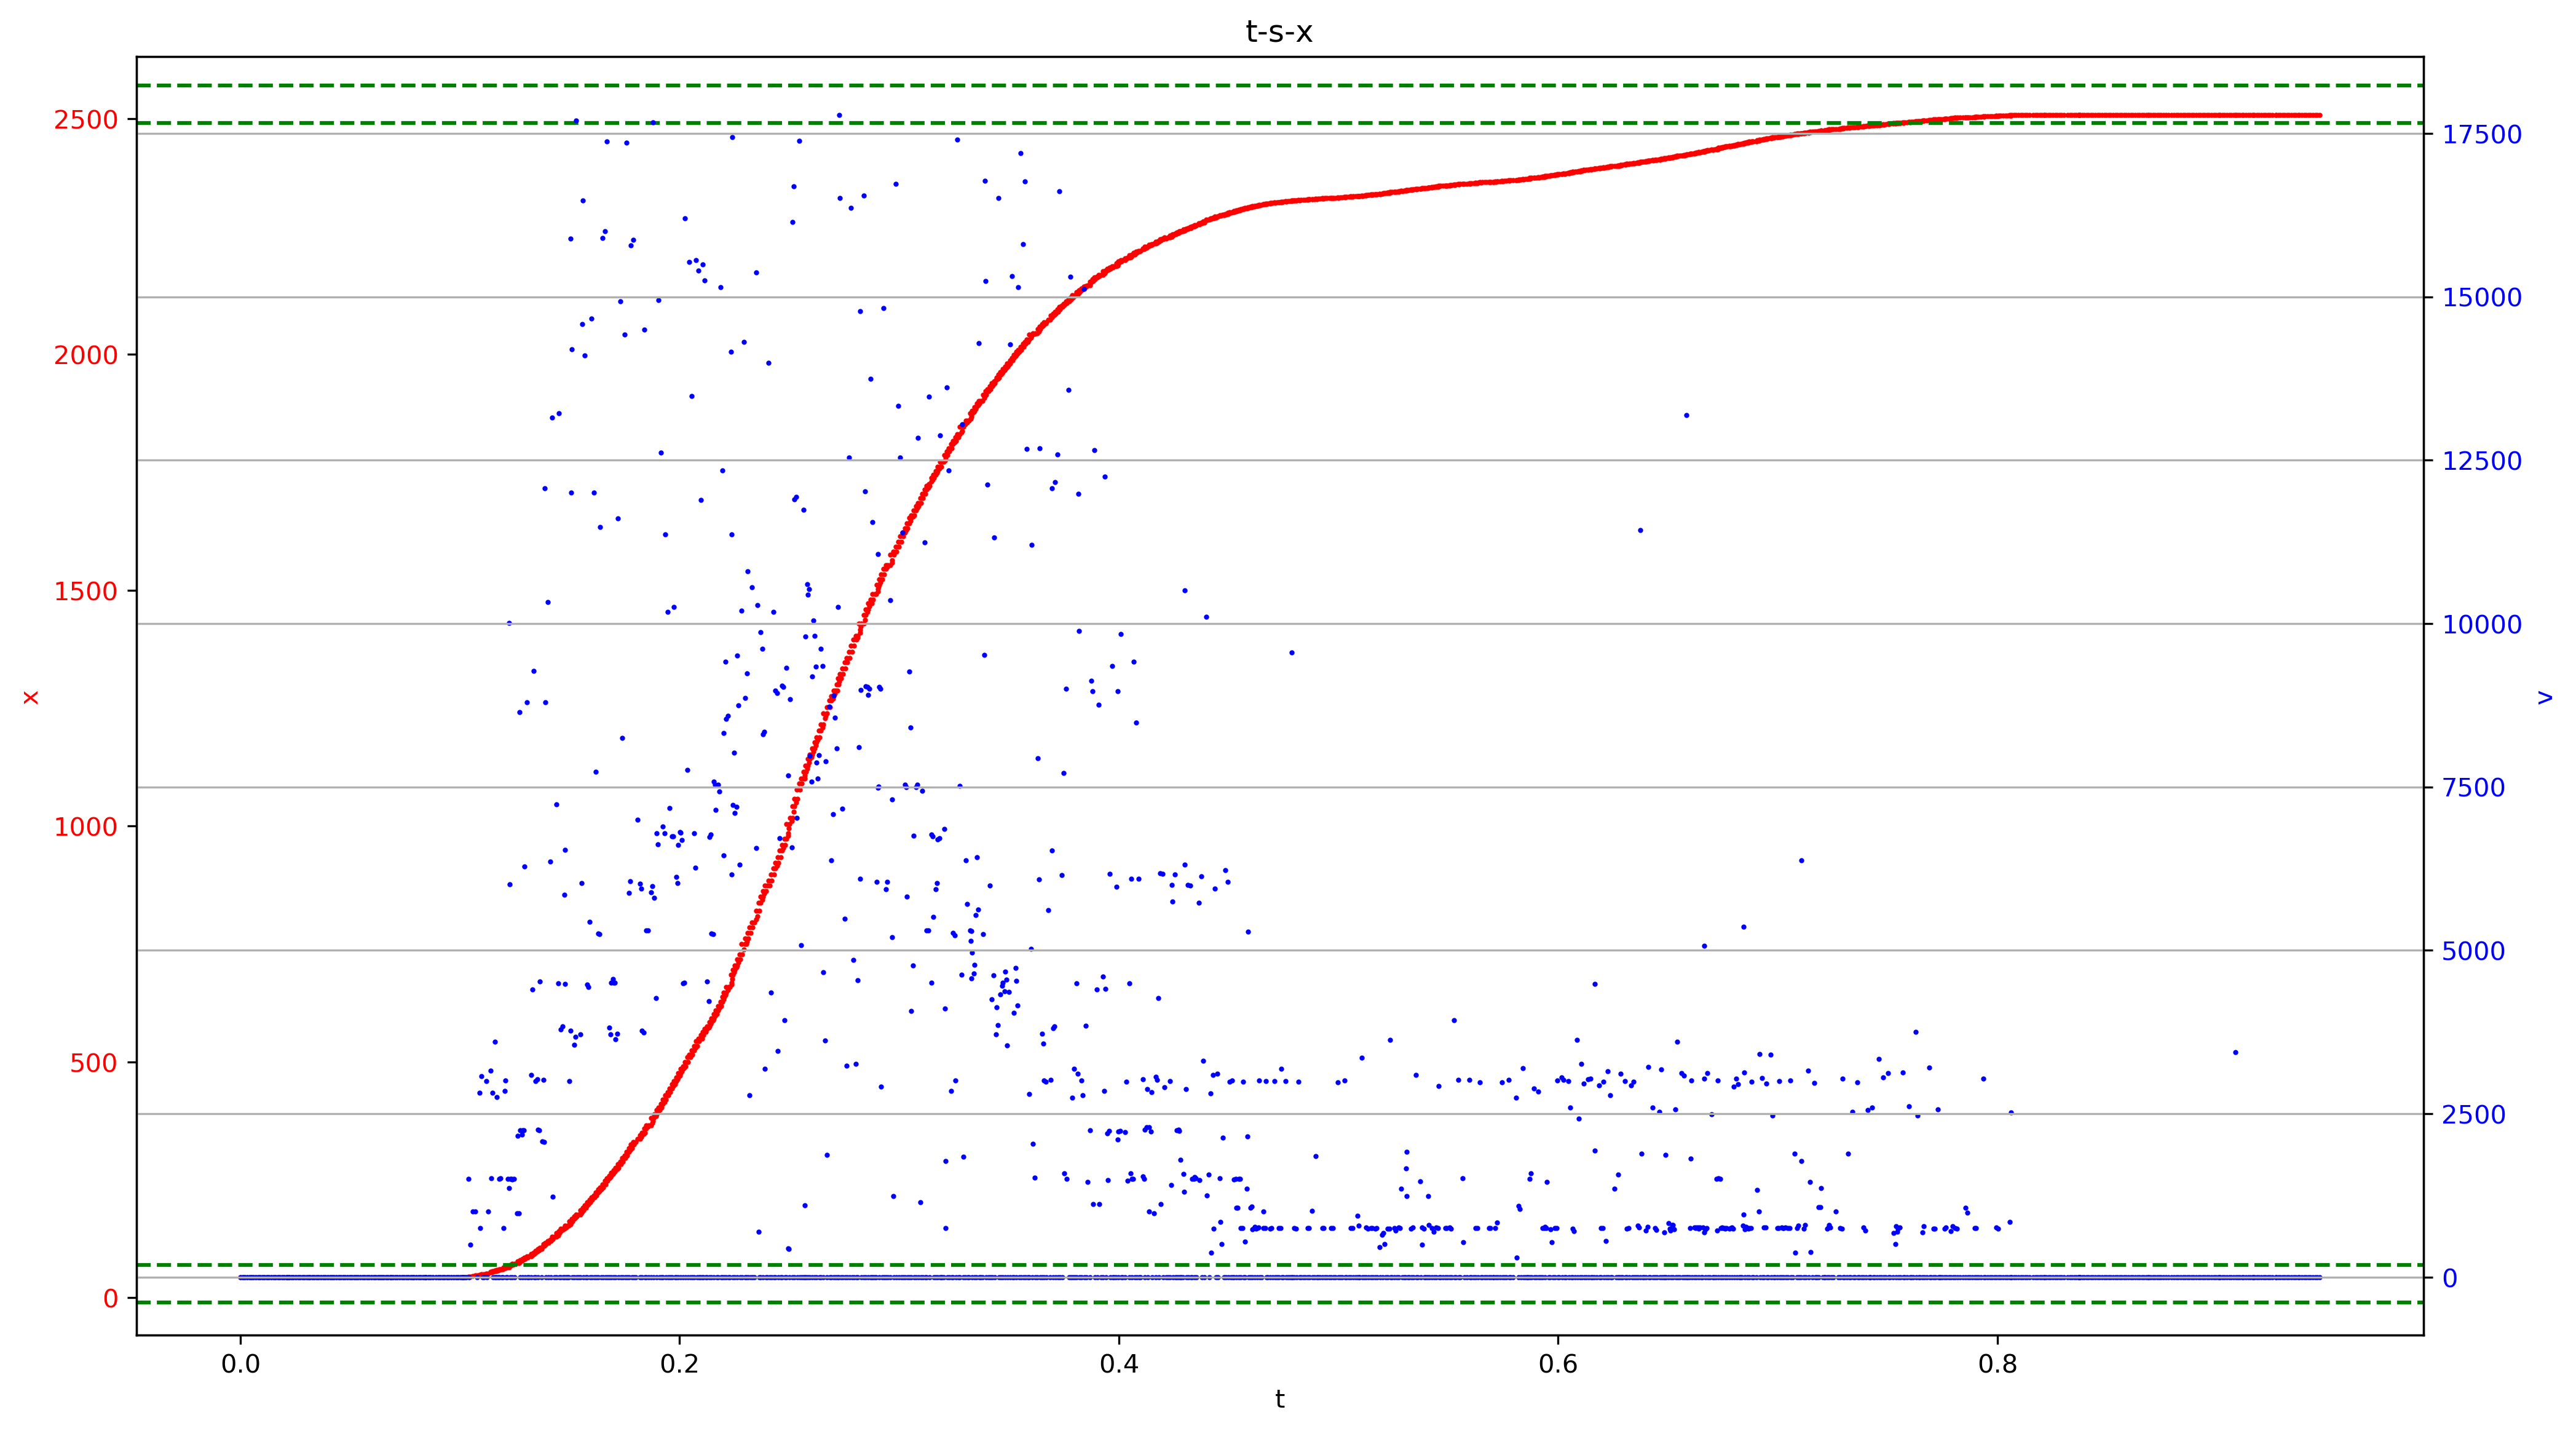

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

x_edge1=screen_wide/2-d1/2-w1/2
x_edge2=screen_wide/2-d1/2+w1/2
x_edge3=screen_wide/2+d1/2-w1/2
x_edge4=screen_wide/2+d1/2+w1/2

y_edge1=screen_high/2-w2/2
y_edge2=screen_high/2+w2/2

colors = [
('red', '#FF0000'),
('black', '#00FF00'),
('blue', '#0000FF'),
('green', '#000000'),
]

sorted_colors = sorted(colors)

#plt.figure(figsize=(16, 9),dpi=300)
print(len(Track))
for i in range(len(Track)):
    fig, ax1 = plt.subplots()
    fig.dpi=300
    fig.set_size_inches(16, 9)
    #plt.figure(figsize=(16, 9),dpi=300)
    X=np.array(Track[i]['t'].values.tolist())
    Y=np.array(Track[i]['x'].values.tolist())
    Z=np.array(Track[i]['v'].values.tolist())
    
    # 绘制原始数据和拟合曲线
    ax1.set_xlabel('t')
    ax1.set_ylabel('x', color=colors[0][0])
    ax1.scatter(X, Y, color=colors[0][0],s=1)
    ax1.tick_params(axis='y', labelcolor=colors[0][0])
    ax1.axhline(y=x_edge1, color=colors[3][0], linestyle='--', )
    ax1.axhline(y=x_edge2, color=colors[3][0], linestyle='--', )
    ax1.axhline(y=x_edge3, color=colors[3][0], linestyle='--', )
    ax1.axhline(y=x_edge4, color=colors[3][0], linestyle='--', )
    
    ax2 = ax1.twinx()  # 创建共享X轴的第二个坐标轴

    ax2.set_ylabel('v', color=colors[2][0])
    ax2.scatter(X, Z, color=colors[2][0],s=1)
    #ax2.axhline(y=y_edge1, color=colors[2][0], linestyle='-', )
    #ax2.axhline(y=y_edge2, color=colors[2][0], linestyle='-', )
    
    
    ax2.tick_params(axis='y', labelcolor=colors[2][0])
    
    plt.title('t-s-x')
    #plt.legend()
    plt.grid(True)
    plt.show()